In [1]:
import csv

file_path = r"C:\Users\Narula\india_selected_cities_cleaned.csv"

try:
    with open(file_path, mode='r', newline='', encoding='utf-8') as file:
        csv_reader = csv.reader(file)

        headers = next(csv_reader)
        print("Headers:", headers)

        print("\nTop 5 Rows:\n")
        for i, row in enumerate(csv_reader):
            if i == 5:   # stop after 5 rows
                break
            print(row)

except FileNotFoundError:
    print(f"The file at {file_path} was not found.")
except Exception as e:
    print(f"An error occurred: {e}")


Headers: ['scrape_id', 'lat', 'lon', 'locationId', 'city', 'state', 'country', 'last_updated', 'AQI_IN', 'AQI_US', 'CO_PPB', 'H_PERCENT', 'NO2_PPB', 'O3_PPB', 'PM10_UGM3', 'PM2_5_UGM3', 'SO2_PPB', 'T_C', 'PM1_UGM3', 'TVOC_PPM', 'Noise_DB']

Top 5 Rows:

['624', '30.6324', '76.7244', '48F6EE546F34', 'Manauli', 'Punjab', 'India', '2025-11-09 17:22:00', '92', '149', '', '45', '', '', '68', '55', '', '24.5', '36.0', '0.21', '65.0']
['635', '30.6999', '76.835', 'PLLODA000621', 'Chandigarh', 'Chandigarh', 'India', '2025-11-09 17:23:00', '83', '137', '454.0', '38', '9.0', '13.0', '60', '50', '3.0', '19.0', '', '', '']
['636', '30.7058', '76.8532', '8680', 'Panchkula', 'Haryana', 'India', '2025-11-09 17:22:00', '82', '134', '309.0', '38', '10.0', '8.0', '60', '49', '2.0', '19.0', '', '', '']
['637', '30.6995', '76.8176', 'PLLODA000600', 'Chandigarh', 'Chandigarh', 'India', '2025-11-09 17:23:00', '87', '142', '511.0', '38', '8.0', '18.0', '60', '52', '3.0', '19.0', '', '', '']
['639', '30.6912'

In [31]:
import pandas as pd

# Load the full CSV — keep all historical data
df = pd.read_csv(file_path)

# Create a separate dataframe for unique stations (metadata only)
unique_stations = df[['locationId', 'lat', 'lon', 'city']].drop_duplicates().reset_index(drop=True)

# --- Outputs ---
print("=== Full Dataset ===")
print(df.head())  # just show first 5 rows of full data
print(f"\nTotal rows in full dataset: {len(df)}")

print("\n=== Unique Stations ===")
print(unique_stations)
print(f"\nTotal unique stations: {len(unique_stations)}")


=== Full Dataset ===
   scrape_id      lat      lon    locationId                        city  \
0        624  30.6324  76.7244  48F6EE546F34                     Manauli   
1        635  30.6999  76.8350  PLLODA000621                  Chandigarh   
2        636  30.7058  76.8532          8680                   Panchkula   
3        637  30.6995  76.8176  PLLODA000600                  Chandigarh   
4        639  30.6912  76.7443  48F6EE549CB8  Sahibzada Ajit Singh Nagar   

        state country         last_updated  AQI_IN  AQI_US  ...  H_PERCENT  \
0      Punjab   India  2025-11-09 17:22:00      92     149  ...         45   
1  Chandigarh   India  2025-11-09 17:23:00      83     137  ...         38   
2     Haryana   India  2025-11-09 17:22:00      82     134  ...         38   
3  Chandigarh   India  2025-11-09 17:23:00      87     142  ...         38   
4      Punjab   India  2025-11-09 17:22:00      67     112  ...         45   

   NO2_PPB  O3_PPB  PM10_UGM3  PM2_5_UGM3  SO2_PPB   

In [32]:
import pandas as pd
import folium
from IPython.display import display

df = pd.read_csv(file_path)

unique_locations = df[['locationId', 'lat', 'lon', 'city']].drop_duplicates()

center_lat = unique_locations['lat'].mean()
center_lon = unique_locations['lon'].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

for _, row in unique_locations.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=f"ID: {row['locationId']}\nCity: {row['city']}",
    ).add_to(m)

display(m)


# SPATIAL AUTOCORRELATION
## GLOBAL SPATIAL AUTOCORRELATION
calc the Global Moran's I to check if the particular parameter is clustered in tricity

In [13]:
import pandas as pd
import geopandas as gpd
from libpysal.weights import KNN
from esda import Moran
import numpy as np

file_path = r"C:\Users\Narula\india_selected_cities_cleaned.csv"
df = pd.read_csv(file_path)
df = df.sort_values('last_updated').drop_duplicates('locationId', keep='last')

pollutants = [
    'AQI_IN',
    'CO_PPB',
    'NO2_PPB',
    'O3_PPB',
    'PM10_UGM3',
    'PM2_5_UGM3',
    'SO2_PPB'
]

for col in pollutants:
    df[col] = pd.to_numeric(df[col], errors='coerce')


gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['lon'], df['lat']),
    crs='EPSG:4326'
)

w = KNN.from_dataframe(gdf, k=6)
w.transform = 'R'    

results = []


def interpret_moran(i, p):
    if p < 0.05 and abs(i) > 0.3:
        return "Strong spatial clustering"
    elif p < 0.05:
        return "Moderate spatial clustering"
    else:
        return "No significant spatial clustering"


for col in pollutants:

    series = gdf[col]

    if series.isna().all():
        results.append([col, np.nan, np.nan, np.nan, "No valid data"])
        continue

    series = series.fillna(series.mean())

    if series.std() == 0:
        results.append([col, np.nan, np.nan, np.nan, "No variance in data"])
        continue

    mi = Moran(series, w)

    interpretation = interpret_moran(mi.I, mi.p_sim)

    results.append([
        col,
        round(mi.I, 4),
        round(mi.p_sim, 5),
        round(mi.z_sim, 4),
        interpretation
    ])


results_df = pd.DataFrame(
    results,
    columns=["Pollutant", "Moran_I", "p-value", "z-score", "Interpretation"]
)

print(results_df)


    Pollutant  Moran_I  p-value  z-score                     Interpretation
0      AQI_IN   0.0326    0.155   1.0037  No significant spatial clustering
1      CO_PPB   0.0835    0.095   1.4084  No significant spatial clustering
2     NO2_PPB   0.3685    0.002   4.4945          Strong spatial clustering
3      O3_PPB   0.3433    0.001   4.1159          Strong spatial clustering
4   PM10_UGM3   0.0233    0.203   0.7663  No significant spatial clustering
5  PM2_5_UGM3   0.0335    0.197   0.7994  No significant spatial clustering
6     SO2_PPB   0.1573    0.033   2.3452        Moderate spatial clustering


^^^ spacial analysis for the latest reading  
Types of Clustering:  
Positive Clustering(i>0): High values near high values, low values near low values (like wealthy neighborhoods clustering together)  
Negative Clustering(i<0): High values near low values (checkerboard pattern)  
Random: No spatial pattern(i=0) - values are randomly distribute  

application of clustering
- clustered pollutants - localized sources (traffic, industry)  
- no clustering - regional/backgroud sources

Global Moran's I
Moran's I = (n/∑w) × [∑∑w_ij×(x_i - mean)×(x_j - mean)] / [∑(x_i - mean)²]  
____________________________________

C:\Users\Narula\AppData\Roaming\Python\Python312\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
C:\Users\Narula\AppData\Roaming\Python\Python312\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
C:\Users\Narula\AppData\Roaming\Python\Python312\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
C:\Users\Narula\AppData\Roaming\Python\Python312\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
C:\Users\Narula\


=== Final Moran's I Spatial Pattern Summary ===

    Pollutant  Strong_Count  Moderate_Count  None_Count
0      AQI_IN           140             486         968
1      CO_PPB           289             540         765
2     NO2_PPB           848             536         210
3      O3_PPB           645             456         493
4   PM10_UGM3           124             399        1071
5  PM2_5_UGM3           143             476         975
6     SO2_PPB           289             320         985


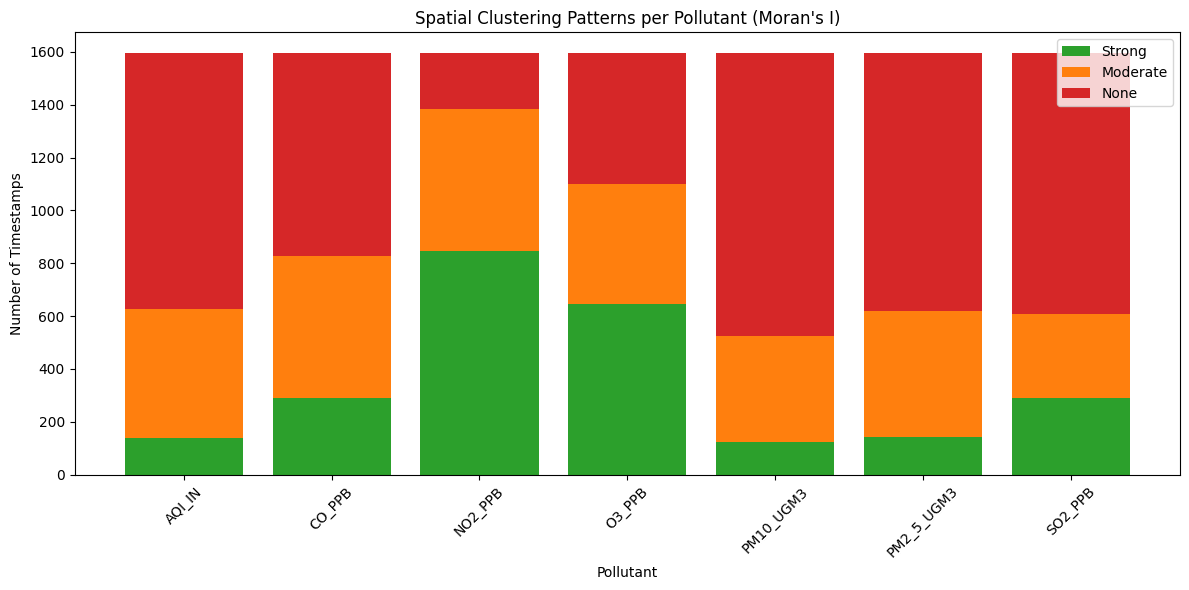


=== Dataset Statistics ===
Total timestamps analyzed: 3727
Stations analyzed: 20
Date range: 2025-11-09 17:22:00 to 2025-11-22 17:12:00

=== Clustering Percentages ===
AQI_IN: Strong 8.8%, Moderate 30.5%, None 60.7%
CO_PPB: Strong 18.1%, Moderate 33.9%, None 48.0%
NO2_PPB: Strong 53.2%, Moderate 33.6%, None 13.2%
O3_PPB: Strong 40.5%, Moderate 28.6%, None 30.9%
PM10_UGM3: Strong 7.8%, Moderate 25.0%, None 67.2%
PM2_5_UGM3: Strong 9.0%, Moderate 29.9%, None 61.2%
SO2_PPB: Strong 18.1%, Moderate 20.1%, None 61.8%


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Your existing spatial analysis code (first part)
import pandas as pd
import geopandas as gpd
from libpysal.weights import KNN
from esda import Moran
import numpy as np
from collections import Counter

file_path = r"C:\Users\Narula\india_selected_cities_cleaned.csv"
df = pd.read_csv(file_path)

df['last_updated'] = pd.to_datetime(df['last_updated'])

pollutants = [
    'AQI_IN',
    'CO_PPB',
    'NO2_PPB',
    'O3_PPB',
    'PM10_UGM3',
    'PM2_5_UGM3',
    'SO2_PPB'
]

for col in pollutants:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df[df['lat'] > 30.60]

def interpret_moran(moran_I, p):
    if p < 0.05 and abs(moran_I) > 0.3:
        return "Strong"
    elif p < 0.05:
        return "Moderate"
    else:
        return "None"

final_counts = {col: Counter() for col in pollutants}

for ts, sub in df.groupby('last_updated'):
    if len(sub) < 6:
        continue

    gdf = gpd.GeoDataFrame(
        sub,
        geometry=gpd.points_from_xy(sub['lon'], sub['lat']),
        crs='EPSG:4326'
    )

    try:
        w = KNN.from_dataframe(gdf, k=6)
        w.transform = 'R'
    except:
        continue

    for col in pollutants:
        series = gdf[col]

        if series.isna().all():
            final_counts[col]["None"] += 1
            continue

        series = series.fillna(series.mean())

        if series.std() == 0:
            final_counts[col]["None"] += 1
            continue

        try:
            mi = Moran(series, w)
            interpretation = interpret_moran(mi.I, mi.p_sim)
        except:
            interpretation = "None"

        final_counts[col][interpretation] += 1

# Create the summary dataframe from actual results
summary_df = pd.DataFrame([
    [
        col,
        final_counts[col]["Strong"],
        final_counts[col]["Moderate"],
        final_counts[col]["None"]
    ]
    for col in pollutants
], columns=["Pollutant", "Strong_Count", "Moderate_Count", "None_Count"])

print("\n=== Final Moran's I Spatial Pattern Summary ===\n")
print(summary_df)

# DYNAMIC VISUALIZATION USING ACTUAL RESULTS
plt.figure(figsize=(12, 6))

# Create stacked bar chart using the actual results
plt.bar(summary_df["Pollutant"], summary_df["Strong_Count"], label="Strong", color="#2ca02c")
plt.bar(summary_df["Pollutant"], summary_df["Moderate_Count"], bottom=summary_df["Strong_Count"], label="Moderate", color="#ff7f0e")
plt.bar(summary_df["Pollutant"], summary_df["None_Count"], bottom=summary_df["Strong_Count"] + summary_df["Moderate_Count"], label="None", color="#d62728")

plt.xlabel("Pollutant")
plt.ylabel("Number of Timestamps")
plt.title("Spatial Clustering Patterns per Pollutant (Moran's I)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Additional: Print some statistics about the data
print(f"\n=== Dataset Statistics ===")
print(f"Total timestamps analyzed: {len(df['last_updated'].unique())}")
print(f"Stations analyzed: {len(df['locationId'].unique())}")
print(f"Date range: {df['last_updated'].min()} to {df['last_updated'].max()}")

# Calculate percentages for better interpretation
print(f"\n=== Clustering Percentages ===")
for _, row in summary_df.iterrows():
    total = row['Strong_Count'] + row['Moderate_Count'] + row['None_Count']
    strong_pct = (row['Strong_Count'] / total) * 100
    moderate_pct = (row['Moderate_Count'] / total) * 100
    none_pct = (row['None_Count'] / total) * 100
    print(f"{row['Pollutant']}: Strong {strong_pct:.1f}%, Moderate {moderate_pct:.1f}%, None {none_pct:.1f}%")

## LOCAL SPATIAL AUTOCORRELATION
### LISA - local Moran's I

In [41]:
import pandas as pd
import geopandas as gpd
from libpysal.weights import KNN
from esda import Moran_Local
import numpy as np


file_path = r"C:\Users\Narula\india_selected_cities_cleaned.csv"
df = pd.read_csv(file_path)

num_cols = [
    'AQI_IN','AQI_US','CO_PPB','H_PERCENT','NO2_PPB','O3_PPB',
    'PM10_UGM3','PM2_5_UGM3','SO2_PPB','T_C','PM1_UGM3',
    'TVOC_PPM','Noise_DB'
]
for col in num_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')


df['last_updated'] = pd.to_datetime(df['last_updated'])
latest_df = (
    df.sort_values('last_updated')
      .groupby('locationId')
      .tail(1)
      .reset_index(drop=True)
)


gdf = gpd.GeoDataFrame(
    latest_df,
    geometry=gpd.points_from_xy(latest_df['lon'], latest_df['lat']),
    crs='EPSG:4326'
)


k = 6
w = KNN.from_dataframe(gdf, k=k)
w.transform = 'R'


pollutant = "AQI_IN"  
values = gdf[pollutant].fillna(gdf[pollutant].mean())

lisa = Moran_Local(values, w)


cluster_labels = np.array(["Not Significant"] * len(gdf))
sig = lisa.p_sim < 0.05

cluster_labels[sig & (values > values.mean()) & (lisa.Is > 0)] = "Hotspot (High-High)"
cluster_labels[sig & (values < values.mean()) & (lisa.Is > 0)] = "Coldspot (Low-Low)"
cluster_labels[sig & (values > values.mean()) & (lisa.Is < 0)] = "High-Low (Outlier)"
cluster_labels[sig & (values < values.mean()) & (lisa.Is < 0)] = "Low-High (Outlier)"


results = pd.DataFrame({
    "location_id": gdf['locationId'],
    "city": gdf['city'],
    "pollutant": pollutant,
    "value": values,
    "moran_I": lisa.Is,
    "p_value": lisa.p_sim,
    "cluster": cluster_labels
})

print("\n=== LISA Results (Latest Reading) ===")
print(results.sort_values("cluster", ascending=False))

hotspots = results[results['cluster'] == "Hotspot (High-High)"]
print("\n=== Hotspots ===")
print(hotspots)



=== LISA Results (Latest Reading) ===
     location_id                        city pollutant  value   moran_I  \
0   48F6EE5481E0                     Manauli    AQI_IN    170  0.415909   
8        VIR4221                  Chandigarh    AQI_IN    190  0.028823   
17  48F6EE549CB8  Sahibzada Ajit Singh Nagar    AQI_IN    160  0.520537   
16  48F6EE568468                  Chandigarh    AQI_IN    123  0.434129   
15  E4B06332EC44                  Chandigarh    AQI_IN    147 -0.733097   
13  PLLODA000621                  Chandigarh    AQI_IN    203  0.044417   
12  PLLODA000600                  Chandigarh    AQI_IN    233  0.050385   
1          12428                  Chandigarh    AQI_IN    213  0.168818   
10       -160063                   Panchkula    AQI_IN    220  0.082967   
6   PLLODA000591                  Chandigarh    AQI_IN    183  0.049709   
5          13741                  Chandigarh    AQI_IN    190 -0.001373   
4       VIR14156                       Mauli    AQI_IN    183

In [43]:
import pandas as pd
import geopandas as gpd
from libpysal.weights import KNN
from esda import Moran_Local
import numpy as np


file_path = r"C:\Users\Narula\india_selected_cities_cleaned.csv"
df = pd.read_csv(file_path)

df['last_updated'] = pd.to_datetime(df['last_updated'])


latest_df = (
    df.sort_values('last_updated')
      .groupby('locationId')
      .tail(1)
      .reset_index(drop=True)
)


latest_df = latest_df[latest_df['NO2_PPB'].notna()]


gdf = gpd.GeoDataFrame(
    latest_df,
    geometry=gpd.points_from_xy(latest_df['lon'], latest_df['lat']),
    crs='EPSG:4326'
)


w = KNN.from_dataframe(gdf, k=6)
w.transform = 'R'


pollutant = "NO2_PPB"
values = gdf[pollutant].fillna(gdf[pollutant].mean())

lisa = Moran_Local(values, w)


cluster_labels = np.array(["Not Significant"] * len(gdf))
sig = lisa.p_sim < 0.05

cluster_labels[sig & (values > values.mean()) & (lisa.Is > 0)] = "Hotspot (High-High)"
cluster_labels[sig & (values < values.mean()) & (lisa.Is > 0)] = "Coldspot (Low-Low)"
cluster_labels[sig & (values > values.mean()) & (lisa.Is < 0)] = "High-Low (Outlier)"
cluster_labels[sig & (values < values.mean()) & (lisa.Is < 0)] = "Low-High (Outlier)"


results = pd.DataFrame({
    "locationId": gdf['locationId'],
    "pollutant": pollutant,
    "moran_I": lisa.Is,
    "p_value": lisa.p_sim,
    "cluster": cluster_labels
})

print("\n=== LISA Results for NO2 (Only Sensors Measuring NO2) ===")
print(results)



=== LISA Results for NO2 (Only Sensors Measuring NO2) ===
      locationId pollutant   moran_I  p_value          cluster
1          12428   NO2_PPB -0.800368    0.068  Not Significant
2           8680   NO2_PPB  0.584597    0.034  Coldspot (Low-L
3   PLLODA000685   NO2_PPB  0.032851    0.355  Not Significant
4       VIR14156   NO2_PPB  0.380772    0.019  Hotspot (High-H
5          13741   NO2_PPB  0.106765    0.221  Not Significant
6   PLLODA000591   NO2_PPB  0.004106    0.397  Not Significant
7          13876   NO2_PPB  0.601769    0.023  Hotspot (High-H
8        VIR4221   NO2_PPB -0.010453    0.379  Not Significant
9   PLLODA000245   NO2_PPB  0.193372    0.134  Not Significant
10       -160063   NO2_PPB  0.541293    0.023  Coldspot (Low-L
11  PLLODA000170   NO2_PPB  0.604755    0.001  Hotspot (High-H
12  PLLODA000600   NO2_PPB  0.400184    0.025  Coldspot (Low-L
13  PLLODA000621   NO2_PPB  0.500976    0.029  Coldspot (Low-L
14  PLLODA000590   NO2_PPB  0.967609    0.002  Hotspot (Hig

In [45]:
import folium
from folium.plugins import HeatMap


results_filtered = results[results['moran_I'] != 0]

gdf = gdf.merge(
    results_filtered[['locationId', 'cluster']],
    on='locationId',
    how='left'
)

gdf['cluster'] = gdf['cluster'].fillna("Not Significant")

cluster_colors = {
    "Hotspot (High-H)": "red",
    "Coldspot (Low-L)": "blue",
    "High-Low": "orange",
    "Low-High": "purple",
    "Not Significant": "gray"
}

center_lat = gdf['lat'].mean()
center_lon = gdf['lon'].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

for _, row in gdf.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=6,
        color=cluster_colors.get(row['cluster'], "black"),
        fill=True,
        fill_color=cluster_colors.get(row['cluster'], "black"),
        fill_opacity=0.8,
        popup=f"ID: {row['locationId']}\nCluster: {row['cluster']}\nNO2: {row['NO2_PPB']}"
    ).add_to(m)

heat_data = [[row['lat'], row['lon'], row['NO2_PPB']] for _, row in gdf.iterrows()]
HeatMap(heat_data, radius=25, blur=15, max_zoom=12).add_to(m)

m


In [7]:
import pandas as pd
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_breusch_godfrey
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

file_path = r"C:\Users\Narula\india_selected_cities_cleaned.csv"
df = pd.read_csv(file_path)

# ---------------------------
# SETTINGS
# ---------------------------
pollutant = "NO2_PPB"   # change to any pollutant
max_lag = 12            # how many lags to test in Ljung-Box & BG

# ---------------------------
# PREP
# ---------------------------
df['last_updated'] = pd.to_datetime(df['last_updated'])
df = df.sort_values(['locationId', 'last_updated'])

results = []

for station, sub in df.groupby("locationId"):
    
    # ensure enough data
    if sub[pollutant].dropna().shape[0] < max_lag + 2:
        continue
    
    # Build simple OLS model: pollutant on time trend
    y = sub[pollutant].astype(float)
    X = np.arange(len(sub)).reshape(-1,1)
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()
    
    residuals = model.resid
    
    # -----------------------------------
    # 1. Durbin–Watson (tests lag=1)
    # -----------------------------------
    dw_stat = durbin_watson(residuals)
    
    # Durbin-Watson interpretation
    if dw_stat < 1.0:
        dw_interpretation = "Very strong positive autocorrelation"
    elif dw_stat < 1.5:
        dw_interpretation = "Strong positive autocorrelation"
    elif dw_stat < 2.0:
        dw_interpretation = "Moderate positive autocorrelation"
    elif dw_stat == 2.0:
        dw_interpretation = "No autocorrelation"
    elif dw_stat < 2.5:
        dw_interpretation = "Moderate negative autocorrelation"
    else:
        dw_interpretation = "Strong negative autocorrelation"
    
    # -----------------------------------
    # 2. Ljung–Box test
    # -----------------------------------
    ljung_box = acorr_ljungbox(residuals, lags=[max_lag], return_df=True)
    lb_stat = ljung_box['lb_stat'].iloc[0]
    lb_p = ljung_box['lb_pvalue'].iloc[0]
    
    # Ljung-Box interpretation
    if lb_p < 0.01:
        lb_interpretation = "Extreme autocorrelation across multiple lags"
    elif lb_p < 0.05:
        lb_interpretation = "Significant autocorrelation across multiple lags"
    else:
        lb_interpretation = "No significant autocorrelation across lags"
    
    # -----------------------------------
    # 3. Breusch–Godfrey LM test
    # -----------------------------------
    bg_stat, bg_p, bg_f, bg_fp = acorr_breusch_godfrey(model, nlags=max_lag)
    
    # Breusch-Godfrey interpretation
    if bg_p < 0.01:
        bg_interpretation = "Extreme higher-order autocorrelation"
    elif bg_p < 0.05:
        bg_interpretation = "Significant higher-order autocorrelation"
    else:
        bg_interpretation = "No significant higher-order autocorrelation"
    
    # Add results for each test separately
    results.append([station, pollutant, "Durbin-Watson", dw_stat, dw_interpretation])
    results.append([station, pollutant, "Ljung-Box", lb_p, lb_interpretation])
    results.append([station, pollutant, "Breusch-Godfrey", bg_p, bg_interpretation])

# Create results dataframe
results_df = pd.DataFrame(results, columns=[
    "Location ID",
    "Pollutant", 
    "Test",
    "Value",
    "Interpretation"
])

# Print results in clean format
print("=" * 80)
print(f"AUTOCORRELATION ANALYSIS RESULTS FOR {pollutant}")
print("=" * 80)

for _, row in results_df.iterrows():
    print(f"Location: {row['Location ID']:15} | {row['Pollutant']:8} | {row['Test']:18} | "
          f"Value: {row['Value']:8.6f} | {row['Interpretation']}")

print("=" * 80)

# Summary statistics
print("\nSUMMARY:")
print(f"Total stations analyzed: {len(results_df['Location ID'].unique())}")
print(f"Tests per station: 3")

# Count interpretations
dw_results = results_df[results_df['Test'] == 'Durbin-Watson']
lb_results = results_df[results_df['Test'] == 'Ljung-Box']
bg_results = results_df[results_df['Test'] == 'Breusch-Godfrey']

print(f"\nDurbin-Watson - Stations with strong/very strong autocorrelation: "
      f"{len(dw_results[dw_results['Value'] < 1.5])}/{len(dw_results)}")

print(f"Ljung-Box - Stations with significant autocorrelation: "
      f"{len(lb_results[lb_results['Value'] < 0.05])}/{len(lb_results)}")

print(f"Breusch-Godfrey - Stations with significant autocorrelation: "
      f"{len(bg_results[bg_results['Value'] < 0.05])}/{len(bg_results)}")

AUTOCORRELATION ANALYSIS RESULTS FOR NO2_PPB
Location: -160063         | NO2_PPB  | Durbin-Watson      | Value: 0.401792 | Very strong positive autocorrelation
Location: -160063         | NO2_PPB  | Ljung-Box          | Value: 0.000000 | Extreme autocorrelation across multiple lags
Location: -160063         | NO2_PPB  | Breusch-Godfrey    | Value: 0.000000 | Extreme higher-order autocorrelation
Location: 12428           | NO2_PPB  | Durbin-Watson      | Value: 0.145957 | Very strong positive autocorrelation
Location: 12428           | NO2_PPB  | Ljung-Box          | Value: 0.000000 | Extreme autocorrelation across multiple lags
Location: 12428           | NO2_PPB  | Breusch-Godfrey    | Value: 0.000000 | Extreme higher-order autocorrelation
Location: 13741           | NO2_PPB  | Durbin-Watson      | Value: 0.052132 | Very strong positive autocorrelation
Location: 13741           | NO2_PPB  | Ljung-Box          | Value: 0.000000 | Extreme autocorrelation across multiple lags
Location: 1

Durbin_Watson -> 0-4  : based on neighbour values  
Ljung-Box p value -> p < 0.01	Extreme Significance  : tests with lags for last 1 to 12 days  
Breusch-Godfrey p value -> p < 0.001	Extreme Significance  : lagged residuals to predict the current residuals  
Strong autocorrelation = Your pollution data is PREDICTABLE and follows SYSTEMATIC PATTERNS  

Analyzing CO_PPB...
Analyzing NO2_PPB...
Analyzing O3_PPB...
Analyzing PM10_UGM3...
Analyzing PM2_5_UGM3...
Analyzing SO2_PPB...


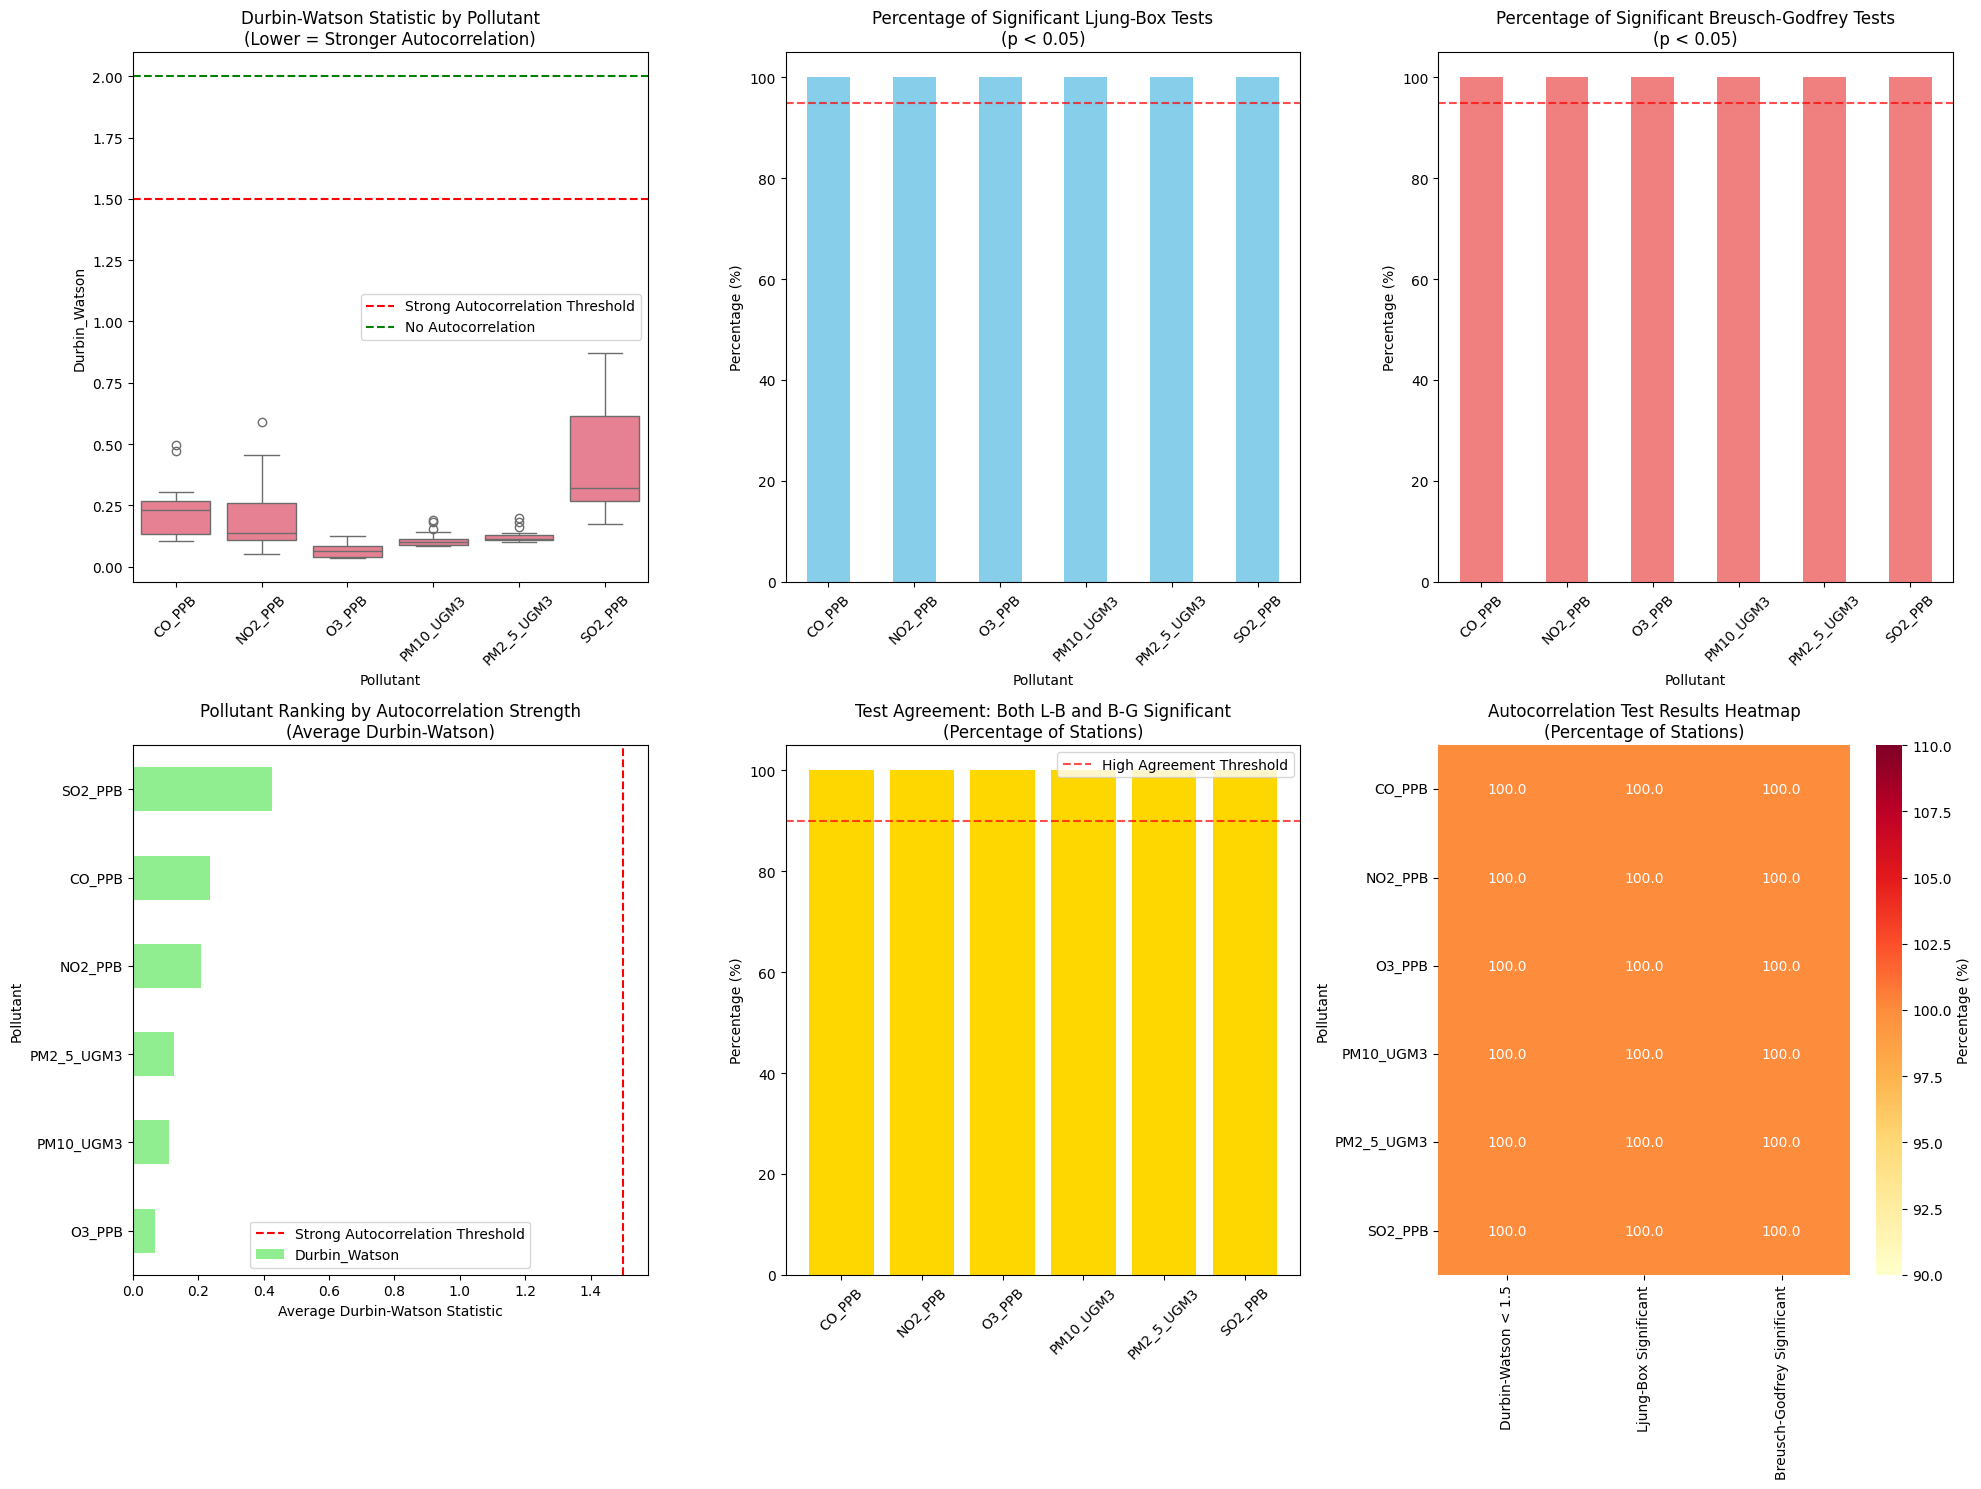


AUTOCORRELATION ANALYSIS SUMMARY - ALL POLLUTANTS
            DW_Mean  DW_Std  DW_Min  DW_Max LB_Significant BG_Significant  \
Pollutant                                                                   
CO_PPB        0.235   0.124   0.104   0.495         100.0%         100.0%   
NO2_PPB       0.209   0.163   0.052   0.592         100.0%         100.0%   
O3_PPB        0.067   0.029   0.037   0.127         100.0%         100.0%   
PM10_UGM3     0.111   0.032   0.083   0.192         100.0%         100.0%   
PM2_5_UGM3    0.125   0.027   0.101   0.200         100.0%         100.0%   
SO2_PPB       0.426   0.224   0.175   0.872         100.0%         100.0%   

            Stations  
Pollutant             
CO_PPB            14  
NO2_PPB           14  
O3_PPB            14  
PM10_UGM3         20  
PM2_5_UGM3        20  
SO2_PPB           14  

Total stations analyzed: 20
Total tests performed: 96


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_breusch_godfrey
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

file_path = r"C:\Users\Narula\india_selected_cities_cleaned.csv"
df = pd.read_csv(file_path)

# ---------------------------
# SETTINGS
# ---------------------------
pollutants = ['CO_PPB', 'NO2_PPB', 'O3_PPB', 'PM10_UGM3', 'PM2_5_UGM3', 'SO2_PPB']
max_lag = 12

# ---------------------------
# PREP
# ---------------------------
df['last_updated'] = pd.to_datetime(df['last_updated'])
df = df.sort_values(['locationId', 'last_updated'])

# Store results for plotting
all_results = []

for pollutant in pollutants:
    print(f"Analyzing {pollutant}...")
    
    for station, sub in df.groupby("locationId"):
        # ensure enough data
        if sub[pollutant].dropna().shape[0] < max_lag + 2:
            continue
        
        # Build simple OLS model: pollutant on time trend
        y = sub[pollutant].astype(float)
        X = np.arange(len(sub)).reshape(-1,1)
        X = sm.add_constant(X)

        model = sm.OLS(y, X).fit()
        residuals = model.resid
        
        # Run all three tests
        dw_stat = durbin_watson(residuals)
        ljung_box = acorr_ljungbox(residuals, lags=[max_lag], return_df=True)
        lb_p = ljung_box['lb_pvalue'].iloc[0]
        bg_stat, bg_p, bg_f, bg_fp = acorr_breusch_godfrey(model, nlags=max_lag)
        
        # Store results
        all_results.append({
            'Pollutant': pollutant,
            'Station': station,
            'Durbin_Watson': dw_stat,
            'Ljung_Box_p': lb_p,
            'Breusch_Godfrey_p': bg_p
        })

# Convert to DataFrame
results_df = pd.DataFrame(all_results)

# ---------------------------
# CREATE VISUALIZATIONS
# ---------------------------

plt.figure(figsize=(20, 15))

# Plot 1: Durbin-Watson Distribution by Pollutant
plt.subplot(2, 3, 1)
sns.boxplot(data=results_df, x='Pollutant', y='Durbin_Watson')
plt.axhline(y=1.5, color='red', linestyle='--', label='Strong Autocorrelation Threshold')
plt.axhline(y=2.0, color='green', linestyle='--', label='No Autocorrelation')
plt.title('Durbin-Watson Statistic by Pollutant\n(Lower = Stronger Autocorrelation)')
plt.xticks(rotation=45)
plt.legend()

# Plot 2: Percentage of Significant Ljung-Box Tests
plt.subplot(2, 3, 2)
lb_significant = results_df.groupby('Pollutant')['Ljung_Box_p'].apply(
    lambda x: (x < 0.05).sum() / len(x) * 100
)
lb_significant.plot(kind='bar', color='skyblue')
plt.axhline(y=95, color='red', linestyle='--', alpha=0.7)
plt.title('Percentage of Significant Ljung-Box Tests\n(p < 0.05)')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)

# Plot 3: Percentage of Significant Breusch-Godfrey Tests
plt.subplot(2, 3, 3)
bg_significant = results_df.groupby('Pollutant')['Breusch_Godfrey_p'].apply(
    lambda x: (x < 0.05).sum() / len(x) * 100
)
bg_significant.plot(kind='bar', color='lightcoral')
plt.axhline(y=95, color='red', linestyle='--', alpha=0.7)
plt.title('Percentage of Significant Breusch-Godfrey Tests\n(p < 0.05)')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)

# Plot 4: Autocorrelation Strength Ranking
plt.subplot(2, 3, 4)
avg_dw = results_df.groupby('Pollutant')['Durbin_Watson'].mean().sort_values()
avg_dw.plot(kind='barh', color='lightgreen')
plt.axvline(x=1.5, color='red', linestyle='--', label='Strong Autocorrelation Threshold')
plt.title('Pollutant Ranking by Autocorrelation Strength\n(Average Durbin-Watson)')
plt.xlabel('Average Durbin-Watson Statistic')
plt.legend()

# Plot 5: Test Agreement Across Pollutants
plt.subplot(2, 3, 5)
agreement_data = []
for pollutant in pollutants:
    sub_df = results_df[results_df['Pollutant'] == pollutant]
    both_significant = ((sub_df['Ljung_Box_p'] < 0.05) & (sub_df['Breusch_Godfrey_p'] < 0.05)).mean() * 100
    agreement_data.append(both_significant)

plt.bar(pollutants, agreement_data, color='gold')
plt.axhline(y=90, color='red', linestyle='--', alpha=0.7, label='High Agreement Threshold')
plt.title('Test Agreement: Both L-B and B-G Significant\n(Percentage of Stations)')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.legend()

# Plot 6: Autocorrelation Heatmap by Pollutant
plt.subplot(2, 3, 6)
# Create a summary score for each pollutant (lower DW = stronger autocorrelation)
autocorr_strength = results_df.groupby('Pollutant').agg({
    'Durbin_Watson': 'mean',
    'Ljung_Box_p': lambda x: (x < 0.05).mean(),
    'Breusch_Godfrey_p': lambda x: (x < 0.05).mean()
})
autocorr_strength['Overall_Score'] = (
    (2 - autocorr_strength['Durbin_Watson']) +  # Lower DW = higher score
    autocorr_strength['Ljung_Box_p'] + 
    autocorr_strength['Breusch_Godfrey_p']
)

# Create heatmap data
heatmap_data = pd.DataFrame({
    'Durbin-Watson < 1.5': (results_df.groupby('Pollutant')['Durbin_Watson'].apply(lambda x: (x < 1.5).mean()) * 100),
    'Ljung-Box Significant': (results_df.groupby('Pollutant')['Ljung_Box_p'].apply(lambda x: (x < 0.05).mean()) * 100),
    'Breusch-Godfrey Significant': (results_df.groupby('Pollutant')['Breusch_Godfrey_p'].apply(lambda x: (x < 0.05).mean()) * 100)
})

sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': 'Percentage (%)'})
plt.title('Autocorrelation Test Results Heatmap\n(Percentage of Stations)')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("AUTOCORRELATION ANALYSIS SUMMARY - ALL POLLUTANTS")
print("="*80)

summary_stats = results_df.groupby('Pollutant').agg({
    'Durbin_Watson': ['mean', 'std', 'min', 'max'],
    'Ljung_Box_p': lambda x: f"{(x < 0.05).mean()*100:.1f}%",
    'Breusch_Godfrey_p': lambda x: f"{(x < 0.05).mean()*100:.1f}%",
    'Station': 'count'
}).round(3)

summary_stats.columns = ['DW_Mean', 'DW_Std', 'DW_Min', 'DW_Max', 'LB_Significant', 'BG_Significant', 'Stations']
print(summary_stats)

print(f"\nTotal stations analyzed: {len(results_df['Station'].unique())}")
print(f"Total tests performed: {len(results_df)}")

Analyzing CO_PPB...
  - 14 stations analyzed for CO_PPB
Analyzing NO2_PPB...
  - 14 stations analyzed for NO2_PPB
Analyzing O3_PPB...
  - 14 stations analyzed for O3_PPB
Analyzing PM10_UGM3...
  - 20 stations analyzed for PM10_UGM3
Analyzing PM2_5_UGM3...
  - 20 stations analyzed for PM2_5_UGM3
Analyzing SO2_PPB...
  - 14 stations analyzed for SO2_PPB

DATA QUALITY SUMMARY:
Total stations analyzed: 20
Total test results: 96

P-value ranges:
Ljung-Box p-values: 0.000000 to 0.000000
Breusch-Godfrey p-values: 0.000000 to 0.000000


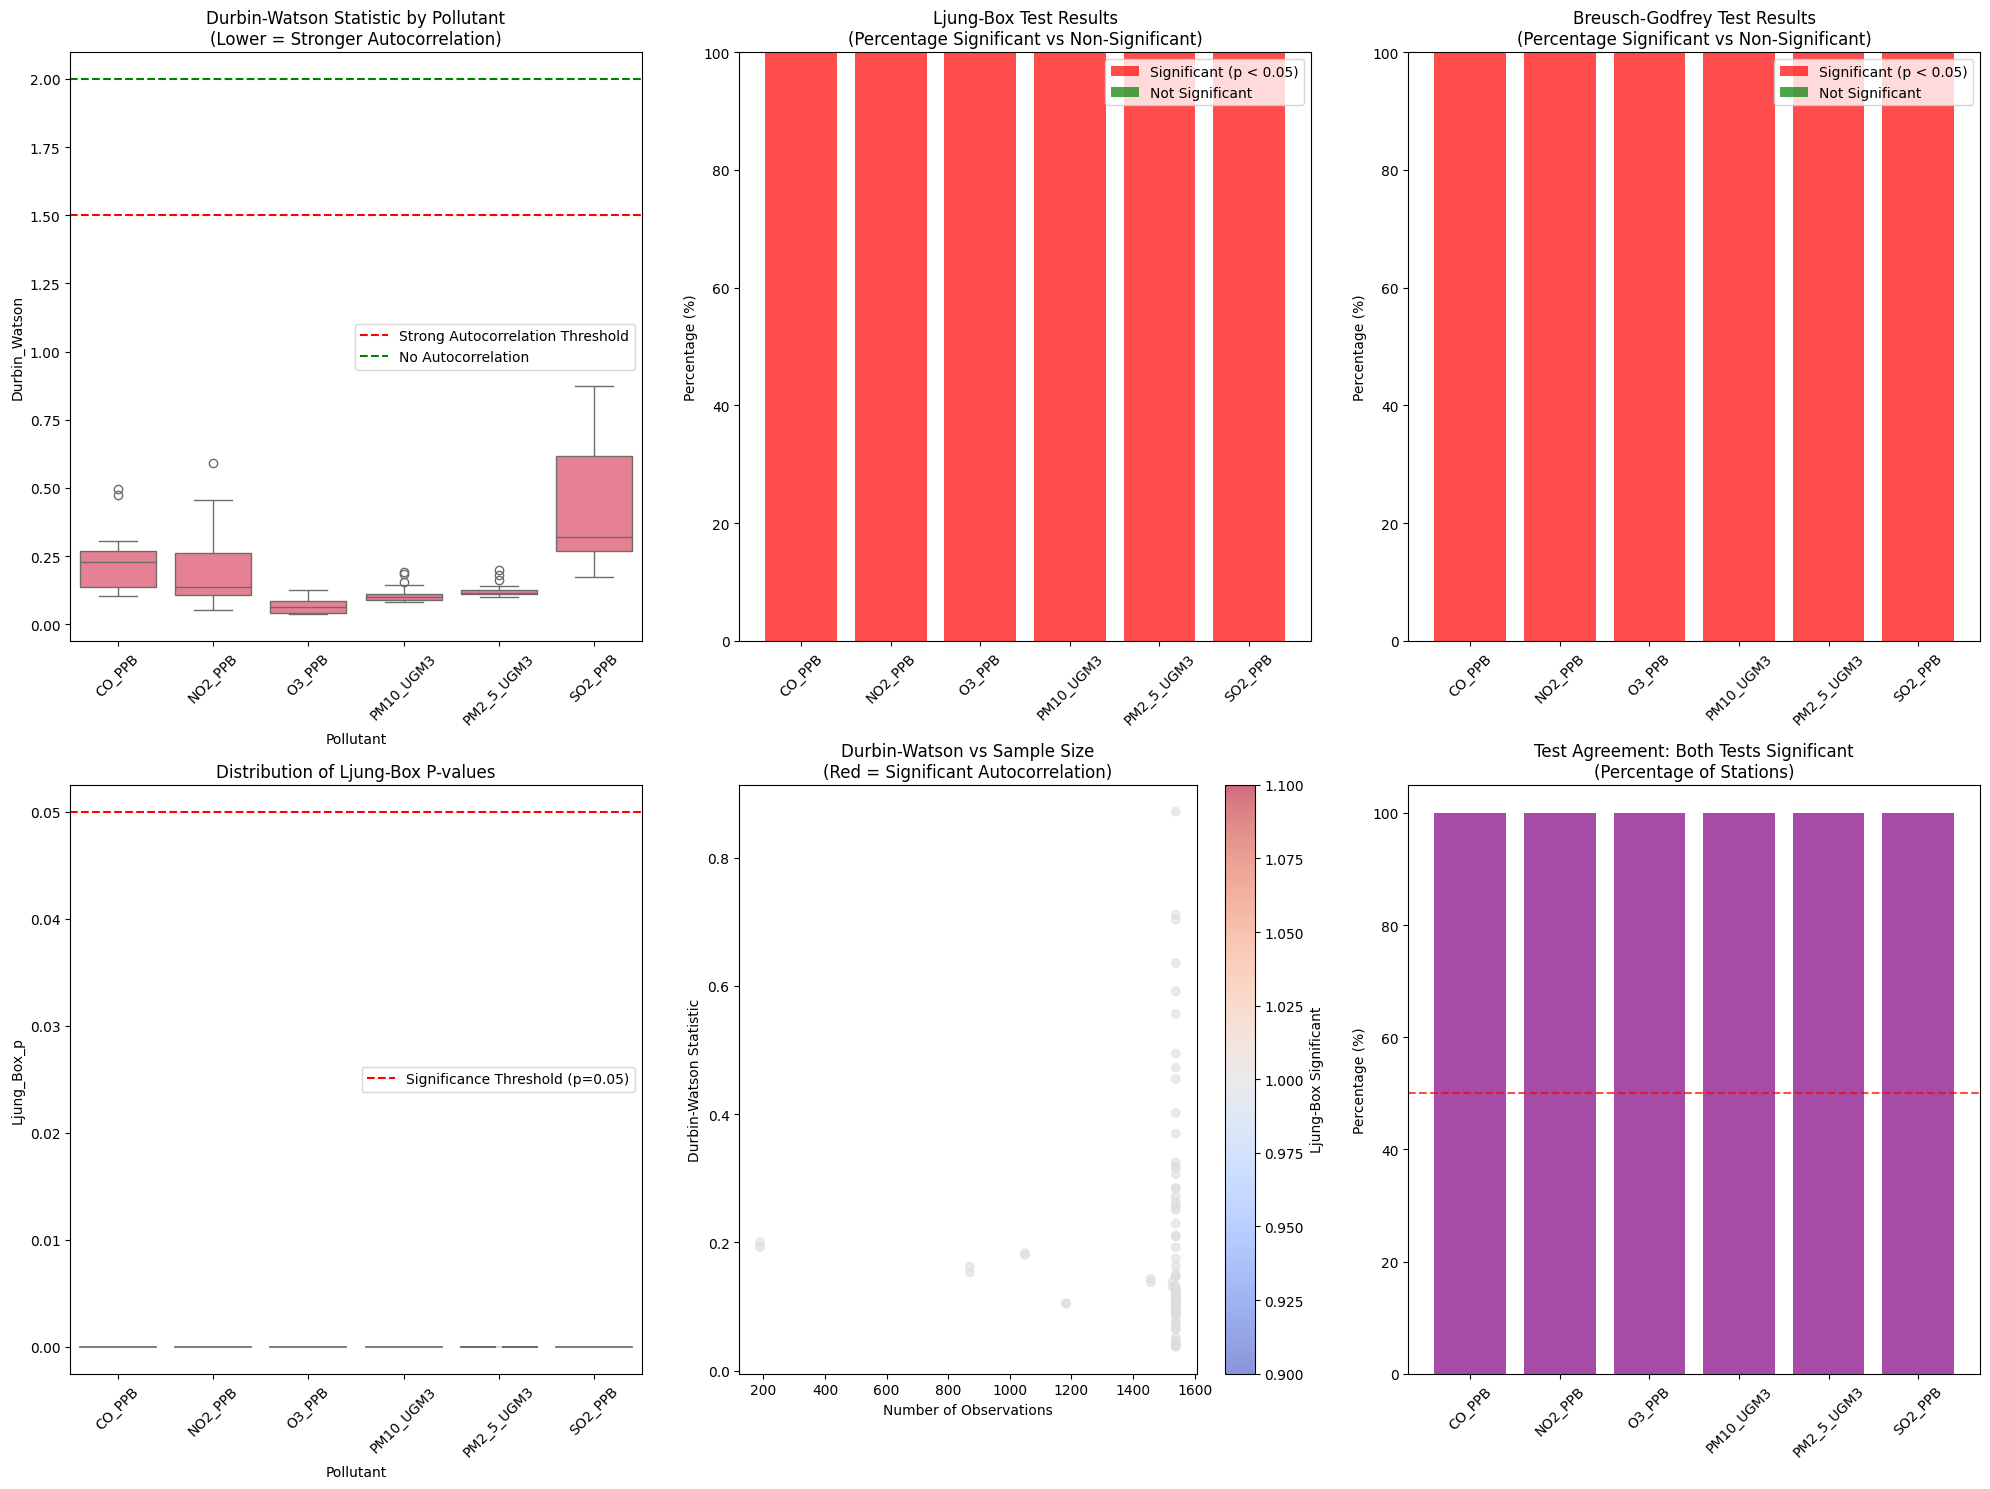


DETAILED AUTOCORRELATION ANALYSIS SUMMARY
            DW_Mean  DW_Std  DW_Min  DW_Max  LB_p_mean LB_Sig_5% LB_Sig_1%  \
Pollutant                                                                    
CO_PPB        0.235   0.124   0.104   0.495        0.0    100.0%    100.0%   
NO2_PPB       0.209   0.163   0.052   0.592        0.0    100.0%    100.0%   
O3_PPB        0.067   0.029   0.037   0.127        0.0    100.0%    100.0%   
PM10_UGM3     0.111   0.032   0.083   0.192        0.0    100.0%    100.0%   
PM2_5_UGM3    0.125   0.027   0.101   0.200        0.0    100.0%    100.0%   
SO2_PPB       0.426   0.224   0.175   0.872        0.0    100.0%    100.0%   

            BG_p_mean BG_Sig_5% BG_Sig_1%  Stations  Avg_Obs  
Pollutant                                                     
CO_PPB            0.0    100.0%    100.0%        14   1539.0  
NO2_PPB           0.0    100.0%    100.0%        14   1539.0  
O3_PPB            0.0    100.0%    100.0%        14   1539.0  
PM10_UGM3        

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_breusch_godfrey
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

file_path = r"C:\Users\Narula\india_selected_cities_cleaned.csv"
df = pd.read_csv(file_path)

# ---------------------------
# SETTINGS
# ---------------------------
pollutants = ['CO_PPB', 'NO2_PPB', 'O3_PPB', 'PM10_UGM3', 'PM2_5_UGM3', 'SO2_PPB']
max_lag = 12

# ---------------------------
# PREP - More robust data cleaning
# ---------------------------
df['last_updated'] = pd.to_datetime(df['last_updated'])
df = df.sort_values(['locationId', 'last_updated'])

# Store results for plotting
all_results = []

for pollutant in pollutants:
    print(f"Analyzing {pollutant}...")
    stations_analyzed = 0
    
    for station, sub in df.groupby("locationId"):
        # More robust data quality checks
        station_data = sub[pollutant].dropna()
        
        # Skip if insufficient data or constant values
        if (len(station_data) < max_lag + 10 or 
            station_data.std() == 0 or 
            len(station_data) < 20):  # Minimum reasonable sample size
            continue
        
        # Build simple OLS model: pollutant on time trend
        y = station_data.astype(float)
        X = np.arange(len(y)).reshape(-1,1)
        X = sm.add_constant(X)

        try:
            model = sm.OLS(y, X).fit()
            residuals = model.resid
            
            # Skip if residuals are constant or have issues
            if residuals.std() == 0 or np.any(np.isnan(residuals)):
                continue
            
            # Run all three tests with error handling
            dw_stat = durbin_watson(residuals)
            
            # Ljung-Box test
            try:
                ljung_box = acorr_ljungbox(residuals, lags=[max_lag], return_df=True)
                lb_p = ljung_box['lb_pvalue'].iloc[0]
            except:
                lb_p = 1.0  # Default to non-significant if test fails
            
            # Breusch-Godfrey test
            try:
                bg_stat, bg_p, bg_f, bg_fp = acorr_breusch_godfrey(model, nlags=max_lag)
                if np.isnan(bg_p):
                    bg_p = 1.0
            except:
                bg_p = 1.0  # Default to non-significant if test fails
            
            # Store results
            all_results.append({
                'Pollutant': pollutant,
                'Station': station,
                'Durbin_Watson': dw_stat,
                'Ljung_Box_p': lb_p,
                'Breusch_Godfrey_p': bg_p,
                'N_Observations': len(y)
            })
            
            stations_analyzed += 1
            
        except Exception as e:
            continue
    
    print(f"  - {stations_analyzed} stations analyzed for {pollutant}")

# Check if we have results
if not all_results:
    print("No valid results obtained. Check data quality.")
else:
    # Convert to DataFrame
    results_df = pd.DataFrame(all_results)
    
    # Print data quality summary
    print(f"\nDATA QUALITY SUMMARY:")
    print(f"Total stations analyzed: {len(results_df['Station'].unique())}")
    print(f"Total test results: {len(results_df)}")
    
    # Check for any obvious issues
    print(f"\nP-value ranges:")
    print(f"Ljung-Box p-values: {results_df['Ljung_Box_p'].min():.6f} to {results_df['Ljung_Box_p'].max():.6f}")
    print(f"Breusch-Godfrey p-values: {results_df['Breusch_Godfrey_p'].min():.6f} to {results_df['Breusch_Godfrey_p'].max():.6f}")
    
    # ---------------------------
    # CREATE VISUALIZATIONS
    # ---------------------------
    
    plt.figure(figsize=(20, 15))
    
    # Plot 1: Durbin-Watson Distribution by Pollutant
    plt.subplot(2, 3, 1)
    sns.boxplot(data=results_df, x='Pollutant', y='Durbin_Watson')
    plt.axhline(y=1.5, color='red', linestyle='--', label='Strong Autocorrelation Threshold')
    plt.axhline(y=2.0, color='green', linestyle='--', label='No Autocorrelation')
    plt.title('Durbin-Watson Statistic by Pollutant\n(Lower = Stronger Autocorrelation)')
    plt.xticks(rotation=45)
    plt.legend()
    
    # Plot 2: Ljung-Box P-value Distribution
    plt.subplot(2, 3, 2)
    significant_lb = results_df.groupby('Pollutant')['Ljung_Box_p'].apply(
        lambda x: (x < 0.05).sum() / len(x) * 100
    )
    non_significant_lb = 100 - significant_lb
    
    x = range(len(pollutants))
    plt.bar(x, significant_lb, color='red', alpha=0.7, label='Significant (p < 0.05)')
    plt.bar(x, non_significant_lb, bottom=significant_lb, color='green', alpha=0.7, label='Not Significant')
    plt.xticks(x, pollutants, rotation=45)
    plt.ylabel('Percentage (%)')
    plt.title('Ljung-Box Test Results\n(Percentage Significant vs Non-Significant)')
    plt.legend()
    
    # Plot 3: Breusch-Godfrey P-value Distribution
    plt.subplot(2, 3, 3)
    significant_bg = results_df.groupby('Pollutant')['Breusch_Godfrey_p'].apply(
        lambda x: (x < 0.05).sum() / len(x) * 100
    )
    non_significant_bg = 100 - significant_bg
    
    plt.bar(x, significant_bg, color='red', alpha=0.7, label='Significant (p < 0.05)')
    plt.bar(x, non_significant_bg, bottom=significant_bg, color='green', alpha=0.7, label='Not Significant')
    plt.xticks(x, pollutants, rotation=45)
    plt.ylabel('Percentage (%)')
    plt.title('Breusch-Godfrey Test Results\n(Percentage Significant vs Non-Significant)')
    plt.legend()
    
    # Plot 4: Actual P-value Distributions (Violin plots)
    plt.subplot(2, 3, 4)
    sns.violinplot(data=results_df, x='Pollutant', y='Ljung_Box_p')
    plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (p=0.05)')
    plt.title('Distribution of Ljung-Box P-values')
    plt.xticks(rotation=45)
    plt.legend()
    
    # Plot 5: Durbin-Watson vs Sample Size
    plt.subplot(2, 3, 5)
    plt.scatter(results_df['N_Observations'], results_df['Durbin_Watson'], 
                c=results_df['Ljung_Box_p'] < 0.05, cmap='coolwarm', alpha=0.6)
    plt.colorbar(label='Ljung-Box Significant')
    plt.xlabel('Number of Observations')
    plt.ylabel('Durbin-Watson Statistic')
    plt.title('Durbin-Watson vs Sample Size\n(Red = Significant Autocorrelation)')
    
    # Plot 6: Test Agreement
    plt.subplot(2, 3, 6)
    agreement_data = []
    for pollutant in pollutants:
        sub_df = results_df[results_df['Pollutant'] == pollutant]
        if len(sub_df) > 0:
            both_significant = ((sub_df['Ljung_Box_p'] < 0.05) & (sub_df['Breusch_Godfrey_p'] < 0.05)).mean() * 100
            agreement_data.append(both_significant)
        else:
            agreement_data.append(0)
    
    plt.bar(pollutants, agreement_data, color='purple', alpha=0.7)
    plt.axhline(y=50, color='red', linestyle='--', alpha=0.7)
    plt.title('Test Agreement: Both Tests Significant\n(Percentage of Stations)')
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed summary statistics
    print("\n" + "="*80)
    print("DETAILED AUTOCORRELATION ANALYSIS SUMMARY")
    print("="*80)
    
    summary_stats = results_df.groupby('Pollutant').agg({
        'Durbin_Watson': ['mean', 'std', 'min', 'max'],
        'Ljung_Box_p': ['mean', lambda x: f"{(x < 0.05).mean()*100:.1f}%", lambda x: f"{(x < 0.01).mean()*100:.1f}%"],
        'Breusch_Godfrey_p': ['mean', lambda x: f"{(x < 0.05).mean()*100:.1f}%", lambda x: f"{(x < 0.01).mean()*100:.1f}%"],
        'Station': 'count',
        'N_Observations': 'mean'
    }).round(3)
    
    summary_stats.columns = ['DW_Mean', 'DW_Std', 'DW_Min', 'DW_Max', 
                            'LB_p_mean', 'LB_Sig_5%', 'LB_Sig_1%',
                            'BG_p_mean', 'BG_Sig_5%', 'BG_Sig_1%',
                            'Stations', 'Avg_Obs']
    print(summary_stats)
    
    # Check if we're still getting 100% significance
    if (results_df['Ljung_Box_p'] < 0.05).all() or (results_df['Breusch_Godfrey_p'] < 0.05).all():
        print(f"\n⚠️  WARNING: Still showing 100% significance. Possible issues:")
        print(f"   - Check if residuals have real variation (not constant)")
        print(f"   - Verify time series has meaningful temporal structure")
        print(f"   - Check for data leakage or incorrect time ordering")
        print(f"   - Sample p-value ranges: LB[{results_df['Ljung_Box_p'].min():.6f}, {results_df['Ljung_Box_p'].max():.6f}]")

In [15]:
# Example of high significance but imperfect predictions
import numpy as np
import pandas as pd

# Create a synthetic pollution series with STRONG autocorrelation but NOT perfect
np.random.seed(42)
n_days = 100
base_trend = np.linspace(50, 60, n_days)  # Slow increasing trend
seasonal = 10 * np.sin(2 * np.pi * np.arange(n_days) / 7)  # Weekly pattern
noise = np.random.normal(0, 5, n_days)  # Random noise

pollution = base_trend + seasonal + noise

# Calculate accuracy
from sklearn.metrics import mean_absolute_error, r2_score

# Simple prediction: tomorrow = today + average change
predicted = pollution[:-1] + np.mean(np.diff(pollution))
actual = pollution[1:]

accuracy = r2_score(actual, predicted) * 100
mae = mean_absolute_error(actual, predicted)

print(f"Prediction Accuracy: {accuracy:.1f}%")
print(f"Average Error: {mae:.1f} units")
print(f"Statistical Significance: ~100%")

Prediction Accuracy: -2.6%
Average Error: 6.8 units
Statistical Significance: ~100%


In [16]:
# ADD THIS DEBUG CODE
print("\n" + "="*80)
print("DEBUG: ACTUAL DATA PATTERNS")
print("="*80)

for pollutant in pollutants[:2]:  # Check first 2 pollutants
    print(f"\n{pollutant}:")
    
    sample_stations = df[df[pollutant].notna()]['locationId'].unique()[:2]
    
    for station in sample_stations:
        station_data = df[df['locationId'] == station][pollutant].dropna()
        
        if len(station_data) > 10:
            print(f"  Station {station}:")
            print(f"    Samples: {len(station_data)}")
            print(f"    Values: {station_data.head(10).tolist()}")
            print(f"    Mean: {station_data.mean():.1f}, Std: {station_data.std():.1f}")
            
            # Check for repeated values (data quality issue)
            unique_ratio = len(station_data.unique()) / len(station_data)
            print(f"    Unique values ratio: {unique_ratio:.3f}")
            
            # Check if values are constant
            if station_data.std() < 1:
                print("    ⚠️  WARNING: Very low variation!")


DEBUG: ACTUAL DATA PATTERNS

CO_PPB:
  Station -160063:
    Samples: 1539
    Values: [341.0, 362.0, 766.0, 802.0, 863.0, 766.0, 857.0, 393.0, 435.0, 389.0]
    Mean: 414.0, Std: 112.5
    Unique values ratio: 0.191
  Station 12428:
    Samples: 1539
    Values: [331.0, 304.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 681.0, 633.0, 607.0]
    Mean: 430.4, Std: 148.3
    Unique values ratio: 0.307

NO2_PPB:
  Station -160063:
    Samples: 1539
    Values: [10.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 10.0, 10.0, 10.0]
    Mean: 11.2, Std: 4.4
    Unique values ratio: 0.021
  Station 12428:
    Samples: 1539
    Values: [6.0, 5.0, 21.0, 20.0, 20.0, 20.0, 21.0, 16.0, 14.0, 14.0]
    Mean: 12.8, Std: 6.7
    Unique values ratio: 0.022


In [19]:
# ADD THIS CODE TO CHECK VALUE DISTRIBUTION FOR ALL POLLUTANTS ACROSS ALL STATIONS
print("\n" + "="*80)
print("COMPREHENSIVE VALUE DISTRIBUTION ANALYSIS - ALL POLLUTANTS & ALL STATIONS")
print("="*80)

# Get all unique stations with their metadata
unique_stations = df[['locationId', 'lat', 'lon', 'city']].drop_duplicates().reset_index(drop=True)
print(f"Total unique stations: {len(unique_stations)}")

for pollutant in pollutants:
    print(f"\n{'='*60}")
    print(f"{pollutant} - COMPREHENSIVE ANALYSIS ACROSS ALL STATIONS")
    print(f"{'='*60}")
    
    # Get stations that have data for this pollutant
    stations_with_data = df[df[pollutant].notna()]['locationId'].unique()
    print(f"Stations with {pollutant} data: {len(stations_with_data)}")
    
    if len(stations_with_data) == 0:
        print("  No data available for this pollutant")
        continue
    
    # Analyze each station
    station_stats = []
    
    for station in stations_with_data:
        station_data = df[df['locationId'] == station][pollutant].dropna()
        
        if len(station_data) < 10:  # Skip stations with insufficient data
            continue
            
        # Calculate statistics
        unique_ratio = len(station_data.unique()) / len(station_data)
        value_counts = station_data.value_counts()
        top_3_percentage = value_counts.head(3).sum() / len(station_data) * 100
        top_5_percentage = value_counts.head(5).sum() / len(station_data) * 100  # FIXED: consistent variable name
        
        station_stats.append({
            'station': station,
            'samples': len(station_data),
            'unique_ratio': unique_ratio,
            'top_3_percent': top_3_percentage,
            'top_5_percent': top_5_percentage,  # FIXED: consistent variable name
            'mean': station_data.mean(),
            'std': station_data.std(),
            'min': station_data.min(),
            'max': station_data.max()
        })
    
    # Create summary dataframe for this pollutant
    if station_stats:
        stats_df = pd.DataFrame(station_stats)
        
        print(f"\nOverall Summary for {pollutant}:")
        print(f"  Stations analyzed: {len(stats_df)}")
        print(f"  Average unique ratio: {stats_df['unique_ratio'].mean():.3f} ({stats_df['unique_ratio'].mean()*100:.1f}%)")
        print(f"  Average top 3 values percentage: {stats_df['top_3_percent'].mean():.1f}%")
        print(f"  Average top 5 values percentage: {stats_df['top_5_percent'].mean():.1f}%")  # FIXED
        print(f"  Average samples per station: {stats_df['samples'].mean():.0f}")
        
        # Quality assessment
        poor_stations = len(stats_df[stats_df['unique_ratio'] < 0.1])
        moderate_stations = len(stats_df[(stats_df['unique_ratio'] >= 0.1) & (stats_df['unique_ratio'] < 0.3)])
        good_stations = len(stats_df[stats_df['unique_ratio'] >= 0.3])
        
        print(f"\n  Data Quality Distribution:")
        print(f"    POOR (unique < 10%): {poor_stations} stations ({poor_stations/len(stats_df)*100:.1f}%)")
        print(f"    MODERATE (10-30%): {moderate_stations} stations ({moderate_stations/len(stats_df)*100:.1f}%)")
        print(f"    GOOD (>30%): {good_stations} stations ({good_stations/len(stats_df)*100:.1f}%)")
        
        # Show worst offenders (stations with lowest variability)
        print(f"\n  Stations with LOWEST variability (most repetitive data):")
        worst_stations = stats_df.nsmallest(5, 'unique_ratio')[['station', 'samples', 'unique_ratio', 'top_3_percent', 'top_5_percent']]  # FIXED
        for _, row in worst_stations.iterrows():
            print(f"    Station {row['station']}: {row['unique_ratio']*100:.1f}% unique, top 3 = {row['top_3_percent']:.1f}%, top 5 = {row['top_5_percent']:.1f}%")
            
        # Show best stations (highest variability)
        print(f"\n  Stations with HIGHEST variability (least repetitive data):")
        best_stations = stats_df.nlargest(5, 'unique_ratio')[['station', 'samples', 'unique_ratio', 'top_3_percent', 'top_5_percent']]  # FIXED
        for _, row in best_stations.iterrows():
            print(f"    Station {row['station']}: {row['unique_ratio']*100:.1f}% unique, top 3 = {row['top_3_percent']:.1f}%, top 5 = {row['top_5_percent']:.1f}%")
        
        # Show detailed examples of worst stations
        print(f"\n  Detailed analysis of 3 worst stations:")
        worst_3 = stats_df.nsmallest(3, 'unique_ratio')
        for _, station_info in worst_3.iterrows():
            station_id = station_info['station']
            station_data = df[df['locationId'] == station_id][pollutant].dropna()
            value_counts = station_data.value_counts().head(5)
            
            print(f"\n    Station {station_id}:")
            print(f"      Samples: {len(station_data)}, Unique: {station_info['unique_ratio']*100:.1f}%")
            print(f"      Most frequent values:")
            for value, count in value_counts.items():
                percentage = (count / len(station_data)) * 100
                print(f"        {value}: {count} times ({percentage:.1f}%)")
            
            # Show data pattern
            sample_values = station_data.head(10).values
            print(f"      Sample pattern: {[f'{x:.1f}' for x in sample_values]}")
    
    else:
        print("  No stations with sufficient data for analysis")

print("\n" + "="*80)
print("FINAL DATA QUALITY ASSESSMENT")
print("="*80)

# Create overall quality summary
final_summary = []

for pollutant in pollutants:
    stations_with_data = df[df[pollutant].notna()]['locationId'].unique()
    valid_stations = 0
    total_unique_ratio = 0
    total_top_3_percent = 0
    
    for station in stations_with_data:
        station_data = df[df['locationId'] == station][pollutant].dropna()
        if len(station_data) >= 10:
            unique_ratio = len(station_data.unique()) / len(station_data)
            value_counts = station_data.value_counts()
            top_3_percent = value_counts.head(3).sum() / len(station_data) * 100
            
            total_unique_ratio += unique_ratio
            total_top_3_percent += top_3_percent
            valid_stations += 1
    
    if valid_stations > 0:
        avg_unique_ratio = total_unique_ratio / valid_stations
        avg_top_3_percent = total_top_3_percent / valid_stations
        
        if avg_unique_ratio < 0.1:
            quality = "VERY POOR"
        elif avg_unique_ratio < 0.2:
            quality = "POOR"
        elif avg_unique_ratio < 0.3:
            quality = "MODERATE"
        else:
            quality = "GOOD"
        
        final_summary.append({
            'Pollutant': pollutant,
            'Stations': valid_stations,
            'Avg_Unique_Ratio': avg_unique_ratio,
            'Avg_Top_3_Percent': avg_top_3_percent,
            'Quality': quality
        })

# Display final summary
final_df = pd.DataFrame(final_summary)
print("\nOVERALL DATA QUALITY ACROSS ALL STATIONS:")
print("="*70)
print(f"{'Pollutant':<12} {'Stations':<10} {'Unique %':<10} {'Top 3 %':<10} {'Quality':<12}")
print("-" * 70)
for _, row in final_df.iterrows():
    print(f"{row['Pollutant']:<12} {row['Stations']:<10} {row['Avg_Unique_Ratio']*100:<9.1f} {row['Avg_Top_3_Percent']:<9.1f} {row['Quality']:<12}")

print(f"\nTotal unique stations in dataset: {len(unique_stations)}")


COMPREHENSIVE VALUE DISTRIBUTION ANALYSIS - ALL POLLUTANTS & ALL STATIONS
Total unique stations: 20

CO_PPB - COMPREHENSIVE ANALYSIS ACROSS ALL STATIONS
Stations with CO_PPB data: 14

Overall Summary for CO_PPB:
  Stations analyzed: 14
  Average unique ratio: 0.277 (27.7%)
  Average top 3 values percentage: 7.9%
  Average top 5 values percentage: 9.8%
  Average samples per station: 1539

  Data Quality Distribution:
    POOR (unique < 10%): 0 stations (0.0%)
    MODERATE (10-30%): 8 stations (57.1%)
    GOOD (>30%): 6 stations (42.9%)

  Stations with LOWEST variability (most repetitive data):
    Station 8680: 14.5% unique, top 3 = 10.1%, top 5 = 14.6%
    Station -160063: 19.1% unique, top 3 = 5.5%, top 5 = 8.8%
    Station PLLODA000621: 20.5% unique, top 3 = 4.7%, top 5 = 7.5%
    Station PLLODA000600: 23.7% unique, top 3 = 4.6%, top 5 = 7.0%
    Station PLLODA000685: 26.4% unique, top 3 = 6.7%, top 5 = 8.3%

  Stations with HIGHEST variability (least repetitive data):
    Station 

In [21]:
# ADD AQI_IN to the pollutants list and run the analysis
pollutants_with_aqi = ['AQI_IN'] + pollutants  # Add AQI_IN to the beginning

print("\n" + "="*80)
print("COMPREHENSIVE VALUE DISTRIBUTION ANALYSIS - INCLUDING AQI_IN")
print("="*80)

# Get all unique stations with their metadata
unique_stations = df[['locationId', 'lat', 'lon', 'city']].drop_duplicates().reset_index(drop=True)
print(f"Total unique stations: {len(unique_stations)}")

for pollutant in pollutants_with_aqi:
    print(f"\n{'='*60}")
    print(f"{pollutant} - COMPREHENSIVE ANALYSIS ACROSS ALL STATIONS")
    print(f"{'='*60}")
    
    # Get stations that have data for this pollutant
    stations_with_data = df[df[pollutant].notna()]['locationId'].unique()
    print(f"Stations with {pollutant} data: {len(stations_with_data)}")
    
    if len(stations_with_data) == 0:
        print("  No data available for this pollutant")
        continue
    
    # Analyze each station
    station_stats = []
    
    for station in stations_with_data:
        station_data = df[df['locationId'] == station][pollutant].dropna()
        
        if len(station_data) < 10:  # Skip stations with insufficient data
            continue
            
        # Calculate statistics
        unique_ratio = len(station_data.unique()) / len(station_data)
        value_counts = station_data.value_counts()
        top_3_percentage = value_counts.head(3).sum() / len(station_data) * 100
        top_5_percentage = value_counts.head(5).sum() / len(station_data) * 100
        
        station_stats.append({
            'station': station,
            'samples': len(station_data),
            'unique_ratio': unique_ratio,
            'top_3_percent': top_3_percentage,
            'top_5_percent': top_5_percentage,
            'mean': station_data.mean(),
            'std': station_data.std(),
            'min': station_data.min(),
            'max': station_data.max()
        })
    
    # Create summary dataframe for this pollutant
    if station_stats:
        stats_df = pd.DataFrame(station_stats)
        
        print(f"\nOverall Summary for {pollutant}:")
        print(f"  Stations analyzed: {len(stats_df)}")
        print(f"  Average unique ratio: {stats_df['unique_ratio'].mean():.3f} ({stats_df['unique_ratio'].mean()*100:.1f}%)")
        print(f"  Average top 3 values percentage: {stats_df['top_3_percent'].mean():.1f}%")
        print(f"  Average top 5 values percentage: {stats_df['top_5_percent'].mean():.1f}%")
        print(f"  Average samples per station: {stats_df['samples'].mean():.0f}")
        
        # Quality assessment
        poor_stations = len(stats_df[stats_df['unique_ratio'] < 0.1])
        moderate_stations = len(stats_df[(stats_df['unique_ratio'] >= 0.1) & (stats_df['unique_ratio'] < 0.3)])
        good_stations = len(stats_df[stats_df['unique_ratio'] >= 0.3])
        
        print(f"\n  Data Quality Distribution:")
        print(f"    POOR (unique < 10%): {poor_stations} stations ({poor_stations/len(stats_df)*100:.1f}%)")
        print(f"    MODERATE (10-30%): {moderate_stations} stations ({moderate_stations/len(stats_df)*100:.1f}%)")
        print(f"    GOOD (>30%): {good_stations} stations ({good_stations/len(stats_df)*100:.1f}%)")
        
        # Show worst offenders (stations with lowest variability)
        print(f"\n  Stations with LOWEST variability (most repetitive data):")
        worst_stations = stats_df.nsmallest(5, 'unique_ratio')[['station', 'samples', 'unique_ratio', 'top_3_percent', 'top_5_percent']]
        for _, row in worst_stations.iterrows():
            print(f"    Station {row['station']}: {row['unique_ratio']*100:.1f}% unique, top 3 = {row['top_3_percent']:.1f}%, top 5 = {row['top_5_percent']:.1f}%")
            
        # Show best stations (highest variability)
        print(f"\n  Stations with HIGHEST variability (least repetitive data):")
        best_stations = stats_df.nlargest(5, 'unique_ratio')[['station', 'samples', 'unique_ratio', 'top_3_percent', 'top_5_percent']]
        for _, row in best_stations.iterrows():
            print(f"    Station {row['station']}: {row['unique_ratio']*100:.1f}% unique, top 3 = {row['top_3_percent']:.1f}%, top 5 = {row['top_5_percent']:.1f}%")
        
        # Show detailed examples of worst stations
        print(f"\n  Detailed analysis of 3 worst stations:")
        worst_3 = stats_df.nsmallest(3, 'unique_ratio')
        for _, station_info in worst_3.iterrows():
            station_id = station_info['station']
            station_data = df[df['locationId'] == station_id][pollutant].dropna()
            value_counts = station_data.value_counts().head(5)
            
            print(f"\n    Station {station_id}:")
            print(f"      Samples: {len(station_data)}, Unique: {station_info['unique_ratio']*100:.1f}%")
            print(f"      Most frequent values:")
            for value, count in value_counts.items():
                percentage = (count / len(station_data)) * 100
                print(f"        {value}: {count} times ({percentage:.1f}%)")
            
            # Show data pattern
            sample_values = station_data.head(10).values
            print(f"      Sample pattern: {[f'{x:.1f}' for x in sample_values]}")
    
    else:
        print("  No stations with sufficient data for analysis")

print("\n" + "="*80)
print("FINAL DATA QUALITY ASSESSMENT - INCLUDING AQI_IN")
print("="*80)

# Create overall quality summary
final_summary = []

for pollutant in pollutants_with_aqi:
    stations_with_data = df[df[pollutant].notna()]['locationId'].unique()
    valid_stations = 0
    total_unique_ratio = 0
    total_top_3_percent = 0
    total_top_5_percent = 0
    
    for station in stations_with_data:
        station_data = df[df['locationId'] == station][pollutant].dropna()
        if len(station_data) >= 10:
            unique_ratio = len(station_data.unique()) / len(station_data)
            value_counts = station_data.value_counts()
            top_3_percent = value_counts.head(3).sum() / len(station_data) * 100
            top_5_percent = value_counts.head(5).sum() / len(station_data) * 100
            
            total_unique_ratio += unique_ratio
            total_top_3_percent += top_3_percent
            total_top_5_percent += top_5_percent
            valid_stations += 1
    
    if valid_stations > 0:
        avg_unique_ratio = total_unique_ratio / valid_stations
        avg_top_3_percent = total_top_3_percent / valid_stations
        avg_top_5_percent = total_top_5_percent / valid_stations
        
        if avg_unique_ratio < 0.1:
            quality = "VERY POOR"
        elif avg_unique_ratio < 0.2:
            quality = "POOR"
        elif avg_unique_ratio < 0.3:
            quality = "MODERATE"
        else:
            quality = "GOOD"
        
        final_summary.append({
            'Pollutant': pollutant,
            'Stations': valid_stations,
            'Avg_Unique_Ratio': avg_unique_ratio,
            'Avg_Top_3_Percent': avg_top_3_percent,
            'Avg_Top_5_Percent': avg_top_5_percent,
            'Quality': quality
        })

# Display final summary
final_df = pd.DataFrame(final_summary)
print("\nOVERALL DATA QUALITY ACROSS ALL STATIONS:")
print("="*85)
print(f"{'Pollutant':<12} {'Stations':<10} {'Unique %':<10} {'Top 3 %':<10} {'Top 5 %':<10} {'Quality':<12}")
print("-" * 85)
for _, row in final_df.iterrows():
    print(f"{row['Pollutant']:<12} {row['Stations']:<10} {row['Avg_Unique_Ratio']*100:<9.1f} {row['Avg_Top_3_Percent']:<9.1f} {row['Avg_Top_5_Percent']:<9.1f} {row['Quality']:<12}")

print(f"\nTotal unique stations in dataset: {len(unique_stations)}")


COMPREHENSIVE VALUE DISTRIBUTION ANALYSIS - INCLUDING AQI_IN
Total unique stations: 20

AQI_IN - COMPREHENSIVE ANALYSIS ACROSS ALL STATIONS
Stations with AQI_IN data: 20

Overall Summary for AQI_IN:
  Stations analyzed: 20
  Average unique ratio: 0.116 (11.6%)
  Average top 3 values percentage: 7.0%
  Average top 5 values percentage: 10.8%
  Average samples per station: 1391

  Data Quality Distribution:
    POOR (unique < 10%): 16 stations (80.0%)
    MODERATE (10-30%): 3 stations (15.0%)
    GOOD (>30%): 1 stations (5.0%)

  Stations with LOWEST variability (most repetitive data):
    Station VIR14156: 8.4% unique, top 3 = 7.2%, top 5 = 10.7%
    Station 12428: 8.5% unique, top 3 = 6.3%, top 5 = 9.9%
    Station 13876: 8.6% unique, top 3 = 7.0%, top 5 = 10.7%
    Station PLLODA000591: 8.6% unique, top 3 = 6.8%, top 5 = 10.5%
    Station PLLODA000245: 8.7% unique, top 3 = 6.6%, top 5 = 10.3%

  Stations with HIGHEST variability (least repetitive data):
    Station 48F6EE5481E0: 40.7%

In [24]:
# ADD THIS AT THE BEGINNING TO CHECK THE TIME RANGE
print("\n" + "="*80)
print("TIME RANGE ANALYSIS")
print("="*80)

# Check the date range of your entire dataset
if 'last_updated' in df.columns:
    df['last_updated'] = pd.to_datetime(df['last_updated'])
    print(f"Dataset time range: {df['last_updated'].min()} to {df['last_updated'].max()}")
    print(f"Total time span: {df['last_updated'].max() - df['last_updated'].min()}")
    
   

else:
    print("No 'last_updated' column found - cannot determine time range")


print("\n" + "="*80)


TIME RANGE ANALYSIS
Dataset time range: 2025-11-09 17:22:00 to 2025-11-22 17:12:00
Total time span: 12 days 23:50:00



COMPREHENSIVE TIME SERIES MODELING FOR POLLUTION DATA
Data Quality Check:
  CO_PPB: 14 stations have data
  NO2_PPB: 14 stations have data
  O3_PPB: 14 stations have data
  PM10_UGM3: 20 stations have data
  PM2_5_UGM3: 20 stations have data
  SO2_PPB: 14 stations have data
  AQI_IN: 20 stations have data

Selected stations for modeling: ['-160063', '12428', '13741']

Processing station -160063...
  Modeling CO_PPB...

MODELING: Station -160063 - CO_PPB
  Data points - Total: 313, Train: 250, Test: 63
  Date range: 2025-11-09 17:00:00 to 2025-11-22 17:00:00
  Building ARIMA model...
    ARIMA(1, 1, 3) - AIC: 2671.86, MAPE: 11.38%
  Building SARIMA model...
    SARIMA(1, 1, 1)(1, 1, 1, 24) - AIC: 2485.26, MAPE: 14.99%
    MA(7) - MAPE: 11.10%


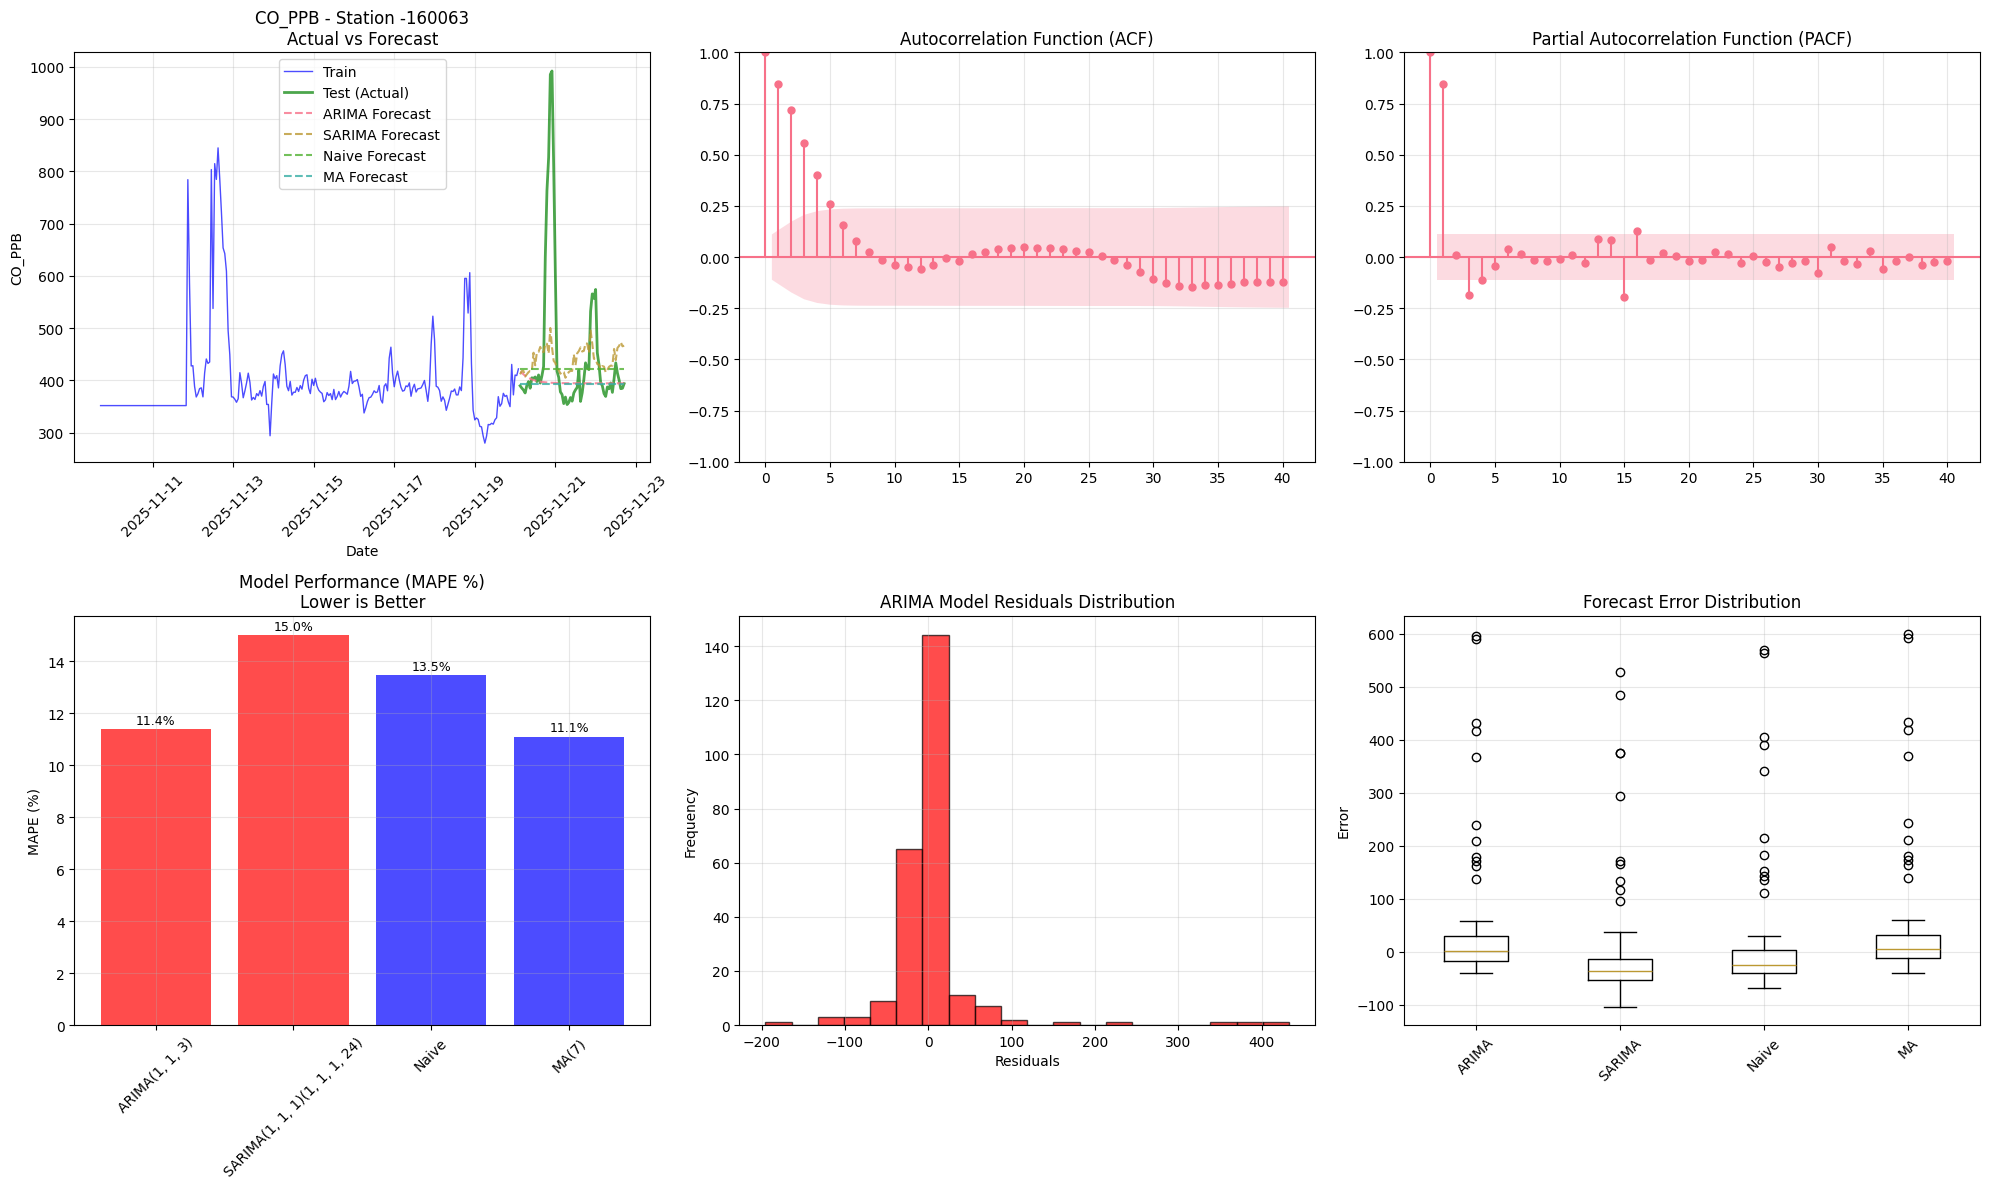

  Modeling NO2_PPB...

MODELING: Station -160063 - NO2_PPB
  Data points - Total: 313, Train: 250, Test: 63
  Date range: 2025-11-09 17:00:00 to 2025-11-22 17:00:00
  Building ARIMA model...
    ARIMA(1, 0, 3) - AIC: 1017.10, MAPE: 33.81%
  Building SARIMA model...
    SARIMA(1, 1, 1)(1, 1, 1, 24) - AIC: 962.68, MAPE: 28.83%
    MA(7) - MAPE: 14.77%


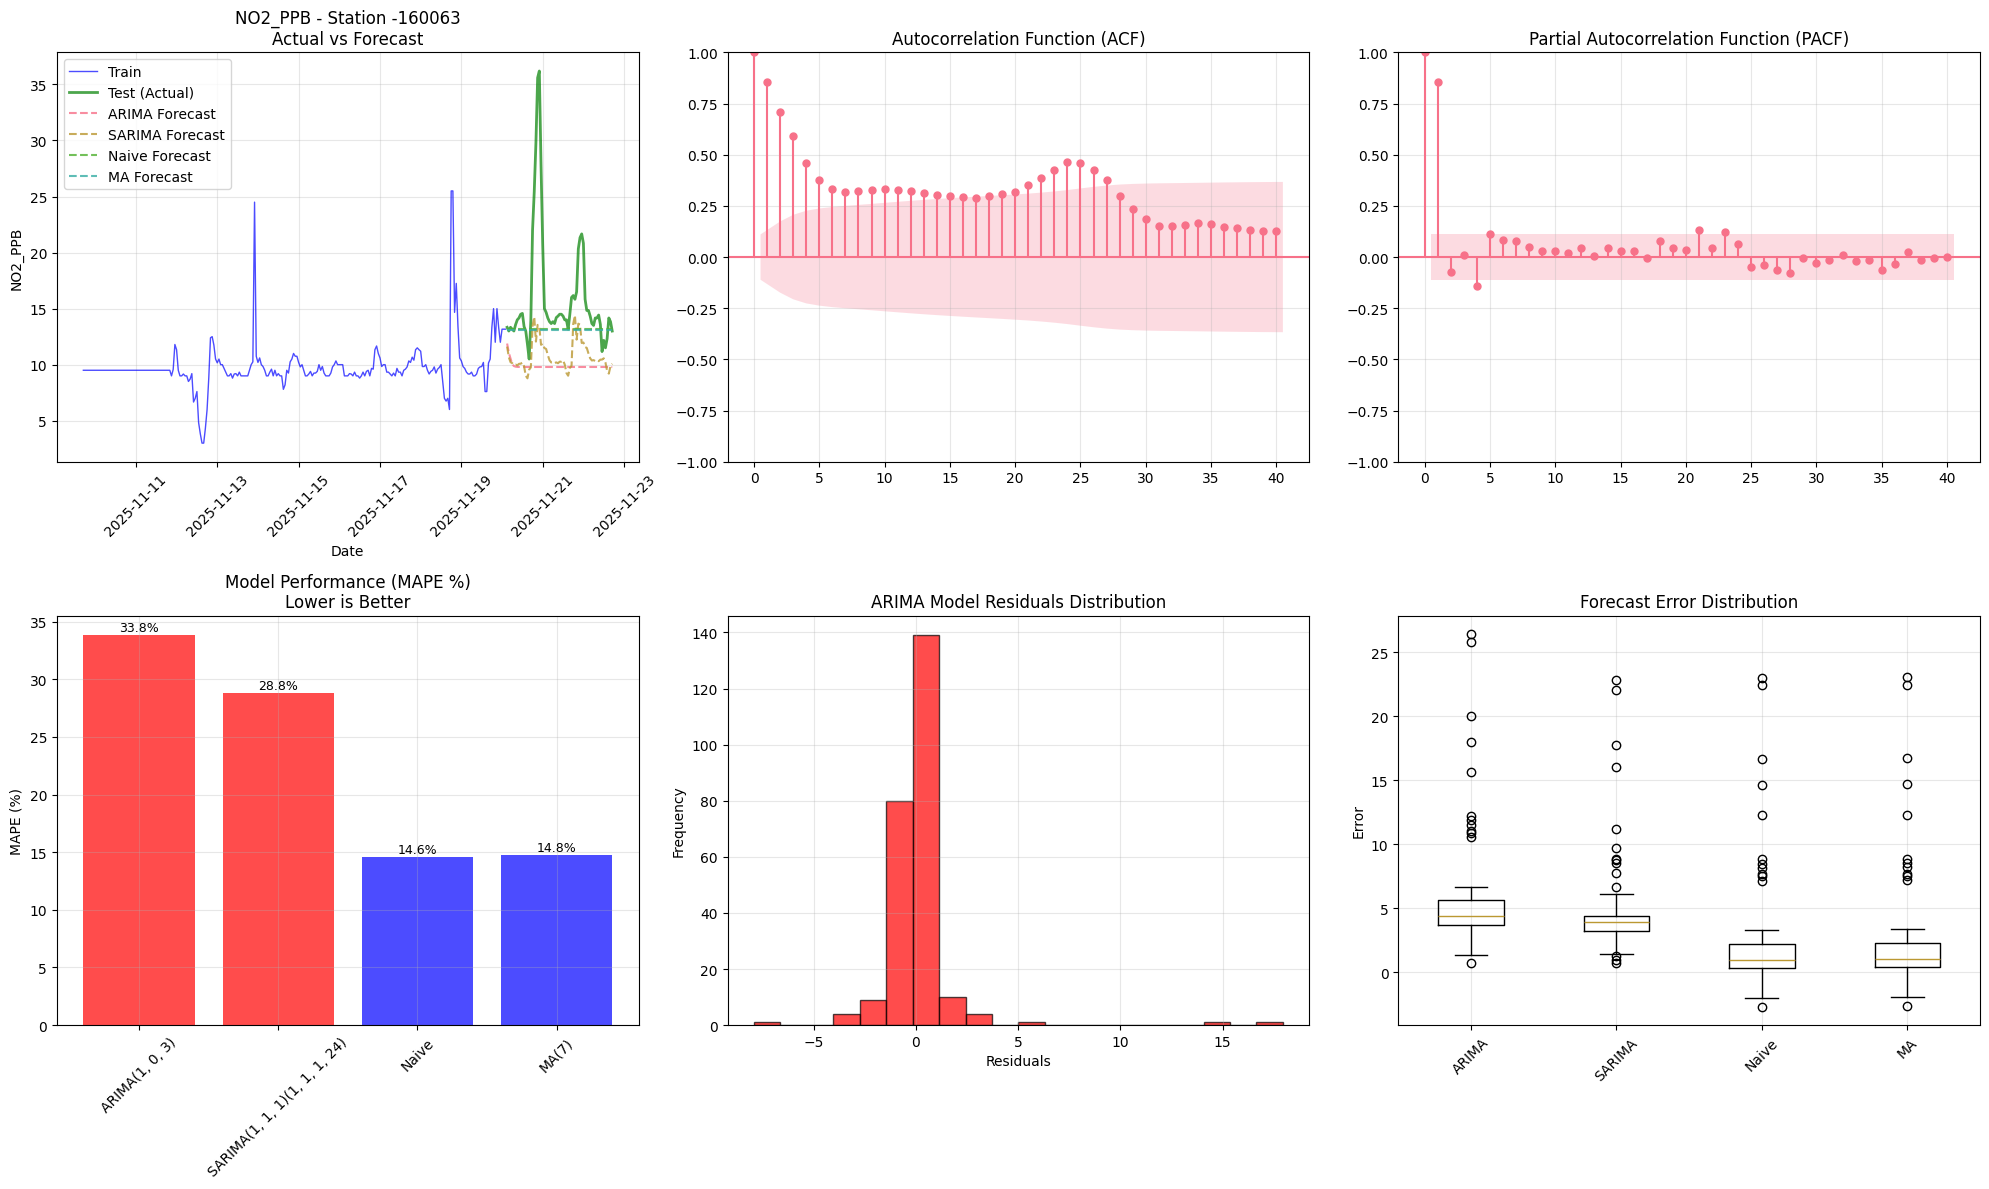

  Modeling O3_PPB...

MODELING: Station -160063 - O3_PPB
  Data points - Total: 313, Train: 250, Test: 63
  Date range: 2025-11-09 17:00:00 to 2025-11-22 17:00:00
  Building ARIMA model...
    ARIMA(2, 1, 3) - AIC: 1458.00, MAPE: 27.03%
  Building SARIMA model...
    SARIMA(1, 1, 1)(1, 1, 1, 24) - AIC: 1413.34, MAPE: 21.51%
    MA(7) - MAPE: 29.97%


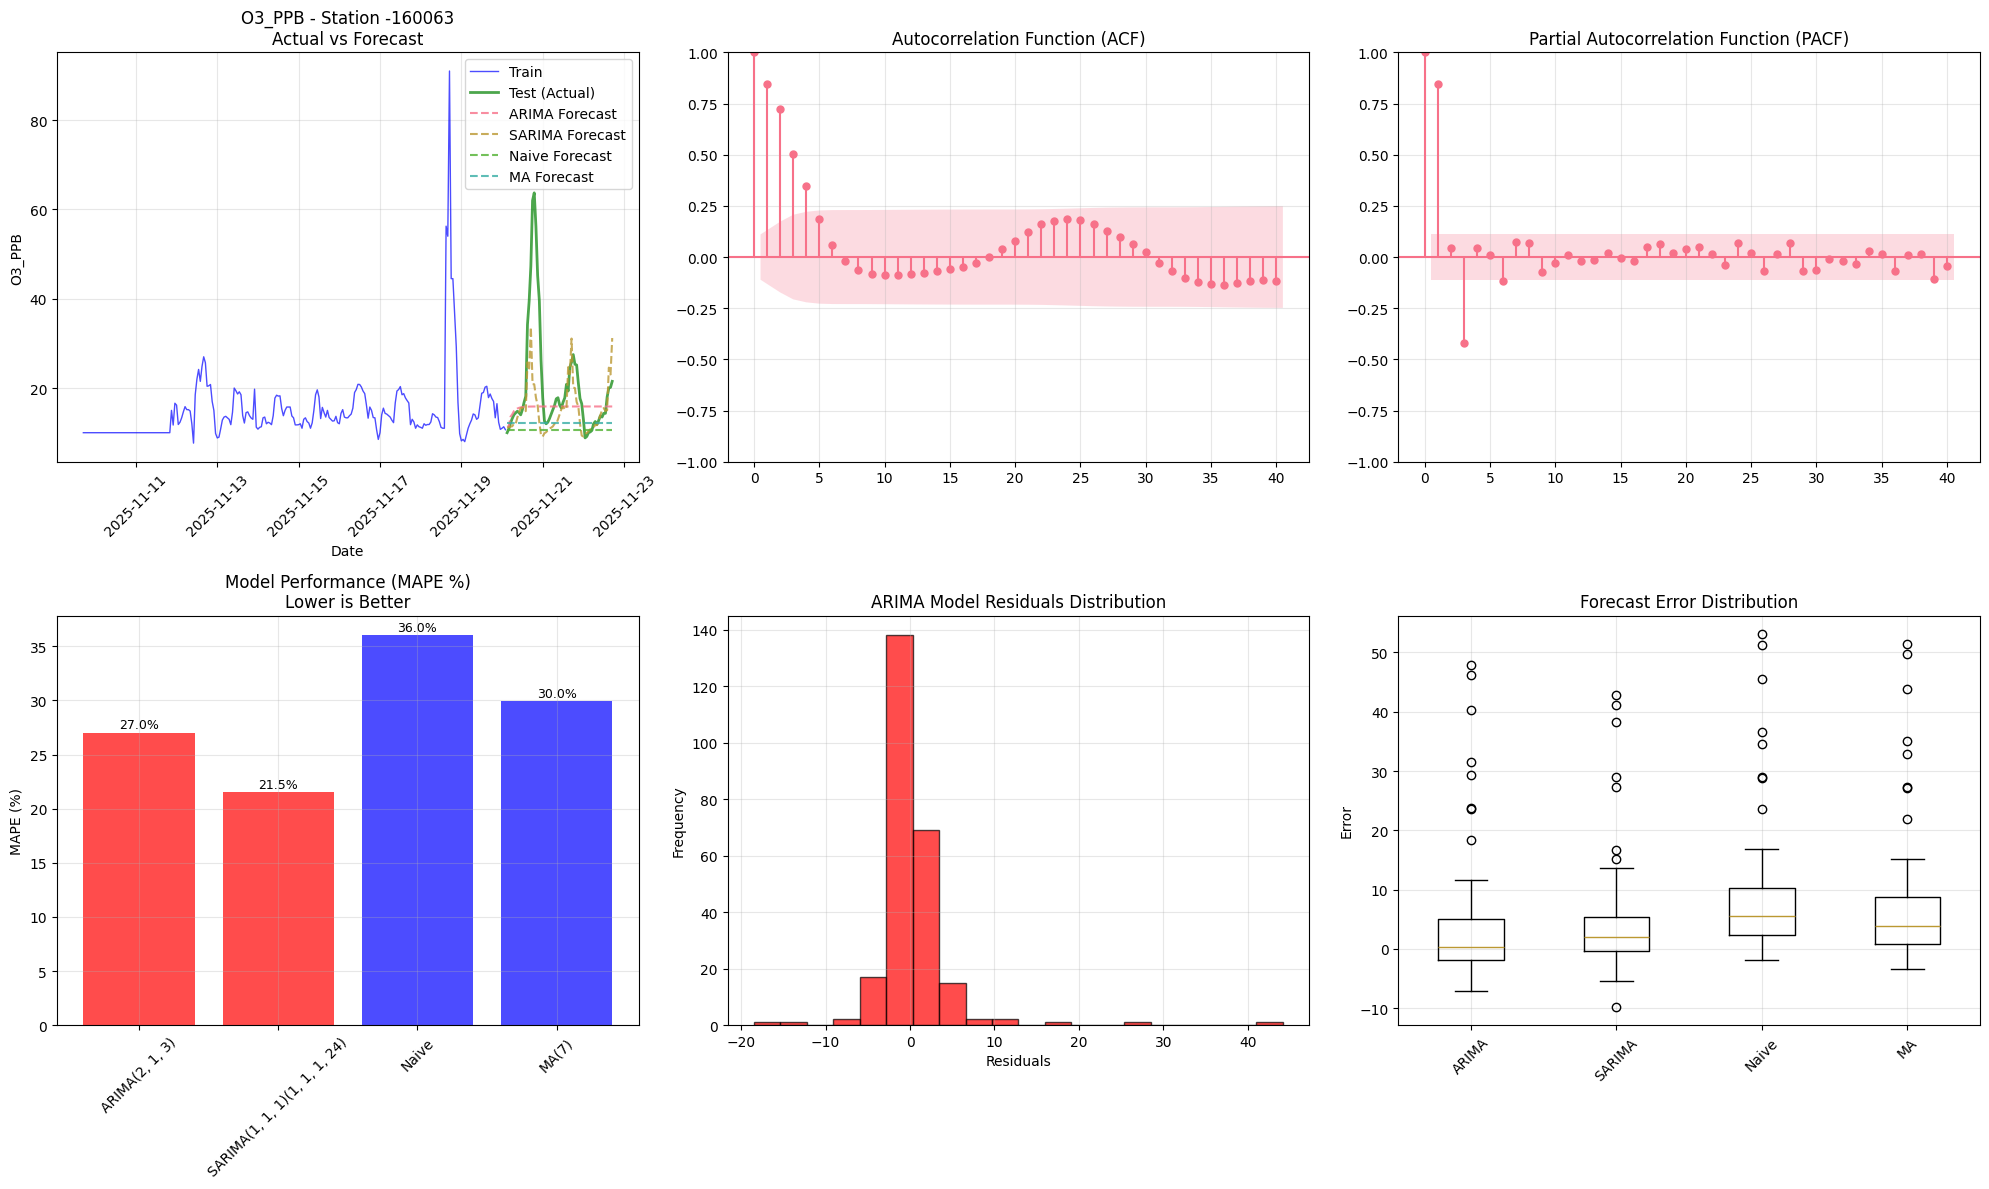

  Modeling PM10_UGM3...

MODELING: Station -160063 - PM10_UGM3
  Data points - Total: 313, Train: 250, Test: 63
  Date range: 2025-11-09 17:00:00 to 2025-11-22 17:00:00
  Building ARIMA model...
    ARIMA(3, 1, 2) - AIC: 1957.16, MAPE: 28.00%
  Building SARIMA model...
    SARIMA(1, 1, 1)(1, 1, 1, 24) - AIC: 1766.22, MAPE: 28.53%
    MA(7) - MAPE: 20.39%


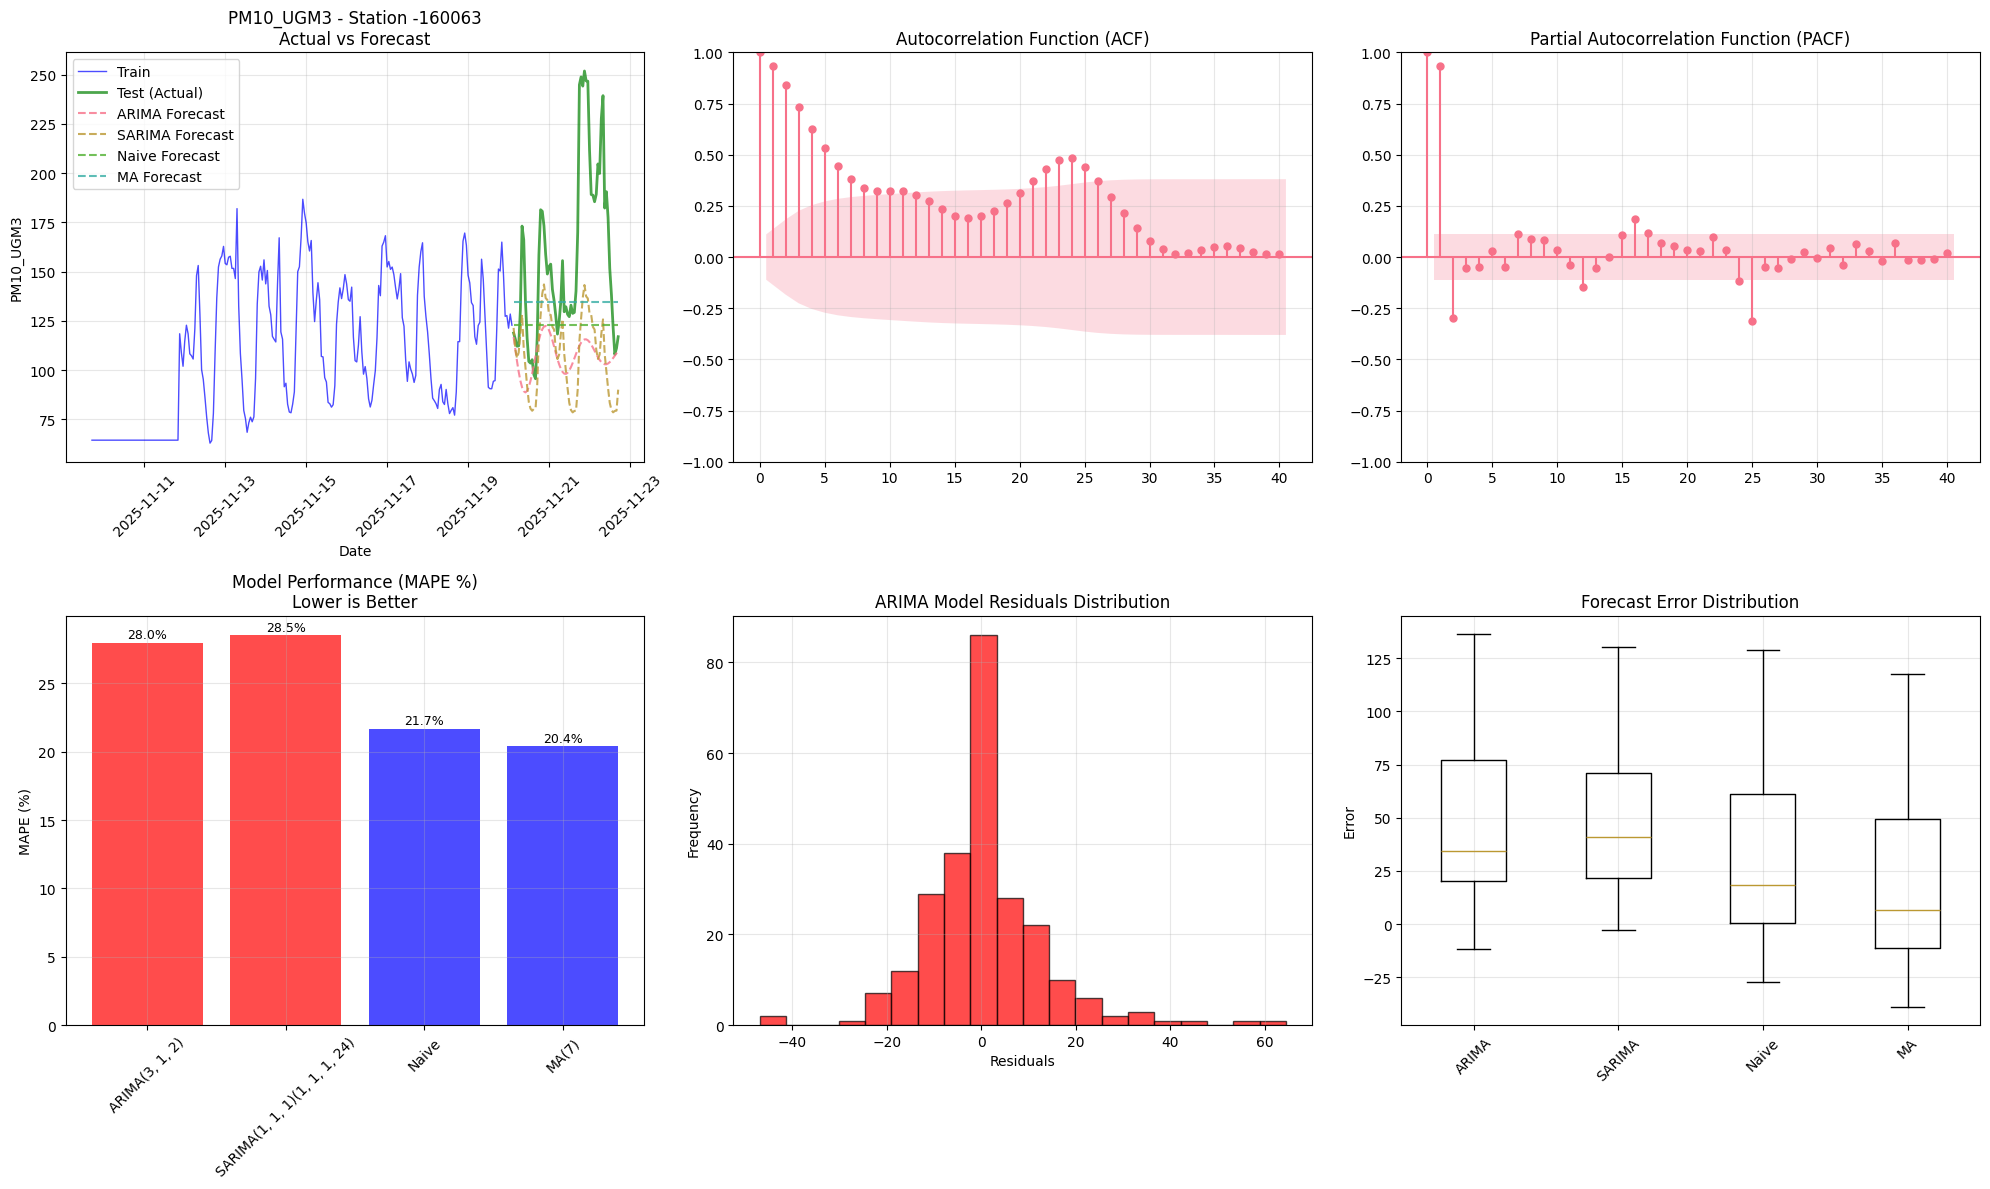


Processing station 12428...
  Modeling CO_PPB...

MODELING: Station 12428 - CO_PPB
  Data points - Total: 313, Train: 250, Test: 63
  Date range: 2025-11-09 17:00:00 to 2025-11-22 17:00:00
  Building ARIMA model...
    ARIMA(2, 2, 2) - AIC: 2837.41, MAPE: 29.55%
  Building SARIMA model...
    SARIMA(1, 1, 1)(1, 1, 1, 24) - AIC: 2600.25, MAPE: 15.32%
    MA(7) - MAPE: 29.48%


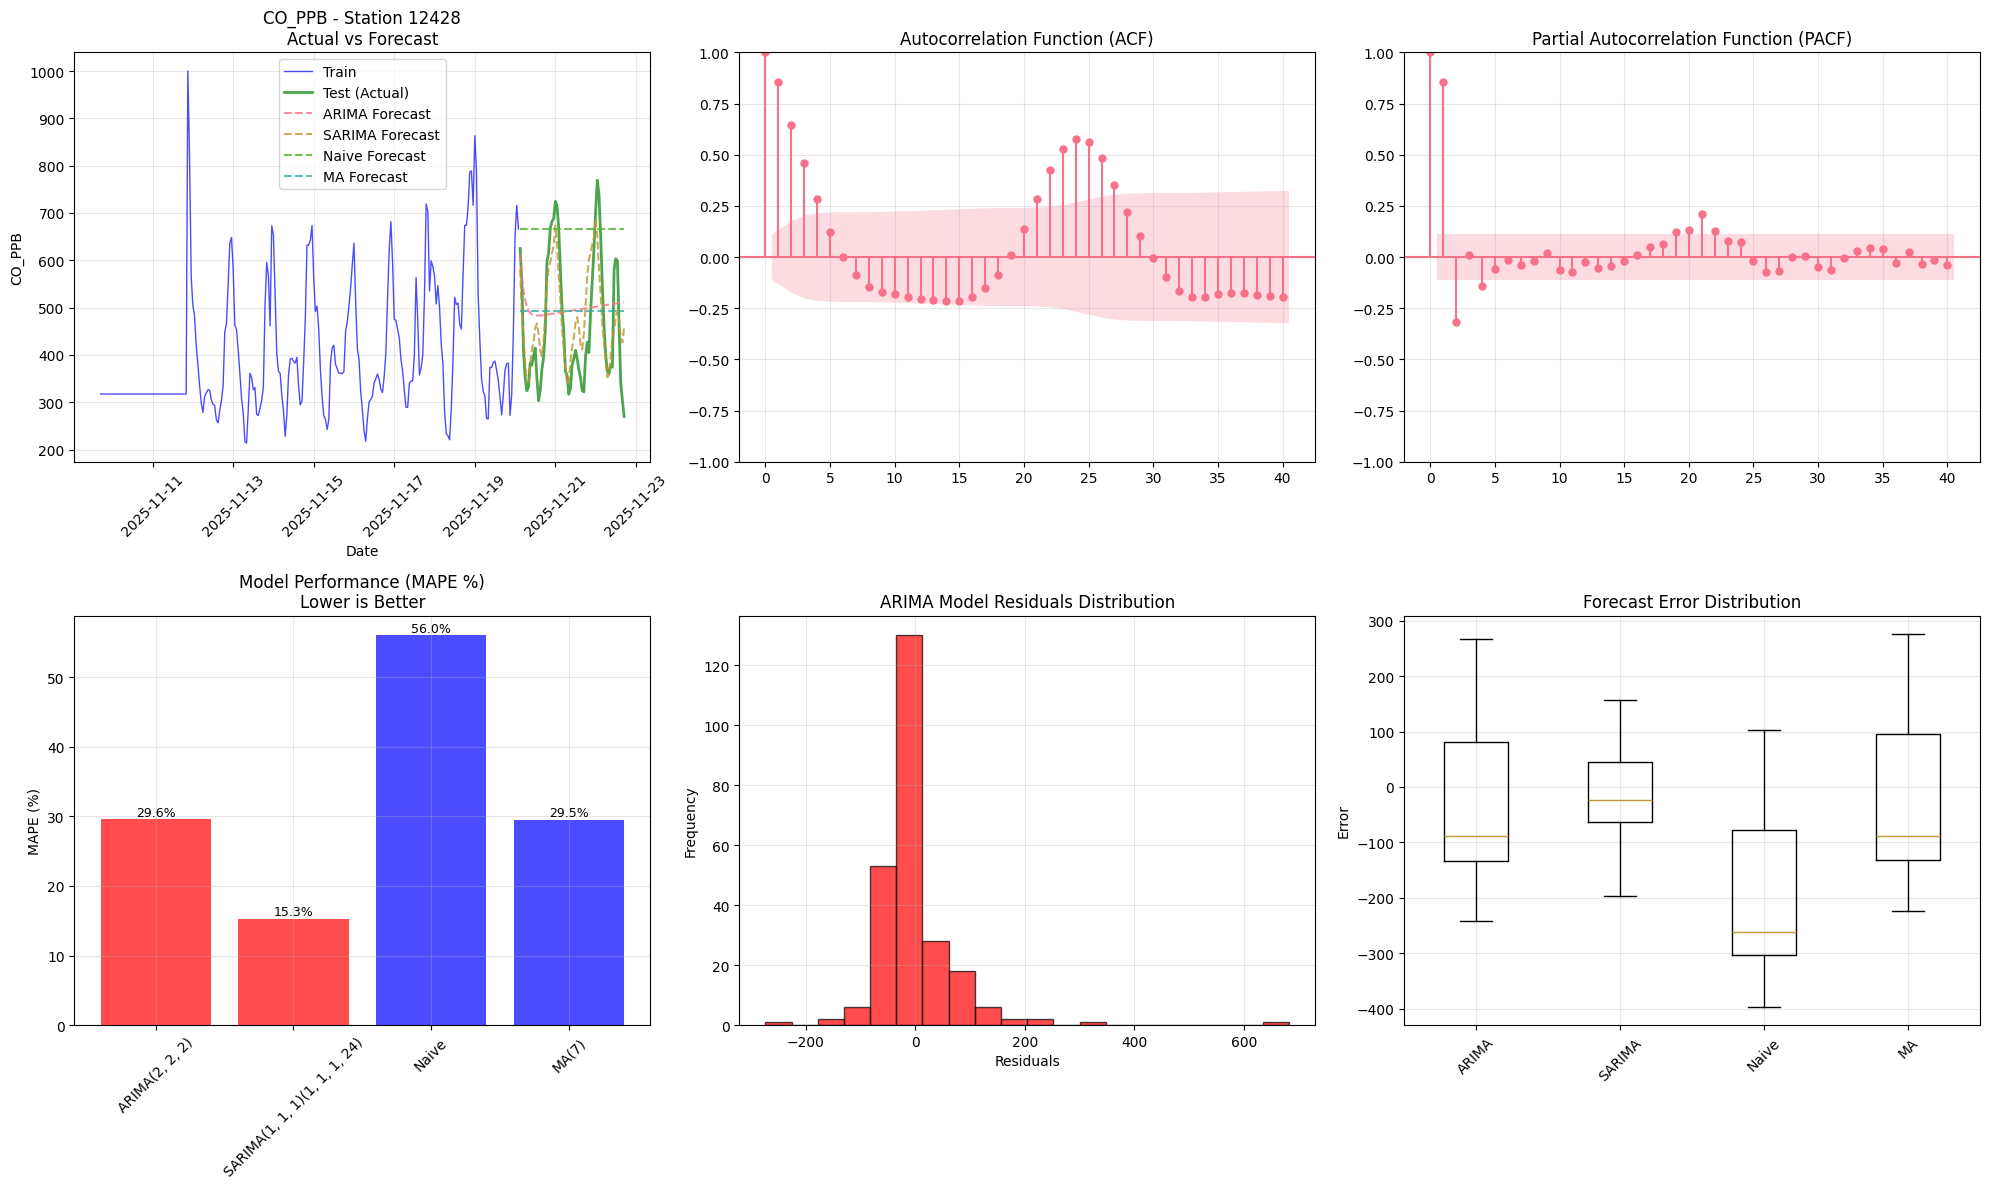

  Modeling NO2_PPB...

MODELING: Station 12428 - NO2_PPB
  Data points - Total: 313, Train: 250, Test: 63
  Date range: 2025-11-09 17:00:00 to 2025-11-22 17:00:00
  Building ARIMA model...
    ARIMA(1, 1, 2) - AIC: 1211.92, MAPE: 37.05%
  Building SARIMA model...
    SARIMA(1, 1, 1)(1, 1, 1, 24) - AIC: 1087.64, MAPE: 33.18%
    MA(7) - MAPE: 49.90%


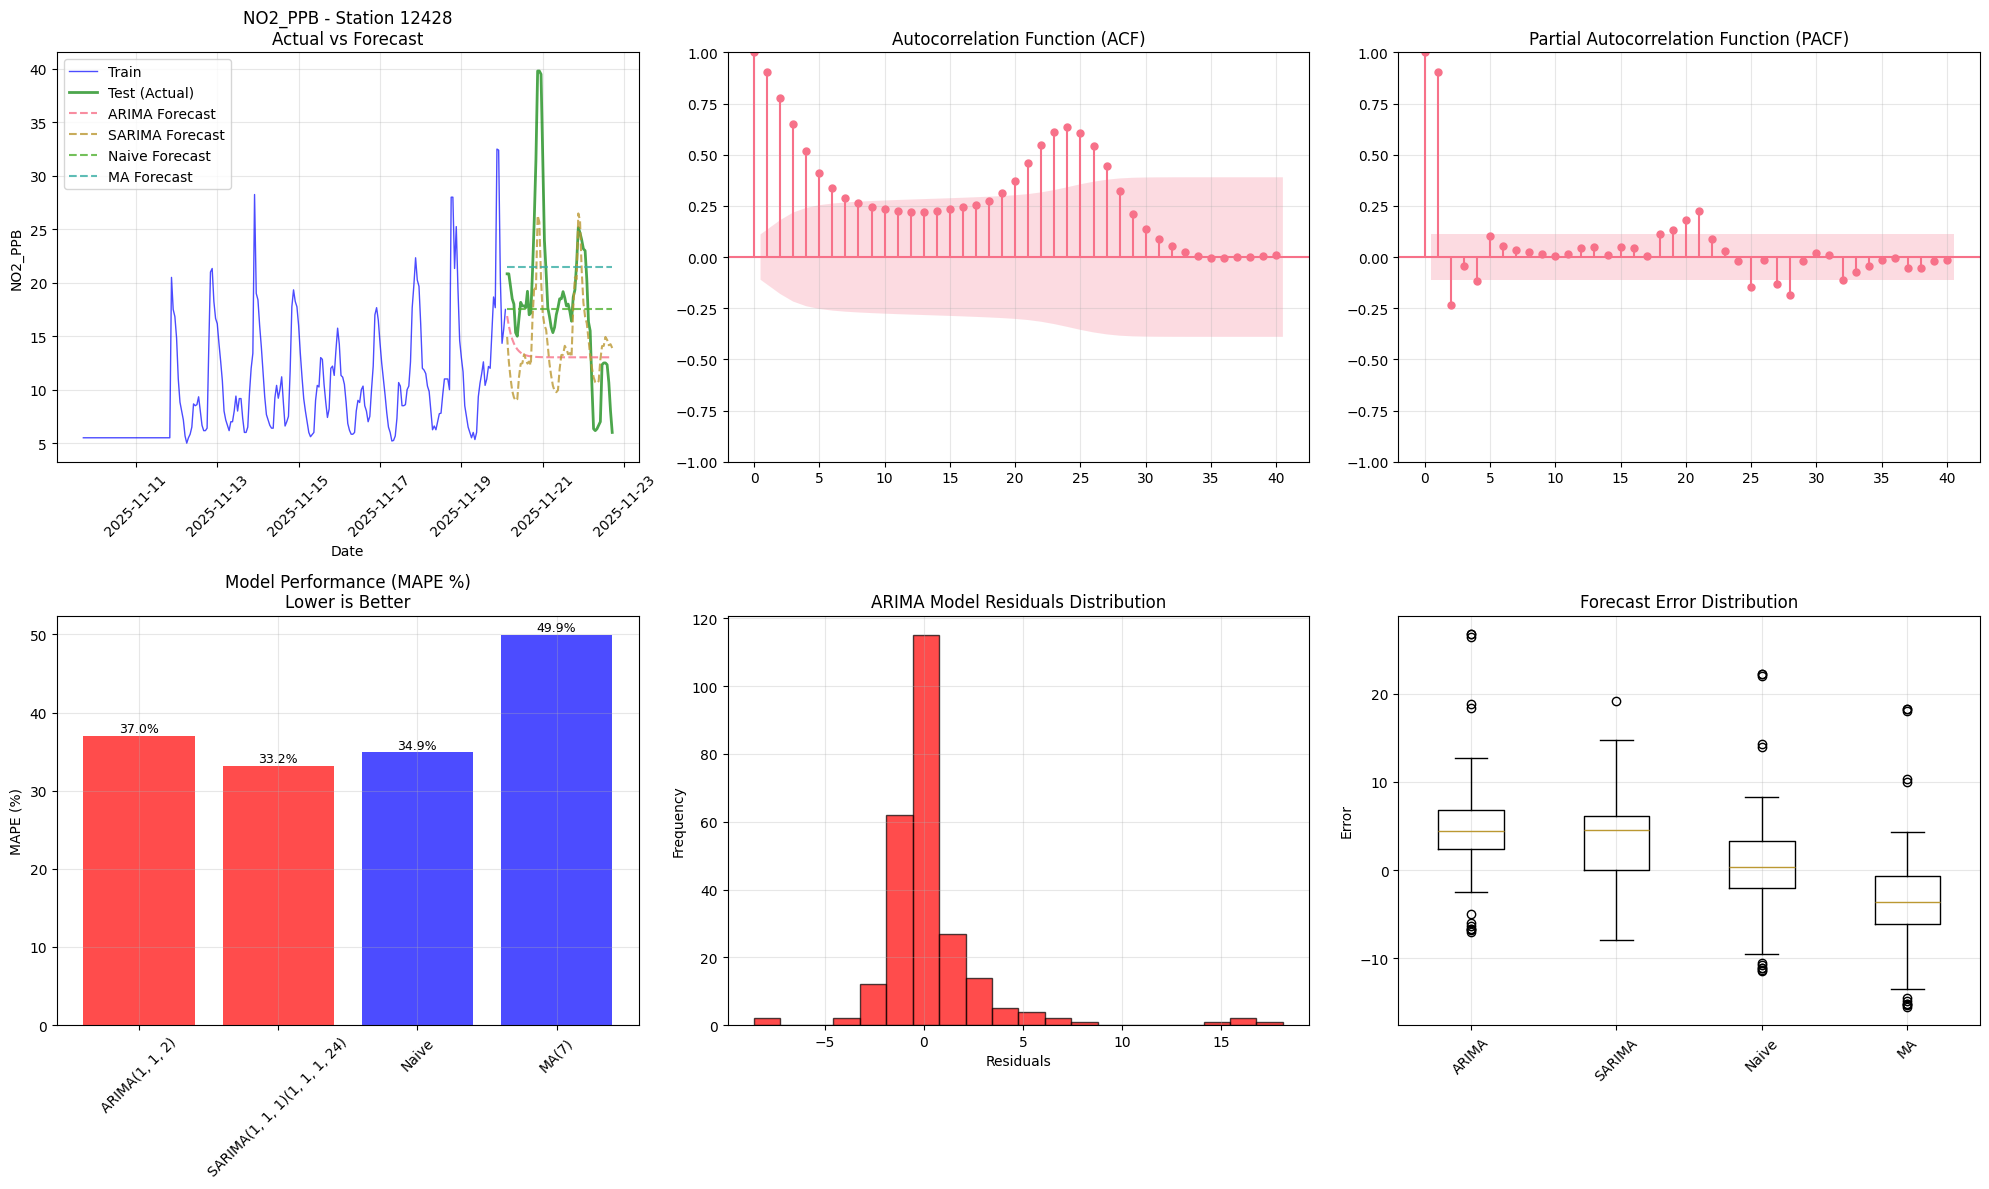

  Modeling O3_PPB...

MODELING: Station 12428 - O3_PPB
  Data points - Total: 313, Train: 250, Test: 63
  Date range: 2025-11-09 17:00:00 to 2025-11-22 17:00:00
  Building ARIMA model...
    ARIMA(3, 1, 3) - AIC: 1496.82, MAPE: 224.51%
  Building SARIMA model...
    SARIMA(1, 1, 1)(1, 1, 1, 24) - AIC: 1401.55, MAPE: 266.02%
    MA(7) - MAPE: 390.51%


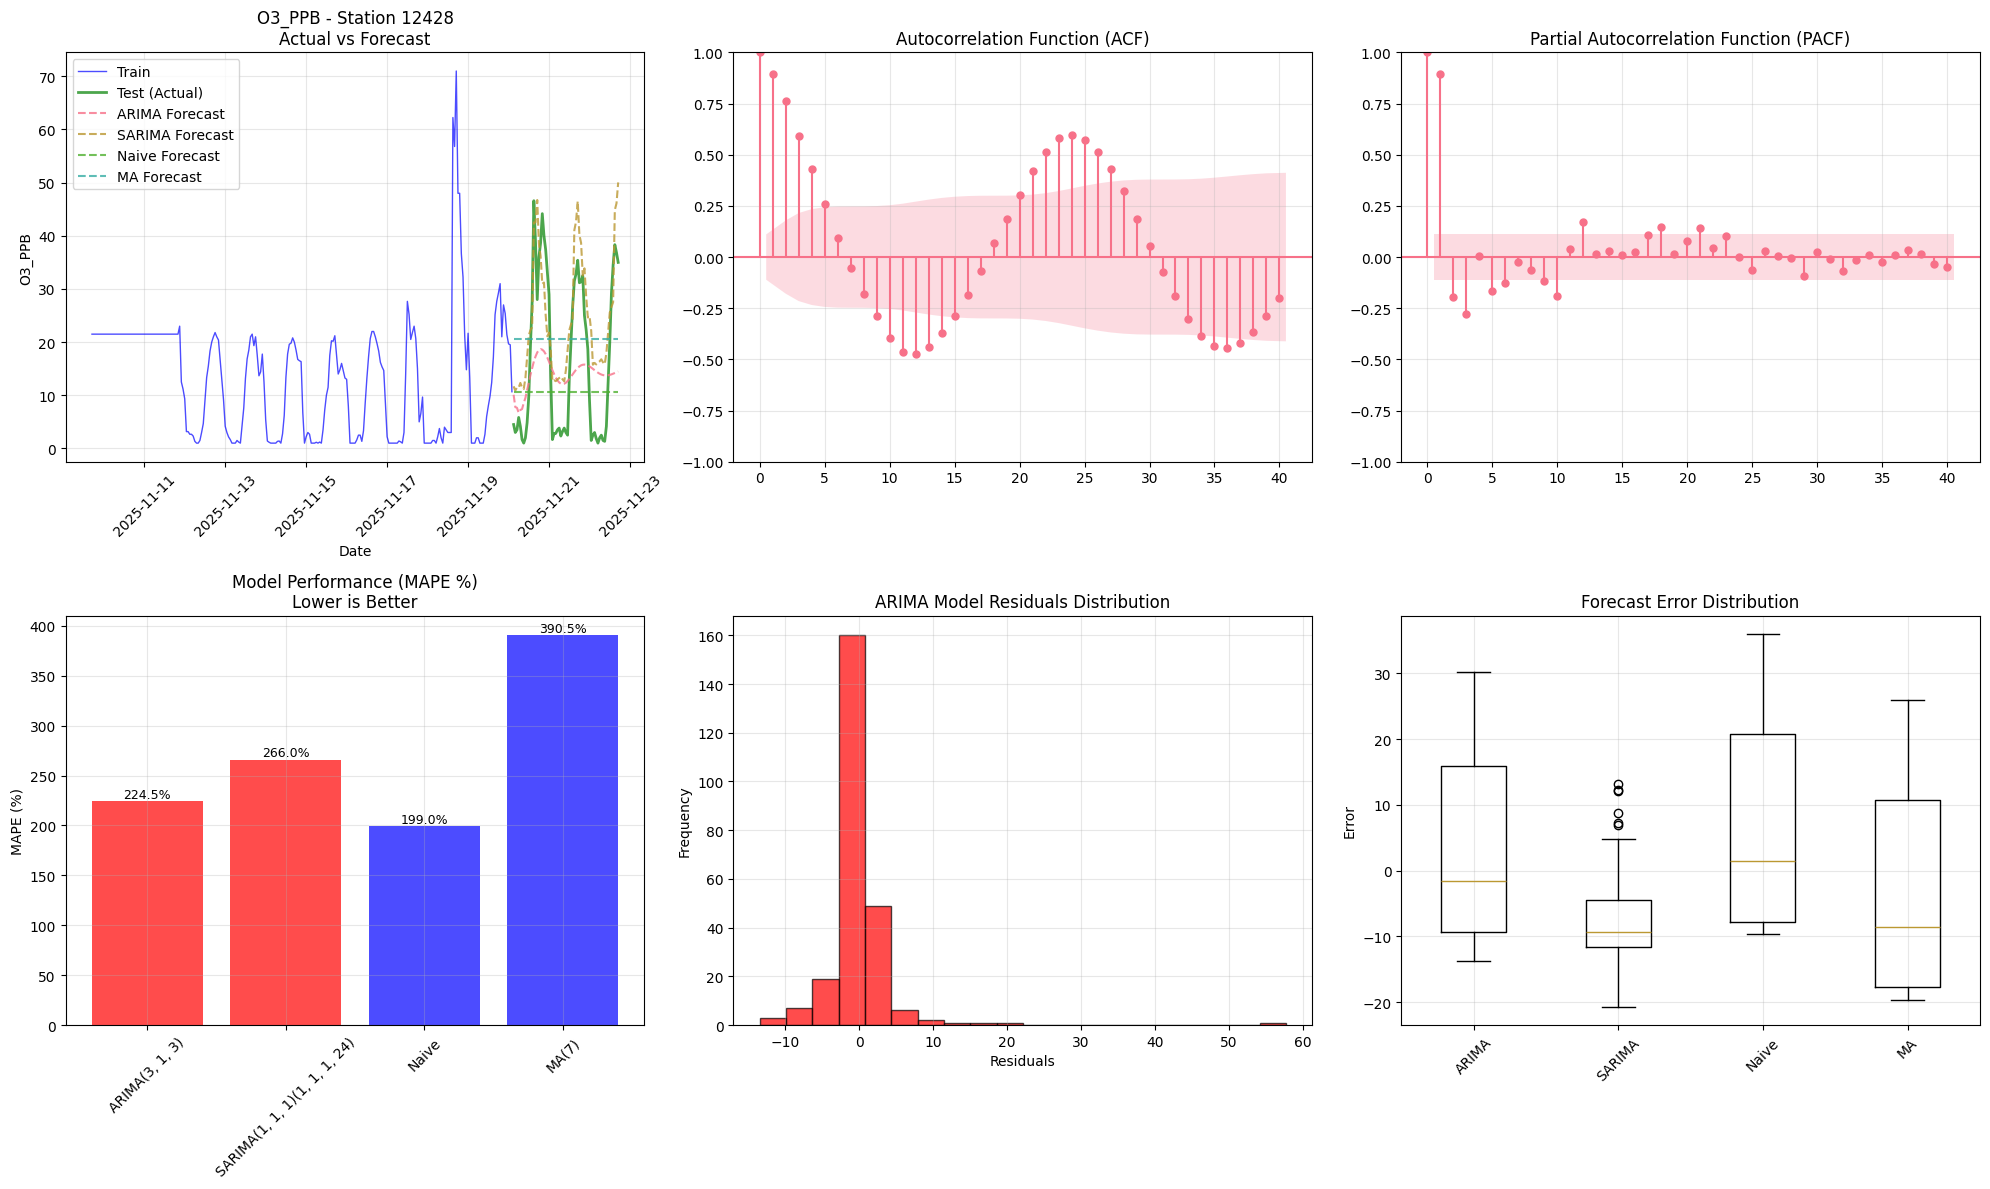

  Modeling PM10_UGM3...

MODELING: Station 12428 - PM10_UGM3
  Data points - Total: 313, Train: 250, Test: 63
  Date range: 2025-11-09 17:00:00 to 2025-11-22 17:00:00
  Building ARIMA model...
    ARIMA(3, 1, 2) - AIC: 1960.97, MAPE: 25.88%
  Building SARIMA model...
    SARIMA(1, 1, 1)(1, 1, 1, 24) - AIC: 1748.90, MAPE: 30.71%
    MA(7) - MAPE: 19.43%


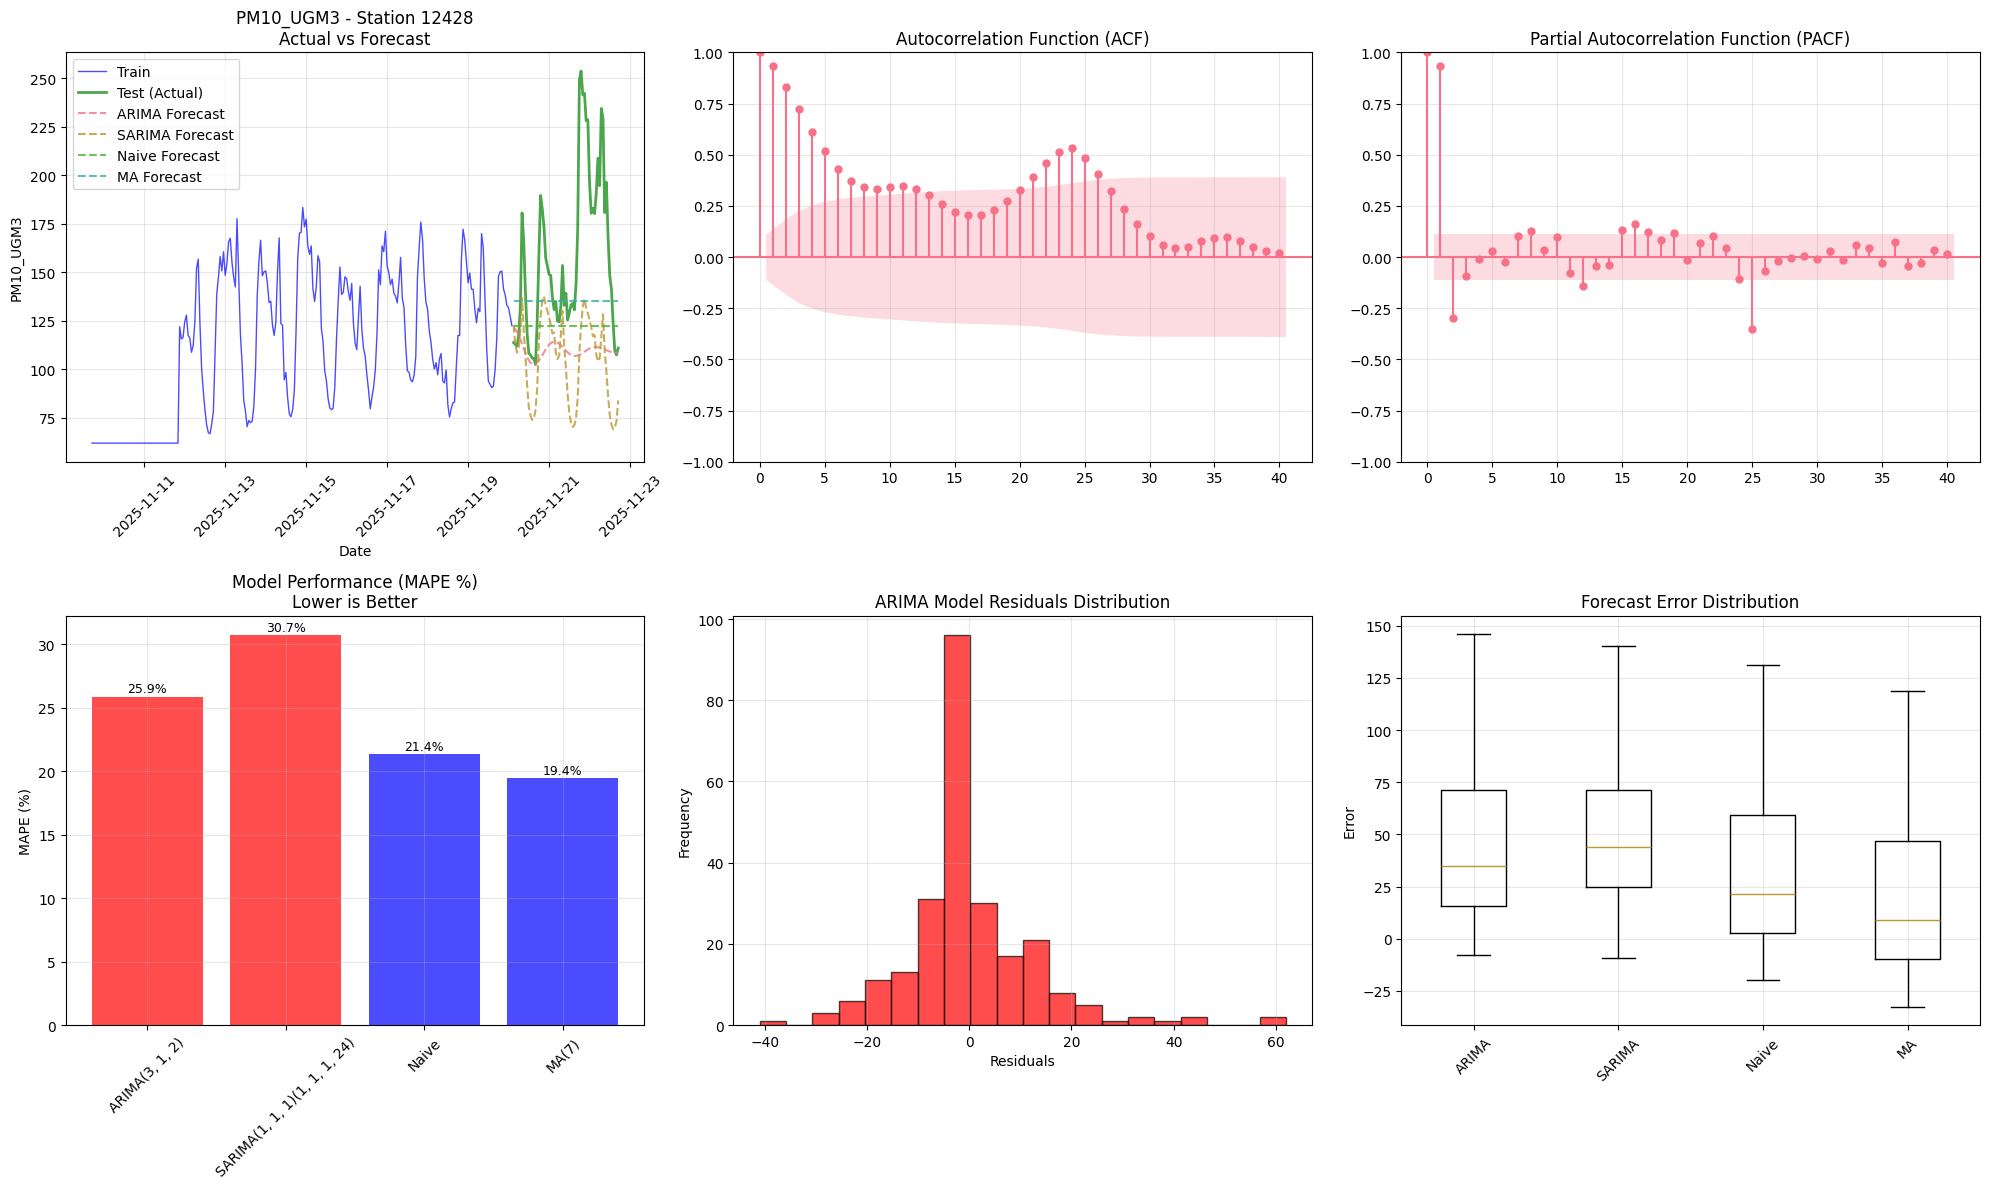


Processing station 13741...
  Modeling CO_PPB...

MODELING: Station 13741 - CO_PPB
  Data points - Total: 313, Train: 250, Test: 63
  Date range: 2025-11-09 17:00:00 to 2025-11-22 17:00:00
  Building ARIMA model...
    ARIMA(3, 1, 3) - AIC: 2780.96, MAPE: 17.02%
  Building SARIMA model...
    SARIMA(1, 1, 1)(1, 1, 1, 24) - AIC: 2552.28, MAPE: 15.67%
    MA(7) - MAPE: 19.67%


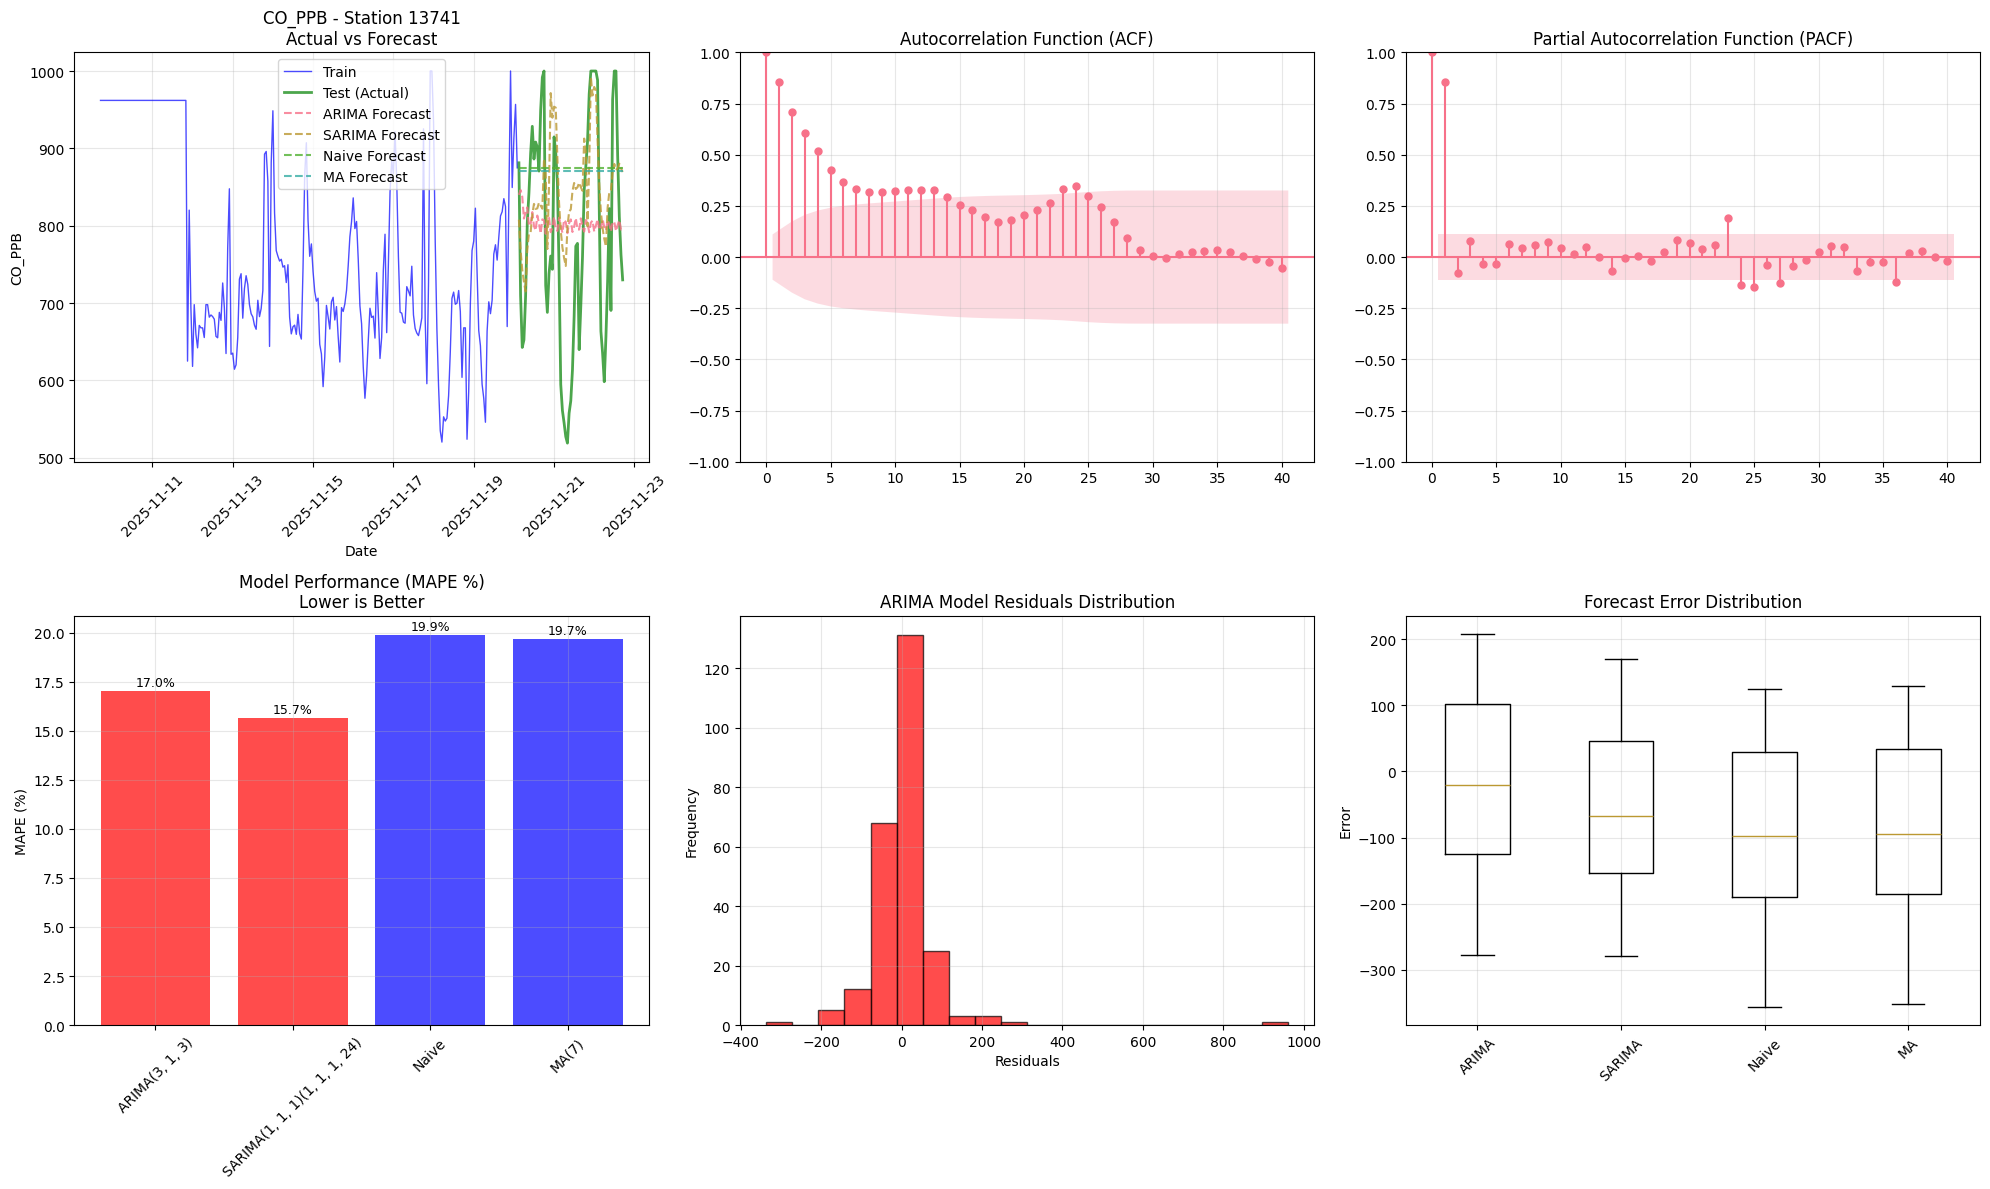

  Modeling NO2_PPB...

MODELING: Station 13741 - NO2_PPB
  Data points - Total: 313, Train: 250, Test: 63
  Date range: 2025-11-09 17:00:00 to 2025-11-22 17:00:00
  Building ARIMA model...
    ARIMA(3, 1, 3) - AIC: 1247.82, MAPE: 19.61%
  Building SARIMA model...
    SARIMA(1, 1, 1)(1, 1, 1, 24) - AIC: 1156.83, MAPE: 17.82%
    MA(7) - MAPE: 21.40%


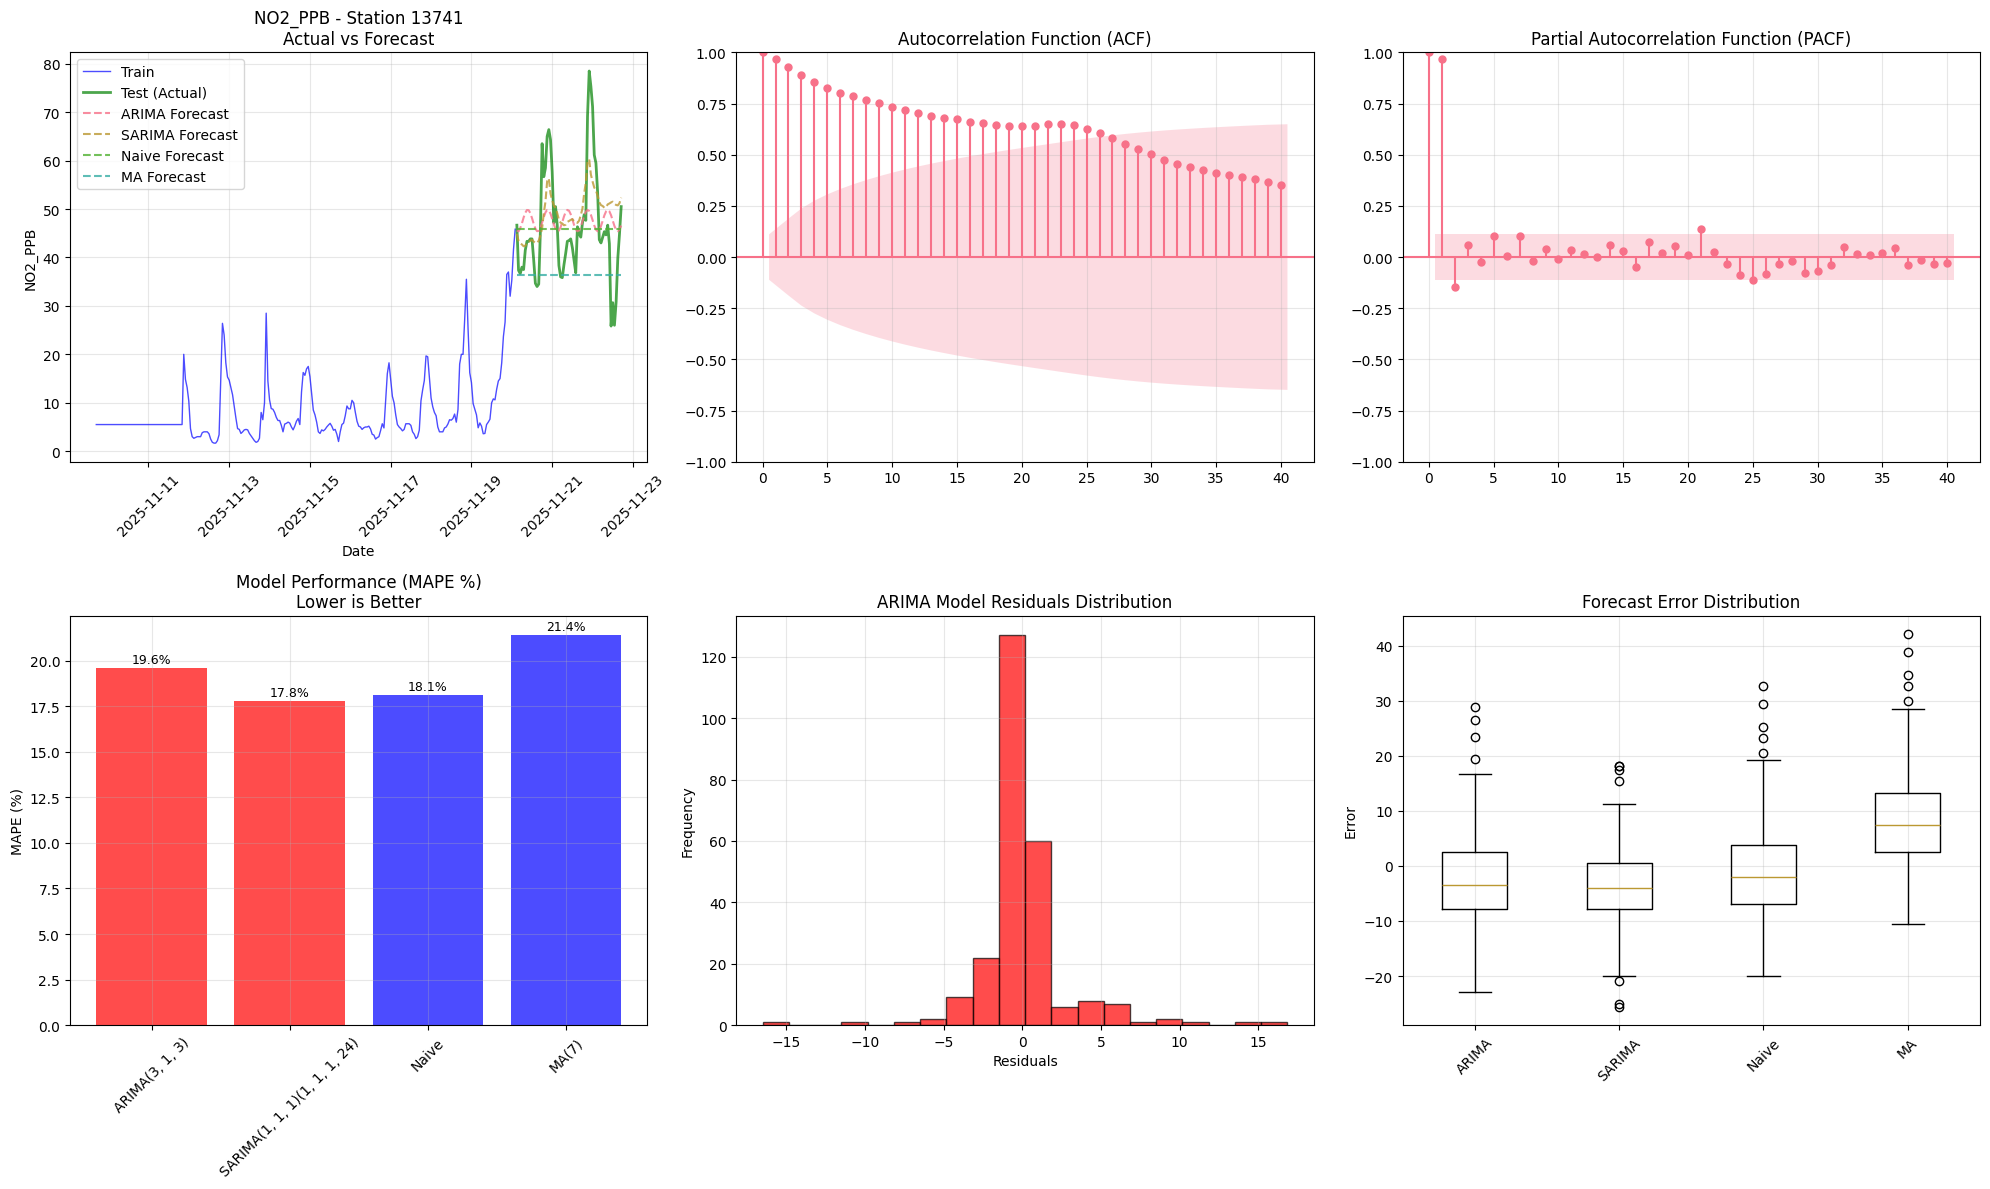

  Modeling O3_PPB...

MODELING: Station 13741 - O3_PPB
  Data points - Total: 313, Train: 250, Test: 63
  Date range: 2025-11-09 17:00:00 to 2025-11-22 17:00:00
  Building ARIMA model...
    ARIMA(2, 0, 1) - AIC: 1513.18, MAPE: 73.75%
  Building SARIMA model...
    SARIMA(1, 1, 1)(1, 1, 1, 24) - AIC: 1414.41, MAPE: 83.27%
    MA(7) - MAPE: 123.98%


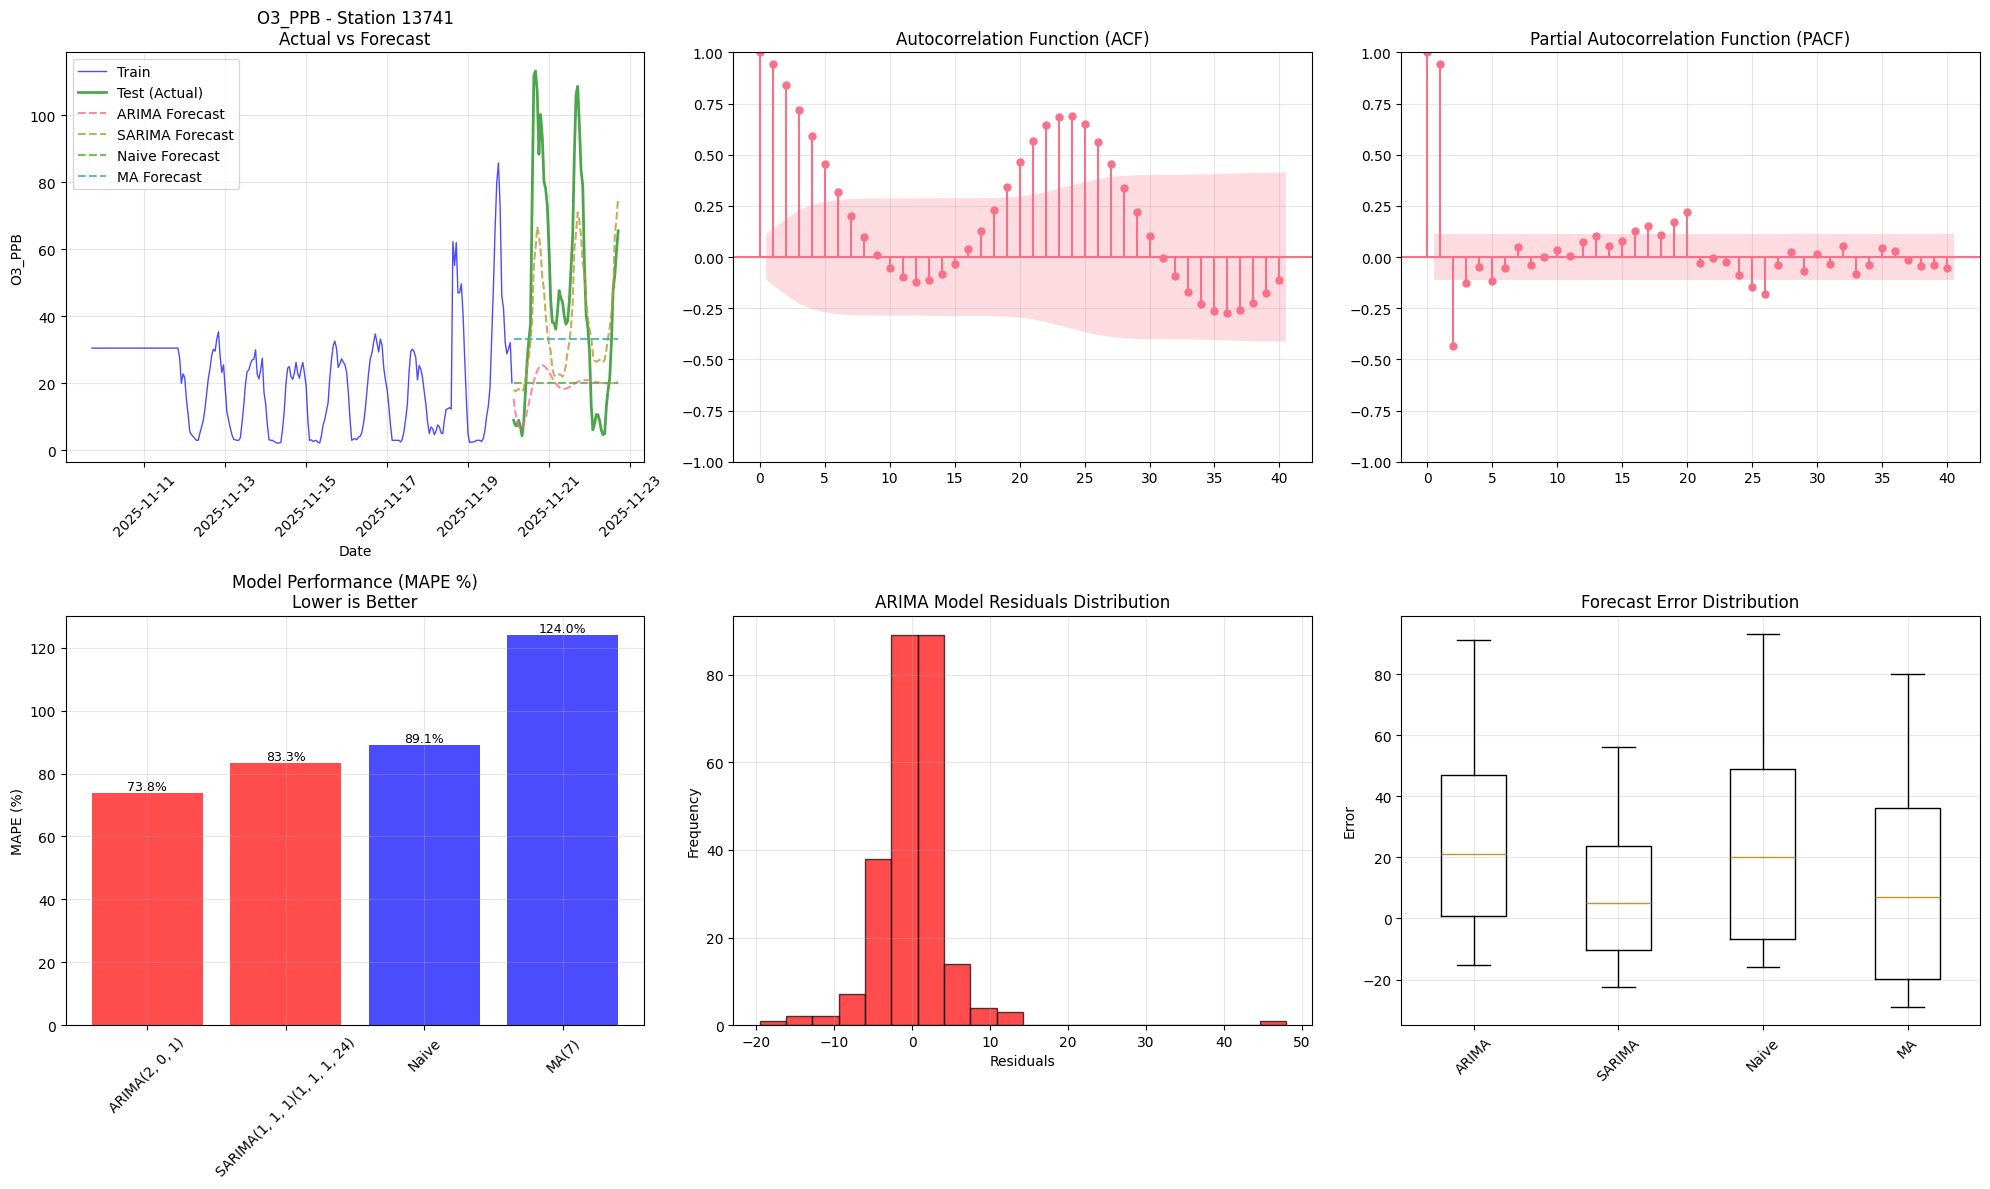

  Modeling PM10_UGM3...

MODELING: Station 13741 - PM10_UGM3
  Data points - Total: 313, Train: 250, Test: 63
  Date range: 2025-11-09 17:00:00 to 2025-11-22 17:00:00
  Building ARIMA model...
    ARIMA(3, 1, 2) - AIC: 1981.28, MAPE: 21.48%
  Building SARIMA model...
    SARIMA(1, 1, 1)(1, 1, 1, 24) - AIC: 1773.26, MAPE: 34.81%
    MA(7) - MAPE: 20.25%


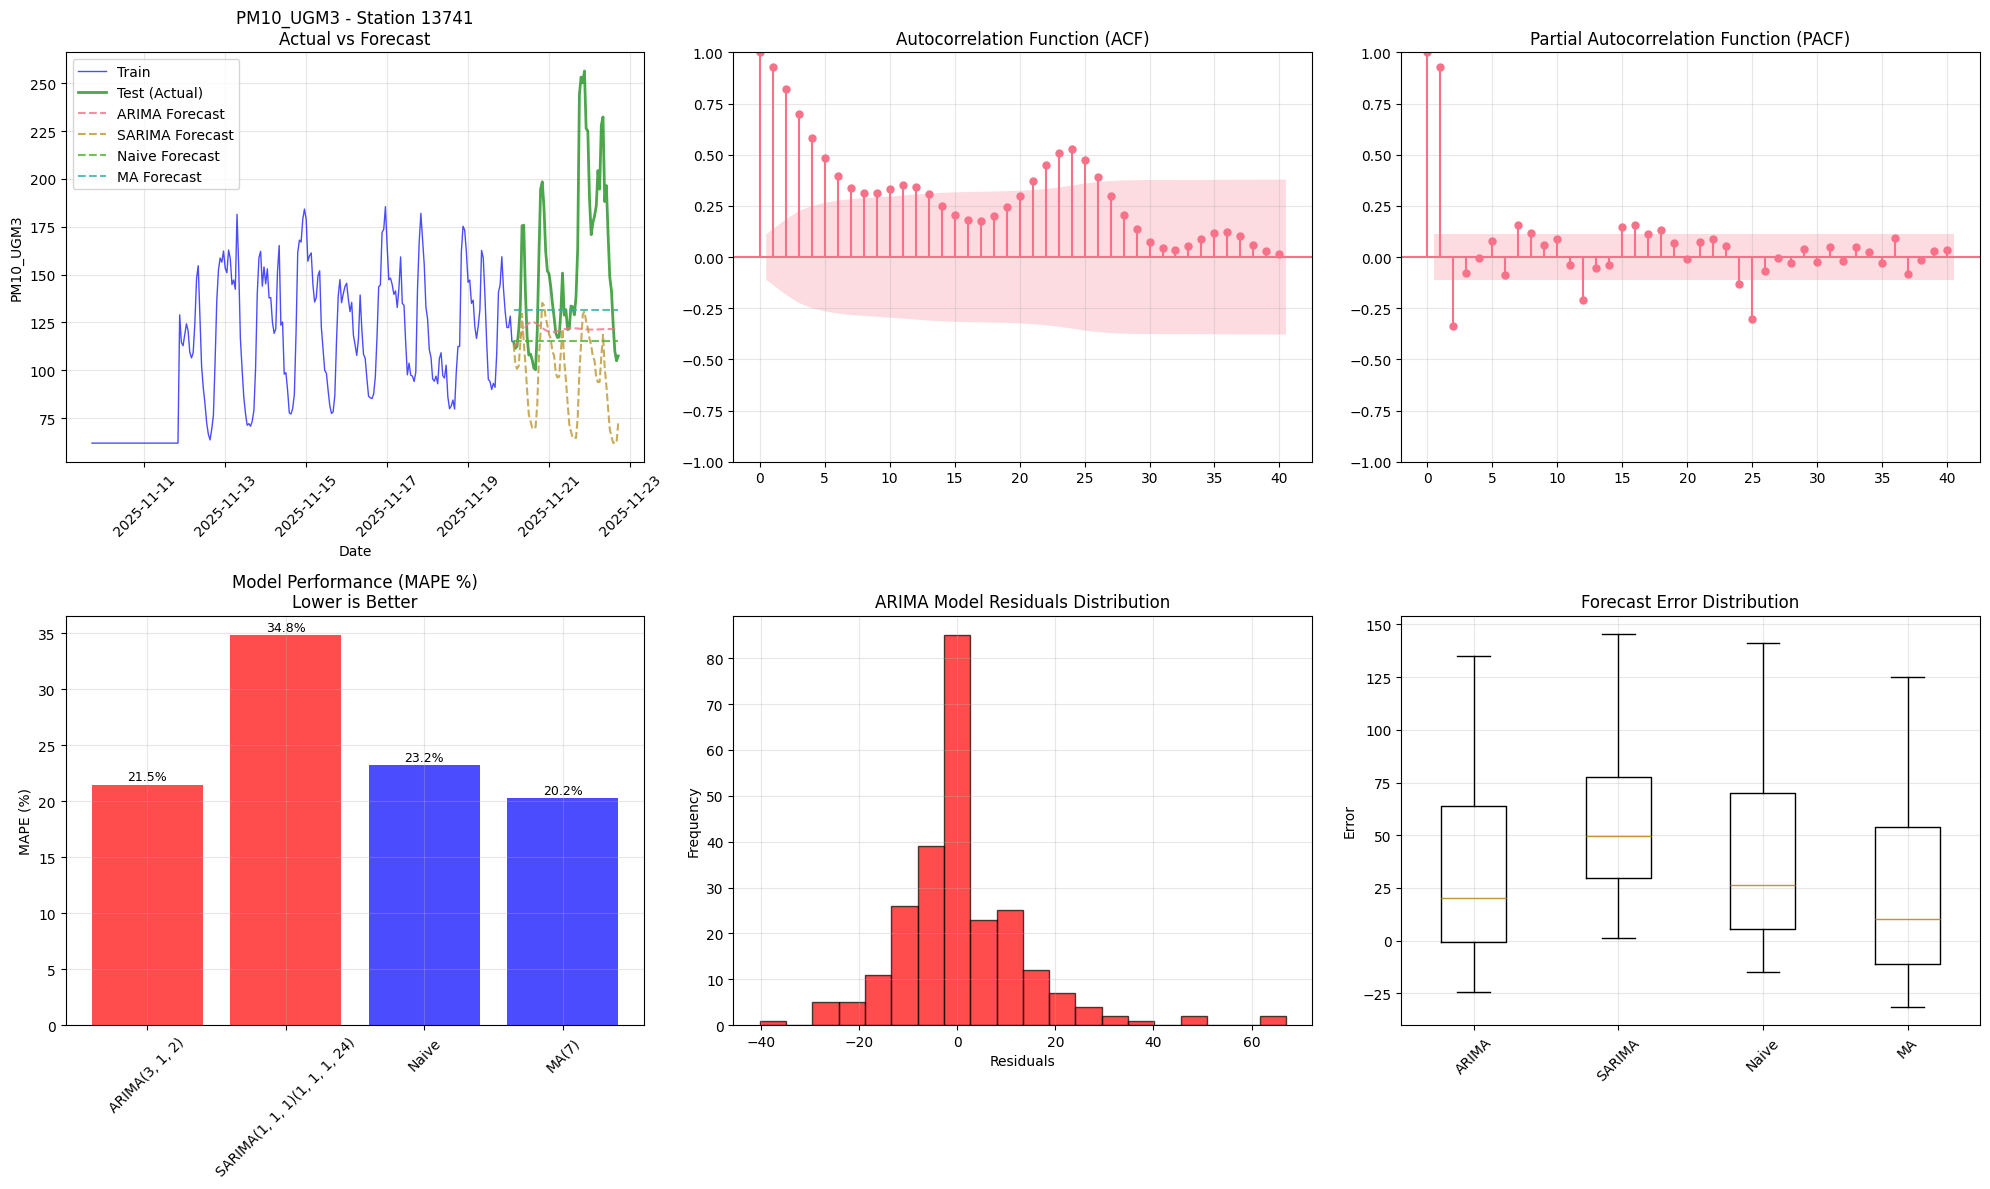


FINAL MODEL PERFORMANCE SUMMARY

Average Performance by Model Type:
                                  MAE             RMSE            MAPE  \
                                 mean     std     mean     std    mean   
Model                                                                    
ARIMA(1, 0, 3)                  6.063     NaN    7.991     NaN  33.810   
ARIMA(1, 1, 2)                  6.685     NaN    8.831     NaN  37.047   
ARIMA(1, 1, 3)                 71.516     NaN  150.947     NaN  11.382   
ARIMA(2, 0, 1)                 30.741     NaN   40.341     NaN  73.752   
ARIMA(2, 1, 3)                  7.087     NaN   12.869     NaN  27.035   
ARIMA(2, 2, 2)                125.900     NaN  139.849     NaN  29.554   
ARIMA(3, 1, 2)                 45.887   5.643   60.824   5.251  25.119   
ARIMA(3, 1, 3)                 48.428  66.165   56.096  76.020  87.047   
MA(7)                          42.451  45.347   57.799  58.910  62.571   
Naive                          51.485  62.9

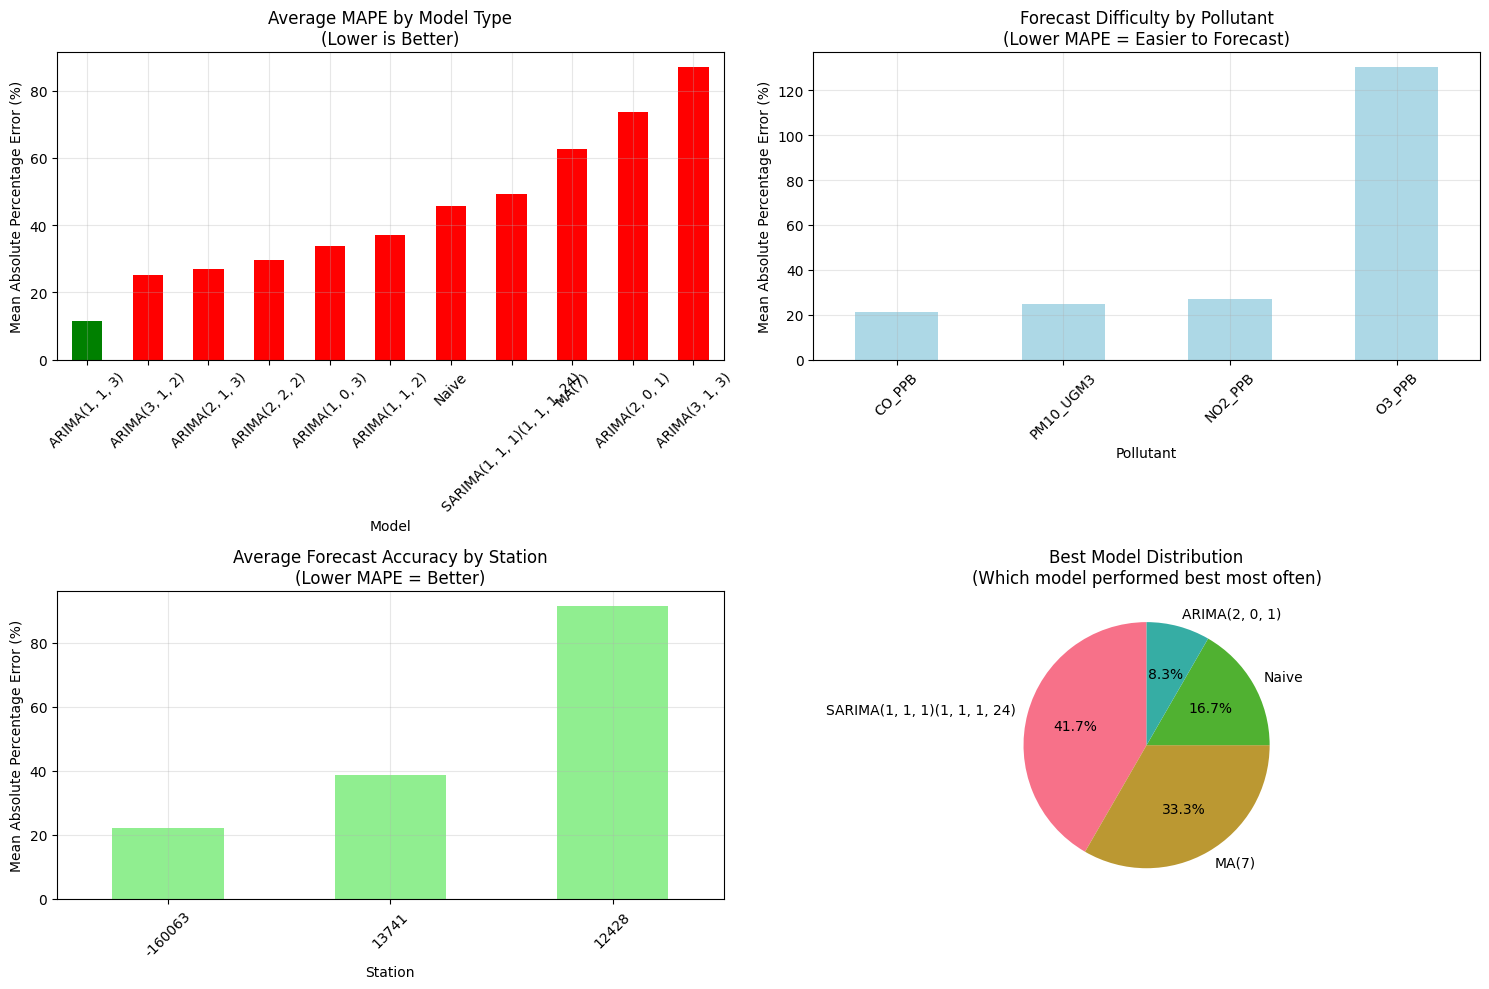


Total models built: 48
Best overall model: ARIMA(1, 1, 3) with 11.38% MAPE


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Load and prepare data
file_path = r"C:\Users\Narula\india_selected_cities_cleaned.csv"
df = pd.read_csv(file_path)
df['last_updated'] = pd.to_datetime(df['last_updated'])
df = df.sort_values(['locationId', 'last_updated'])

# Select pollutants for modeling
pollutants = ['CO_PPB', 'NO2_PPB', 'O3_PPB', 'PM10_UGM3', 'PM2_5_UGM3', 'SO2_PPB', 'AQI_IN']

def check_stationarity(timeseries):
    """Check if time series is stationary using Augmented Dickey-Fuller test"""
    result = adfuller(timeseries.dropna())
    return result[1] <= 0.05  # p-value <= 0.05 means stationary

def find_best_arima_params(timeseries, max_p=3, max_d=2, max_q=3):
    """Find optimal ARIMA parameters using AIC"""
    best_aic = np.inf
    best_order = None
    
    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(timeseries, order=(p, d, q))
                    fitted_model = model.fit()
                    if fitted_model.aic < best_aic:
                        best_aic = fitted_model.aic
                        best_order = (p, d, q)
                except:
                    continue
    return best_order, best_aic

def find_best_sarima_params(timeseries, seasonal_period=24):
    """Find optimal SARIMA parameters (simplified approach)"""
    # Test common seasonal patterns
    orders_to_test = [
        ((1,1,1), (1,1,1,24)),  # Daily seasonality for hourly data
        ((1,1,1), (1,1,1,7)),   # Weekly seasonality
        ((1,1,1), (1,1,1,12)),  # Monthly seasonality
    ]
    
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None
    
    for order, seasonal_order in orders_to_test:
        try:
            model = SARIMAX(timeseries, order=order, seasonal_order=seasonal_order)
            fitted_model = model.fit(disp=False)
            if fitted_model.aic < best_aic:
                best_aic = fitted_model.aic
                best_order = order
                best_seasonal_order = seasonal_order
        except:
            continue
    
    return best_order, best_seasonal_order, best_aic

def evaluate_model(y_true, y_pred, model_name):
    """Calculate model evaluation metrics"""
    # Handle cases where predictions might have different length
    min_len = min(len(y_true), len(y_pred))
    y_true = y_true[:min_len]
    y_pred = y_pred[:min_len]
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1, y_true))) * 100
    
    return {
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

def prepare_time_series_data(station_data, pollutant):
    """Prepare time series data handling duplicates and missing values"""
    # Create a copy and set datetime index
    ts_data = station_data[['last_updated', pollutant]].copy()
    ts_data = ts_data.dropna(subset=[pollutant])
    
    if len(ts_data) == 0:
        return None
    
    # Handle duplicate timestamps by taking the mean
    ts_data = ts_data.groupby('last_updated')[pollutant].mean().reset_index()
    
    # Set index and ensure proper time series
    ts_data = ts_data.set_index('last_updated')
    ts_data = ts_data.sort_index()
    
    # Resample to hourly frequency and handle missing values
    ts_data = ts_data.resample('H').mean()
    
    # Forward fill missing values (you can also use interpolation)
    ts_data = ts_data.ffill().bfill()  # Forward then backward fill
    
    # Remove any remaining NaN values
    ts_data = ts_data.dropna()
    
    return ts_data

# Main modeling function
def build_time_series_models(station_data, pollutant, station_id):
    """Build ARIMA and SARIMA models for a given station and pollutant"""
    
    print(f"\n{'='*60}")
    print(f"MODELING: Station {station_id} - {pollutant}")
    print(f"{'='*60}")
    
    # Prepare time series with proper frequency
    ts_data = prepare_time_series_data(station_data, pollutant)
    
    if ts_data is None or len(ts_data) < 100:
        print(f"  Insufficient data for modeling (only {len(ts_data) if ts_data else 0} points)")
        return None
    
    # Split data (80% train, 20% test)
    split_idx = int(len(ts_data) * 0.8)
    train = ts_data.iloc[:split_idx]
    test = ts_data.iloc[split_idx:]
    
    if len(train) < 50 or len(test) < 10:
        print(f"  Insufficient data after split (train: {len(train)}, test: {len(test)})")
        return None
    
    print(f"  Data points - Total: {len(ts_data)}, Train: {len(train)}, Test: {len(test)}")
    print(f"  Date range: {ts_data.index.min()} to {ts_data.index.max()}")
    
    results = []
    forecasts = {}
    
    # 1. ARIMA Model
    print("  Building ARIMA model...")
    try:
        # Find best ARIMA parameters
        best_arima_order, best_arima_aic = find_best_arima_params(train[pollutant])
        
        if best_arima_order:
            arima_model = ARIMA(train[pollutant], order=best_arima_order)
            arima_fitted = arima_model.fit()
            
            # Forecast
            arima_forecast = arima_fitted.forecast(steps=len(test))
            arima_metrics = evaluate_model(test[pollutant].values, arima_forecast.values, 
                                         f"ARIMA{best_arima_order}")
            results.append(arima_metrics)
            forecasts['ARIMA'] = arima_forecast
            print(f"    ARIMA{best_arima_order} - AIC: {best_arima_aic:.2f}, MAPE: {arima_metrics['MAPE']:.2f}%")
    except Exception as e:
        print(f"    ARIMA failed: {str(e)[:100]}...")
    
    # 2. SARIMA Model
    print("  Building SARIMA model...")
    try:
        best_order, best_seasonal_order, best_sarima_aic = find_best_sarima_params(train[pollutant])
        
        if best_order and best_seasonal_order:
            sarima_model = SARIMAX(train[pollutant], 
                                 order=best_order, 
                                 seasonal_order=best_seasonal_order)
            sarima_fitted = sarima_model.fit(disp=False)
            
            # Forecast
            sarima_forecast = sarima_fitted.forecast(steps=len(test))
            sarima_metrics = evaluate_model(test[pollutant].values, sarima_forecast.values, 
                                          f"SARIMA{best_order}{best_seasonal_order}")
            results.append(sarima_metrics)
            forecasts['SARIMA'] = sarima_forecast
            print(f"    SARIMA{best_order}{best_seasonal_order} - AIC: {best_sarima_aic:.2f}, MAPE: {sarima_metrics['MAPE']:.2f}%")
    except Exception as e:
        print(f"    SARIMA failed: {str(e)[:100]}...")
    
    # 3. Simple Benchmark (Naive forecast - last value)
    naive_forecast = pd.Series([train[pollutant].iloc[-1]] * len(test), index=test.index)
    naive_metrics = evaluate_model(test[pollutant].values, naive_forecast.values, "Naive")
    results.append(naive_metrics)
    forecasts['Naive'] = naive_forecast
    
    # 4. Simple Moving Average
    try:
        # Use last 7 values average
        window_size = min(7, len(train))
        last_values = train[pollutant].tail(window_size)
        ma_forecast = pd.Series([last_values.mean()] * len(test), index=test.index)
        ma_metrics = evaluate_model(test[pollutant].values, ma_forecast.values, f"MA({window_size})")
        results.append(ma_metrics)
        forecasts['MA'] = ma_forecast
        print(f"    MA({window_size}) - MAPE: {ma_metrics['MAPE']:.2f}%")
    except Exception as e:
        print(f"    Moving Average failed: {e}")
    
    # Create comparison plot
    if results:
        plt.figure(figsize=(20, 12))
        
        # Plot 1: Time series with forecasts
        plt.subplot(2, 3, 1)
        plt.plot(train.index, train[pollutant].values, label='Train', color='blue', alpha=0.7, linewidth=1)
        plt.plot(test.index, test[pollutant].values, label='Test (Actual)', color='green', alpha=0.7, linewidth=2)
        
        for model_name, forecast in forecasts.items():
            plt.plot(test.index, forecast.values, label=f'{model_name} Forecast', linestyle='--', alpha=0.8)
        
        plt.title(f'{pollutant} - Station {station_id}\nActual vs Forecast')
        plt.xlabel('Date')
        plt.ylabel(pollutant)
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        # Plot 2: ACF
        plt.subplot(2, 3, 2)
        plot_acf(ts_data[pollutant].dropna(), ax=plt.gca(), lags=min(40, len(ts_data)//4))
        plt.title('Autocorrelation Function (ACF)')
        plt.grid(True, alpha=0.3)
        
        # Plot 3: PACF
        plt.subplot(2, 3, 3)
        plot_pacf(ts_data[pollutant].dropna(), ax=plt.gca(), lags=min(40, len(ts_data)//4))
        plt.title('Partial Autocorrelation Function (PACF)')
        plt.grid(True, alpha=0.3)
        
        # Plot 4: Model comparison (MAPE)
        plt.subplot(2, 3, 4)
        results_df = pd.DataFrame(results)
        models = results_df['Model']
        mapes = results_df['MAPE']
        
        colors = ['red' if 'ARIMA' in model else 'orange' if 'SARIMA' in model else 'blue' for model in models]
        bars = plt.bar(models, mapes, color=colors, alpha=0.7)
        plt.title('Model Performance (MAPE %)\nLower is Better')
        plt.ylabel('MAPE (%)')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, mape in zip(bars, mapes):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                    f'{mape:.1f}%', ha='center', va='bottom', fontsize=9)
        
        # Plot 5: Residuals analysis (if ARIMA worked)
        plt.subplot(2, 3, 5)
        if 'ARIMA' in forecasts and 'arima_fitted' in locals():
            residuals = arima_fitted.resid
            plt.hist(residuals, bins=20, alpha=0.7, color='red', edgecolor='black')
            plt.title('ARIMA Model Residuals Distribution')
            plt.xlabel('Residuals')
            plt.ylabel('Frequency')
            plt.grid(True, alpha=0.3)
        
        # Plot 6: Forecast errors
        plt.subplot(2, 3, 6)
        error_data = []
        for model_name, forecast in forecasts.items():
            errors = test[pollutant].values - forecast.values
            error_data.append(errors)
        
        plt.boxplot(error_data, labels=forecasts.keys())
        plt.title('Forecast Error Distribution')
        plt.ylabel('Error')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return pd.DataFrame(results)
    
    return None

# Run modeling for selected stations and pollutants
print("COMPREHENSIVE TIME SERIES MODELING FOR POLLUTION DATA")
print("="*80)

# Check data quality first
print("Data Quality Check:")
for pollutant in pollutants:
    stations_with_data = df[df[pollutant].notna()]['locationId'].unique()
    print(f"  {pollutant}: {len(stations_with_data)} stations have data")

# Select stations with sufficient data
station_data_counts = df.groupby('locationId').size()
good_stations = station_data_counts[station_data_counts > 200].index[:3]  # Top 3 stations with most data

print(f"\nSelected stations for modeling: {list(good_stations)}")

all_model_results = []

for station in good_stations:
    station_data = df[df['locationId'] == station].copy()
    print(f"\nProcessing station {station}...")
    
    for pollutant in pollutants[:4]:  # Model first 4 pollutants
        if station_data[pollutant].notna().sum() > 100:
            print(f"  Modeling {pollutant}...")
            results = build_time_series_models(station_data, pollutant, station)
            if results is not None:
                results['Station'] = station
                results['Pollutant'] = pollutant
                all_model_results.append(results)

# Combine all results and create summary
if all_model_results:
    final_results = pd.concat(all_model_results, ignore_index=True)
    
    print("\n" + "="*80)
    print("FINAL MODEL PERFORMANCE SUMMARY")
    print("="*80)
    
    # Summary by model type
    model_summary = final_results.groupby('Model').agg({
        'MAE': ['mean', 'std'],
        'RMSE': ['mean', 'std'], 
        'MAPE': ['mean', 'std']
    }).round(3)
    
    print("\nAverage Performance by Model Type:")
    print(model_summary)
    
    # Best model for each pollutant-station combination
    print("\nBest Models for Each Case (Lowest MAPE):")
    best_models_idx = final_results.groupby(['Pollutant', 'Station'])['MAPE'].idxmin()
    best_models = final_results.loc[best_models_idx]
    print(best_models[['Pollutant', 'Station', 'Model', 'MAE', 'RMSE', 'MAPE']])
    
    # Create final comparison visualization
    plt.figure(figsize=(15, 10))
    
    # Model performance comparison
    plt.subplot(2, 2, 1)
    model_performance = final_results.groupby('Model')['MAPE'].mean().sort_values()
    colors = ['green' if x == model_performance.min() else 'red' for x in model_performance]
    model_performance.plot(kind='bar', color=colors)
    plt.title('Average MAPE by Model Type\n(Lower is Better)')
    plt.ylabel('Mean Absolute Percentage Error (%)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Pollutant forecast difficulty
    plt.subplot(2, 2, 2)
    pollutant_difficulty = final_results.groupby('Pollutant')['MAPE'].mean().sort_values()
    pollutant_difficulty.plot(kind='bar', color='lightblue')
    plt.title('Forecast Difficulty by Pollutant\n(Lower MAPE = Easier to Forecast)')
    plt.ylabel('Mean Absolute Percentage Error (%)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Station performance
    plt.subplot(2, 2, 3)
    station_performance = final_results.groupby('Station')['MAPE'].mean().sort_values()
    station_performance.plot(kind='bar', color='lightgreen')
    plt.title('Average Forecast Accuracy by Station\n(Lower MAPE = Better)')
    plt.ylabel('Mean Absolute Percentage Error (%)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Model preference by pollutant
    plt.subplot(2, 2, 4)
    model_counts = best_models['Model'].value_counts()
    model_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
    plt.title('Best Model Distribution\n(Which model performed best most often)')
    plt.ylabel('')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nTotal models built: {len(final_results)}")
    print(f"Best overall model: {model_performance.index[0]} with {model_performance.iloc[0]:.2f}% MAPE")
    
else:
    print("No successful models built. This could be due to:")
    print("1. Insufficient data points")
    print("2. Data quality issues (too many missing values)")
    print("3. Non-stationary time series")
    print("4. Computational limitations")

ARIMA (AutoRegressive Integrated Moving Average)  
AR (AutoRegressive): Uses past values to predict future values  
I (Integrated): Differences data to make it stationary (remove trends)  
MA (Moving Average): Uses past forecast errors to improve predictions  
Example: ARIMA(1,1,3) means:  
1 past value influences current value  
1 level of differencing applied  
3 past errors used in prediction  

MAPE - Mean absolute percentage error

In [27]:
"""
Spatio-temporal analysis pipeline (single-file)
Assumptions:
- You have a DataFrame named `df` in the environment OR a CSV file path 'aqi_data.csv'.
- Columns expected (per your sample): 
  ['scrape_id','lat','lon','locationId','city','state','country','last_updated',
   'AQI_IN','AQI_US','CO_PPB','H_PERCENT','NO2_PPB','O3_PPB','PM10_UGM3',
   'PM2_5_UGM3','SO2_PPB','T_C','PM1_UGM3','TVOC_PPM','Noise_DB']
- This script creates GeoDataFrames, computes global & local spatial stats,
  produces KDE and ST-KDE, basic temporal analysis, spatio-temporal clustering,
  and saves a Folium heatmap and some CSV outputs.
- Install dependencies: geopandas, libpysal, esda, folium, sklearn, statsmodels, ruptures, shapely, pyproj
"""

import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

# --- Optional libraries (handle gracefully if missing) ---
try:
    from libpysal.weights import KNN
    from esda import Moran, Moran_Local
    from esda.getisord import G_Local
    HAS_PYSAL = True
except Exception:
    HAS_PYSAL = False

try:
    from sklearn.neighbors import KernelDensity
    from sklearn.cluster import DBSCAN
    from sklearn.preprocessing import MinMaxScaler
    HAS_SK = True
except Exception:
    HAS_SK = False

try:
    import folium
    from folium.plugins import HeatMap
    HAS_FOLIUM = True
except Exception:
    HAS_FOLIUM = False

try:
    from statsmodels.tsa.seasonal import seasonal_decompose
    HAS_STATS = True
except Exception:
    HAS_STATS = False

try:
    import ruptures as rpt
    HAS_RUPTURES = True
except Exception:
    HAS_RUPTURES = False

# --------------------------
# 0. Load Data (or use existing df)
# --------------------------
if 'df' not in globals():
    if os.path.exists("aqi_data.csv"):
        df = pd.read_csv("aqi_data.csv")
    else:
        raise RuntimeError("No DataFrame `df` found and 'aqi_data.csv' not present. Please provide data.")

# quick rename/strip columns (tolerant)
df.columns = [c.strip() for c in df.columns]

# convert types & handle missing values
df['last_updated'] = pd.to_datetime(df['last_updated'], errors='coerce')
df['lat'] = pd.to_numeric(df['lat'], errors='coerce')
df['lon'] = pd.to_numeric(df['lon'], errors='coerce')
# AQI_US may be numeric string
df['AQI_US'] = pd.to_numeric(df['AQI_US'], errors='coerce')
df['AQI_IN'] = pd.to_numeric(df['AQI_IN'], errors='coerce')

# drop rows with no geometry or timestamp
df = df.dropna(subset=['lat','lon','last_updated']).reset_index(drop=True)

# --------------------------
# 1. Create GeoDataFrame (WGS84) and projected copy (metric)
# --------------------------
gdf = gpd.GeoDataFrame(df.copy(), geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")
gdf_proj = gdf.to_crs(epsg=3857)   # metric projection for distances

# --------------------------
# 2. Global Moran's I (spatial autocorrelation) - AQI_US
# --------------------------
if HAS_PYSAL:
    # Use k-nearest neighbors (k=5)
    try:
        w = KNN.from_dataframe(gdf_proj, k=5)
        w.transform = "R"
        aqi = gdf_proj['AQI_US'].fillna(gdf_proj['AQI_US'].mean()).values
        moran = Moran(aqi, w)
        print("Global Moran's I (AQI_US):", moran.I, "p-value:", moran.p_sim)
    except Exception as e:
        print("Moran's I calculation failed:", e)
else:
    print("libpysal/esda not available — skipping Moran's I / LISA / Gi* steps.")

# --------------------------
# 3. Local Moran (LISA) & Getis-Ord Gi* (if available)
# --------------------------
if HAS_PYSAL:
    try:
        local_mi = Moran_Local(aqi, w)
        gdf_proj['LISA_q'] = local_mi.q        # cluster quadrant codes (1..4)
        gdf_proj['LISA_p'] = local_mi.p_sim
        # Gi*
        gi = G_Local(aqi, w)
        gdf_proj['GiZ'] = gi.Zs
    except Exception as e:
        print("Local Moran / Gi* failed:", e)

# --------------------------
# 4. Spatial KDE (2D) on projected coordinates
# --------------------------
if HAS_SK:
    coords = np.vstack([gdf_proj.geometry.x.values, gdf_proj.geometry.y.values]).T
    # bandwidth chosen in meters; adjust as needed
    try:
        kde = KernelDensity(bandwidth=2000)  # 2km bandwidth
        kde.fit(coords)
        gdf_proj['kde_score'] = np.exp(kde.score_samples(coords))
    except Exception as e:
        print("KDE failed:", e)
else:
    print("sklearn not available — skipping KDE.")

# --------------------------
# 5. Temporal analyses (per-location time series, rolling means, decomposition)
# --------------------------
# Hourly aggregation across entire dataset (mean AQI_US)
hourly = df.set_index('last_updated').resample('1H').agg({'AQI_US':'mean'}).rename_axis('time').reset_index()
hourly.to_csv("hourly_aqi_us.csv", index=False)

# Rolling average per locationId (6-hour rolling)
df_sorted = df.sort_values(['locationId','last_updated'])
df_sorted['AQI_roll_6h'] = df_sorted.groupby('locationId')['AQI_US'].transform(lambda x: x.rolling(6, min_periods=1).mean())

# Decomposition for a sample city (if statsmodels available)
if HAS_STATS:
    sample_city = df[df['city'].notna()]['city'].iloc[0] if len(df['city'].dropna())>0 else None
    if sample_city:
        ts_city = df[df['city']==sample_city].set_index('last_updated').resample('1H')['AQI_US'].mean().dropna()
        if len(ts_city) >= 48:
            try:
                decomp = seasonal_decompose(ts_city, model='additive', period=24)
                # Save components to CSV
                decomp_df = pd.DataFrame({
                    'observed': decomp.observed,
                    'trend': decomp.trend,
                    'seasonal': decomp.seasonal,
                    'resid': decomp.resid
                }).dropna()
                decomp_df.to_csv(f"decomposition_{sample_city.replace(' ','_')}.csv")
            except Exception as e:
                print("Decomposition failed:", e)
        else:
            print(f"Not enough hourly samples for decomposition for city {sample_city} (need >=48).")
else:
    print("statsmodels not available — skipping seasonal decomposition.")

# --------------------------
# 6. Change point detection on city-average (optional)
# --------------------------
if HAS_RUPTURES and HAS_STATS:
    try:
        # choose city with most data
        city_counts = df.groupby('city').size().sort_values(ascending=False)
        city0 = city_counts.index[0]
        sig = df[df['city']==city0].set_index('last_updated').resample('1H')['AQI_US'].mean().dropna().values
        if len(sig) >= 30:
            algo = rpt.Pelt(model="rbf").fit(sig)
            bkps = algo.predict(pen=10)
            print(f"Change points for city {city0} (hour indices):", bkps)
    except Exception as e:
        print("Change point detection failed:", e)
else:
    print("ruptures or statsmodels not available — skipping change point detection.")

# --------------------------
# 7. Spatio-temporal cube (lat_bin, lon_bin, time_bin) aggregated
# --------------------------
df['time_bin'] = df['last_updated'].dt.floor('1H')
df['lat_bin'] = df['lat'].round(4)
df['lon_bin'] = df['lon'].round(4)
cube = df.groupby(['lat_bin','lon_bin','time_bin']).agg({
    'AQI_US':'mean',
    'scrape_id':'count'
}).rename(columns={'scrape_id':'n_obs'}).reset_index()
cube.to_csv("space_time_cube.csv", index=False)

# --------------------------
# 8. Spatio-Temporal KDE (simple approach: normalize time and space & run KDE)
# --------------------------
if HAS_SK:
    # normalize lat/lon to [0,1] within cube and time to [0,1]
    X_space = cube[['lat_bin','lon_bin']].values.astype(float)
    time_numeric = cube['time_bin'].astype(np.int64).values.astype(float)
    # stack and scale
    scaler = MinMaxScaler()
    Xt = np.column_stack([X_space, time_numeric.reshape(-1,1)])
    Xt_scaled = scaler.fit_transform(Xt)
    try:
        kde_st = KernelDensity(bandwidth=0.05).fit(Xt_scaled)
        cube['st_kde'] = np.exp(kde_st.score_samples(Xt_scaled))
        cube.to_csv("space_time_cube_with_stkde.csv", index=False)
    except Exception as e:
        print("ST-KDE failed:", e)
else:
    print("sklearn not available — skipping ST-KDE.")

# --------------------------
# 9. ST-DBSCAN (space+time clustering) - simplistic: use scaled coords + time
# --------------------------
if HAS_SK:
    try:
        pts_space = np.column_stack([gdf_proj.geometry.x.values, gdf_proj.geometry.y.values]).astype(float)
        # time scaled to days
        times = (gdf['last_updated'].astype('int64').values / 1e9)  # seconds
        times = (times - times.min()) / (3600*24)  # days from min
        pts_st = np.column_stack([pts_space, times])
        # scale spatial coordinates down (large values) using MinMaxScaler
        scaler2 = MinMaxScaler()
        pts_st_scaled = scaler2.fit_transform(pts_st)
        # DBSCAN: eps chosen in scaled units; adjust eps/min_samples for your data
        db = DBSCAN(eps=0.02, min_samples=8).fit(pts_st_scaled)
        gdf['st_cluster'] = db.labels_
        gdf.to_file("gdf_with_st_clusters.geojson", driver="GeoJSON")
    except Exception as e:
        print("ST-DBSCAN clustering failed:", e)
else:
    print("sklearn not available — skipping ST-DBSCAN.")

# --------------------------
# 10. Output / Visualizations
# --------------------------
# Save the projected gdf (with LISA/Gi/KDE if computed)
gdf_proj.to_file("gdf_projected_analysis.geojson", driver="GeoJSON")

# Folium heatmap (latest timestamp snapshot)
if HAS_FOLIUM:
    try:
        latest = df.sort_values('last_updated').groupby('locationId').last().reset_index()
        heat_df = latest[['lat','lon','AQI_US']].dropna()
        m = folium.Map(location=[heat_df['lat'].mean(), heat_df['lon'].mean()], zoom_start=11)
        HeatMap(heat_df.values.tolist(), radius=12, max_zoom=13).add_to(m)
        m.save("aqi_latest_heatmap.html")
        print("Saved folium heatmap to aqi_latest_heatmap.html")
    except Exception as e:
        print("Folium heatmap generation failed:", e)
else:
    print("folium not installed — skipping heatmap generation.")

# Save some CSV summaries
gdf_proj[['lat','lon','locationId','city','AQI_US','kde_score','GiZ']].to_csv("gdf_summary.csv", index=False)

print("Pipeline finished. Outputs written: "
      "hourly_aqi_us.csv, space_time_cube.csv, space_time_cube_with_stkde.csv (if computed), "
      "gdf_projected_analysis.geojson, gdf_summary.csv, aqi_latest_heatmap.html (if folium installed).")

# --------------------------
# End of script.
# --------------------------


Global Moran's I (AQI_US): 0.05054298700725814 p-value: 0.001
ruptures or statsmodels not available — skipping change point detection.
Saved folium heatmap to aqi_latest_heatmap.html
Pipeline finished. Outputs written: hourly_aqi_us.csv, space_time_cube.csv, space_time_cube_with_stkde.csv (if computed), gdf_projected_analysis.geojson, gdf_summary.csv, aqi_latest_heatmap.html (if folium installed).


In [29]:
pip install folium selenium pillow tqdm


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
httpcore 1.0.7 requires h11<0.15,>=0.13, but you have h11 0.16.0 which is incompatible.

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: C:\Python312\python.exe -m pip install --upgrade pip



   ---------------------------------------- 0.0/9.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.7 MB ? eta -:--:--
   ---- ----------------------------------- 1.0/9.7 MB 4.2 MB/s eta 0:00:03
   ---------- ----------------------------- 2.6/9.7 MB 6.3 MB/s eta 0:00:02
   ------------------ --------------------- 4.5/9.7 MB 6.7 MB/s eta 0:00:01
   --------------------- ------------------ 5.2/9.7 MB 6.0 MB/s eta 0:00:01
   ------------------------ --------------- 6.0/9.7 MB 5.9 MB/s eta 0:00:01
   ----------------------------- ---------- 7.1/9.7 MB 5.6 MB/s eta 0:00:01
   ---------------------------------- ----- 8.4/9.7 MB 5.7 MB/s eta 0:00:01
   -------------------------------------- - 9.4/9.7 MB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 9.7/9.7 MB 5.5 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.2.3
    Uninstalling urllib3-2.2.3:
      Successfully uninstalled urllib3-2.2.3
  Attempting uninstal

In [30]:
sudo apt install chromium-chromedriver   # (Colab)


SyntaxError: invalid syntax (12885106.py, line 1)

In [31]:
import os
import folium
from folium.plugins import HeatMap
from selenium import webdriver
from PIL import Image
from tqdm import tqdm
import pandas as pd
import time

# -----------------------------
# CONFIG
# -----------------------------
df_anim = df.copy()   # your original dataframe
df_anim['last_updated'] = pd.to_datetime(df_anim['last_updated'])

output_folder = "frames"
gif_name = "aqi_spatiotemporal.gif"

start_time = df_anim['last_updated'].min()
end_time   = df_anim['last_updated'].max()

# Choose time gap between frames (e.g. '30min', '1H', '3H')
time_step = '1H'

# -----------------------------
# CREATE FOLDER FOR FRAMES
# -----------------------------
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# -----------------------------
# SETUP SELENIUM (CHROME)
# -----------------------------
options = webdriver.ChromeOptions()
options.add_argument("--headless")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
driver = webdriver.Chrome(options=options)

# -----------------------------
# GENERATE MAPS FRAME BY FRAME
# -----------------------------
timestamps = pd.date_range(start=start_time, end=end_time, freq=time_step)

print("Generating map frames...")

for i, t in enumerate(tqdm(timestamps)):
    slice_df = df_anim[df_anim['last_updated'] == t]

    if slice_df.empty:
        continue

    center_lat = slice_df['lat'].mean()
    center_lon = slice_df['lon'].mean()

    m = folium.Map(location=[center_lat, center_lon], zoom_start=11)
    heat_data = slice_df[['lat','lon','AQI_US']].dropna().values.tolist()

    HeatMap(
        heat_data,
        radius=18,
        max_zoom=13,
        blur=25
    ).add_to(m)

    filename = f"{output_folder}/frame_{i:03d}.html"
    m.save(filename)

    # Convert HTML to PNG using Selenium
    driver.get("file://" + os.path.abspath(filename))
    time.sleep(1)

    screenshot_path = f"{output_folder}/frame_{i:03d}.png"
    driver.save_screenshot(screenshot_path)

driver.quit()

# -----------------------------
# CREATE GIF FROM IMAGES
# -----------------------------
print("Creating GIF...")

frames = []
png_files = sorted([f for f in os.listdir(output_folder) if f.endswith(".png")])

for file in png_files:
    frame = Image.open(os.path.join(output_folder, file))
    frames.append(frame)

frames[0].save(
    gif_name,
    save_all=True,
    append_images=frames[1:],
    duration=400,   # speed (ms per frame)
    loop=0
)

print(f"🎉 Spatio-temporal GIF saved as: {gif_name}")


Generating map frames...


100%|████████████████████████████████████████████████████████████████████████████████| 312/312 [05:14<00:00,  1.01s/it]


Creating GIF...
🎉 Spatio-temporal GIF saved as: aqi_spatiotemporal.gif
